In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime, random
import numpy as np; np.random.seed(13)
import matplotlib.pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate as concat
from keras import backend as K
from keras.optimizers import Adam,SGD
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn import metrics
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import keras
import h5py
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, Normalizer, StandardScaler
import math
import joblib
from keras.layers import BatchNormalization

from keras.callbacks import CSVLogger
from scipy.stats import norm
import seaborn as sns
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras import metrics

import matplotlib as mpl
%matplotlib inline
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
"""
Limit GPU memory consumption
"""
tfgraph = tf.get_default_graph()
with tfgraph.as_default():
    config = tf.ConfigProto(
        intra_op_parallelism_threads=12)
    
    
    config.gpu_options.per_process_gpu_memory_fraction = 0.8
    tfSess = tf.Session(config=config)
    K.set_session(tfSess)

In [3]:
# load preprocessed dataset from a specific location on the computer
datapath1 = os.path.join(r'D:\DATA\Datasets','IoT2023.csv')
full_data=pd.read_csv(datapath1)

##check if data_train has both attack (1) and normal (0) flows 
print(full_data['label'].value_counts())

1    3712305
0     211066
Name: label, dtype: int64


In [4]:
############# TRAINING DATA FOR DISCRIMINATOR###################
##select best features using HFSE only
final_data=full_data.iloc[:, [0,1,3,7,8,9,11,14,15, 17,18,20,30,35,37,39,40,41,42,44,46]]
final_data.head(2)


,flow_duration,Header_Length,Duration,fin_flag_number,syn_flag_number,rst_flag_number,ack_flag_number,ack_count,syn_count,urg_count,...,HTTPS,ICMP,Max,Std,IAT,Number,Magnitue,Radius,Variance,label
0,0.0,54.00,64.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,54.0,0.000000,8.334383e+07,9.5,10.392305,0.000000,0.00,1
1,0.0,57.04,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,66.3,2.822973,8.292607e+07,9.5,10.464666,4.010353,0.05,1


In [5]:
####seperate attack and benign data
###for normal data
normal= final_data[final_data['label'] == 0]
normal.head()

,flow_duration,Header_Length,Duration,fin_flag_number,syn_flag_number,rst_flag_number,ack_flag_number,ack_count,syn_count,urg_count,...,HTTPS,ICMP,Max,Std,IAT,Number,Magnitue,Radius,Variance,label
22,37.887028,1687747.1,63.5,0.0,0.0,0.0,1.0,0.0,0.0,58.6,...,1.0,0.0,817.5,332.122451,5.235219e-03,5.5,24.333355,469.692075,0.9,0
54,48.272384,128041.4,97.8,0.0,0.0,0.0,1.0,0.0,0.4,312.5,...,1.0,0.0,1566.4,694.907070,1.665200e+08,13.5,36.393289,983.968335,1.0,0
70,48.095663,101026.4,137.7,0.0,0.0,0.0,1.0,0.0,0.8,137.9,...,1.0,0.0,3922.9,1302.117190,2.724581e-02,5.5,47.214170,1841.471789,0.9,0
78,46.342407,1301464.8,168.3,0.0,0.0,0.0,1.0,0.0,1.2,58.8,...,1.0,0.0,66.0,0.428562,3.804951e-02,5.5,11.472815,0.606078,0.2,0
86,88.807750,5290348.6,63.6,0.0,0.0,0.0,1.0,0.0,1.6,250.3,...,1.0,0.0,1514.0,101.938534,1.833391e-03,5.5,54.184531,144.162858,0.2,0


In [6]:
normal_data=normal.values
#Split data into training data (X) and target label(Y)
X_norm=normal_data[:,:-1] #gets elements of array but the last one ####features
Y_norm=normal_data[:,-1] ### label

In [7]:
##for attack data
attack= final_data[final_data['label'] == 1]
attack.head()


,flow_duration,Header_Length,Duration,fin_flag_number,syn_flag_number,rst_flag_number,ack_flag_number,ack_count,syn_count,urg_count,...,HTTPS,ICMP,Max,Std,IAT,Number,Magnitue,Radius,Variance,label
0,0.000000,54.00,64.00,1.0,0.0,1.0,0.0,1.0,0.00,0.0,...,0.0,0.0,54.0,0.000000,8.334383e+07,9.5,10.392305,0.000000,0.00,1
1,0.000000,57.04,64.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,66.3,2.822973,8.292607e+07,9.5,10.464666,4.010353,0.05,1
2,0.000000,0.00,64.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,1.0,42.0,0.000000,8.312799e+07,9.5,9.165151,0.000000,0.00,1
3,0.328175,76175.00,64.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,50.0,0.000000,8.301570e+07,9.5,10.000000,0.000000,0.00,1
4,0.117320,101.73,65.91,0.0,1.0,0.0,0.0,0.0,1.01,0.0,...,0.0,0.0,131.6,23.113111,8.297300e+07,9.5,11.346876,32.716243,0.19,1


In [8]:
attack_data=attack.values
#Split data into features (X) and target label(Y)
X_attack=attack_data[:,:-1] #gets elements of array but the last one ####features
Y_attack=attack_data[:,-1] ### label

In [9]:
print(f"Normal count: {len(normal_data)}")
print(f"Attack count: {len(attack_data)}")
print(normal_data.shape, attack_data.shape)
print(X_norm.shape, X_attack.shape)
print(Y_norm.shape, Y_attack.shape)

Normal count: 211066
Attack count: 3712305
(211066, 21) (3712305, 21)
(211066, 20) (3712305, 20)
(211066,) (3712305,)


In [10]:
X_attack.shape[0]

3712305

In [11]:
#train-test split 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y_norm, test_size=0.25, random_state=42)
print('Training data (normal)', X_train.shape, 'Testing data (normal)', X_test.shape, 'Attack data', X_attack.shape)

Training data (normal) (158299, 20) Testing data (normal) (52767, 20) Attack data (3712305, 20)


In [12]:
###Scaling the data before feeding into the model

import joblib
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, 'ss.pkl')
X_test_scaled= scaler.transform(X_test)

#normalize other normal and attack testing data using the same scaler used above 
X_attack_scaled= scaler.transform(X_attack)




# Build the CVAE Model####################

In [16]:
##Define the input tensor

n_x = X_train_scaled.shape[1]
n_y = 1
n_z = 5

# Q(z|X,y) -- encoder
formula = Input(shape=(n_x,))
cond = Input(shape=(n_y,))

W0920 18:30:38.338823  8936 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0920 18:30:38.338823  8936 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [17]:
#intitialize encoder layers

inputs = concat([formula, cond])
enc_hidden_1 = Dense(500, activation='relu')(inputs)
enc_hidden_2 = Dense(500, activation='relu')(enc_hidden_1)
enc_hidden_3 = Dense(500, activation='relu')(enc_hidden_2)
enc_hidden_4 = Dense(5, activation='relu')(enc_hidden_3)
z_mean = Dense(n_z,activation='linear')(enc_hidden_4)
z_log_var = Dense(n_z,activation='linear')(enc_hidden_4)

W0920 18:30:38.350827  8936 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [18]:
####define sampling function
def sample_z(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], n_z), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon


In [19]:
# Sample z ~ Q(z|X,y)
z = Lambda(sample_z)([z_mean, z_log_var])
z_cond = concat([z, cond])

In [20]:
# P(X|z,y) -- decoder
dec_layer_1 = Dense(5, activation='relu') 
dec_layer_2 = Dense(495, activation='relu') 
dec_layer_3 = Dense(500, activation='relu') 
dec_layer_4 = Dense(500, activation='relu') 
dec_out = Dense(n_x, activation='sigmoid') #, activation='sigmoid'

dec_hidden_1 = dec_layer_1(z_cond)
dec_hidden_2 = dec_layer_2(dec_hidden_1)
dec_hidden_3 = dec_layer_3(dec_hidden_2)
dec_hidden_4 = dec_layer_4(dec_hidden_3)
reconstructed = dec_out(dec_hidden_4)

In [21]:
# end-to-end autoencoder
cvae = Model([formula, cond],reconstructed)

# encoder, from inputs to latent space # instantiate encoder model
from keras.utils import plot_model
encoder = Model([formula, cond], z)
encoder.summary()
plot_model(encoder, to_file='encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 21)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 500)          11000       concatenate_1[0][0]              
__________

In [22]:
## build decoder/generator model
z_for_gen = Input(shape=(n_z,))
z_cond_for_gen = concat([z_for_gen, cond])
dec_hidden_1_for_gen = dec_layer_1(z_cond_for_gen)
dec_hidden_2_for_gen = dec_layer_2(dec_hidden_1_for_gen)
dec_hidden_3_for_gen = dec_layer_3(dec_hidden_2_for_gen)
dec_hidden_4_for_gen = dec_layer_4(dec_hidden_3_for_gen)
reconstructed_for_gen = dec_out(dec_hidden_4_for_gen)

# generator, from latent space to reconstructed inputs #instantiate the decoder/generator
generator = Model([z_for_gen, cond], reconstructed_for_gen)
generator.summary()
plot_model(generator, to_file='decoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 6)            0           input_3[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 5)            35          concatenate_3[0][0]              
__________

In [23]:
#define cvae loss
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
from keras.objectives import categorical_crossentropy, mean_squared_error
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import metrics, optimizers, regularizers

def cvae_loss(feature, reconstructed):
    #reconstruction_loss = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    reconstruction_loss = mean_squared_error(feature, reconstructed)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss


In [24]:
#### Compile function
opt = optimizers.SGD(lr=0.0001, momentum=0.0, nesterov=False)
cvae.compile(optimizer=opt, loss=cvae_loss)
cvae.summary()


W0920 18:30:39.116933  8936 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 21)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 500)          11000       concatenate_1[0][0]              
__________

In [25]:
# compile and fit
n_epoch =100
m = 64 # batch size
# fit the model
from time import time
t_init = time()
history= cvae.fit([X_train_scaled, Y_train], X_train_scaled, verbose = 1, batch_size=m, epochs=n_epoch,shuffle=True,validation_split=0.2)
t_final = time() - t_init 
print ("CVAE model trained in {} seconds".format(round(t_final, 3)))

W0920 18:30:39.428639  8936 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0920 18:30:39.560542  8936 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 126639 samples, validate on 31660 samples
Epoch 1/100
126639/126639 [==============================] - 12s 95us/step - loss: 1.1859 - val_loss: 1.5090
Epoch 2/100
126639/126639 [==============================] - 11s 86us/step - loss: 1.1838 - val_loss: 1.5068
Epoch 3/100
126639/126639 [==============================] - 11s 86us/step - loss: 1.1816 - val_loss: 1.5047
Epoch 4/100
126639/126639 [==============================] - 11s 86us/step - loss: 1.1795 - val_loss: 1.5025
Epoch 5/100
126639/126639 [==============================] - 11s 88us/step - loss: 1.1774 - val_loss: 1.5004
Epoch 6/100
126639/126639 [==============================] - 11s 86us/step - loss: 1.1754 - val_loss: 1.4984
Epoch 7/100
126639/126639 [==============================] - 11s 86us/step - loss: 1.1733 - val_loss: 1.4963
Epoch 8/100
126639/126639 [==============================] - 11s 86us/step - loss: 1.1712 - val_loss: 1.4942
Epoch 9/100
126639/126639 [==============================] - 11s 88us/step - 

126639/126639 [==============================] - 11s 87us/step - loss: 0.9634 - val_loss: 1.2874
Epoch 76/100
126639/126639 [==============================] - 11s 86us/step - loss: 0.9620 - val_loss: 1.2861
Epoch 77/100
126639/126639 [==============================] - 11s 88us/step - loss: 0.9606 - val_loss: 1.2849
Epoch 78/100
126639/126639 [==============================] - 11s 87us/step - loss: 0.9598 - val_loss: 1.2835
Epoch 79/100
126639/126639 [==============================] - 11s 88us/step - loss: 0.9583 - val_loss: 1.2830
Epoch 80/100
126639/126639 [==============================] - 12s 92us/step - loss: 0.9573 - val_loss: 1.2817
Epoch 81/100
126639/126639 [==============================] - 11s 88us/step - loss: 0.9564 - val_loss: 1.2806
Epoch 82/100
126639/126639 [==============================] - 11s 88us/step - loss: 0.9554 - val_loss: 1.2797
Epoch 83/100
126639/126639 [==============================] - 11s 90us/step - loss: 0.9548 - val_loss: 1.2791
Epoch 84/100
126639/126

In [26]:
# save model and architecture to single file
encoder.save("encoder.h5")
generator.save("generator.h5")
cvae.save("CVAE.h5")

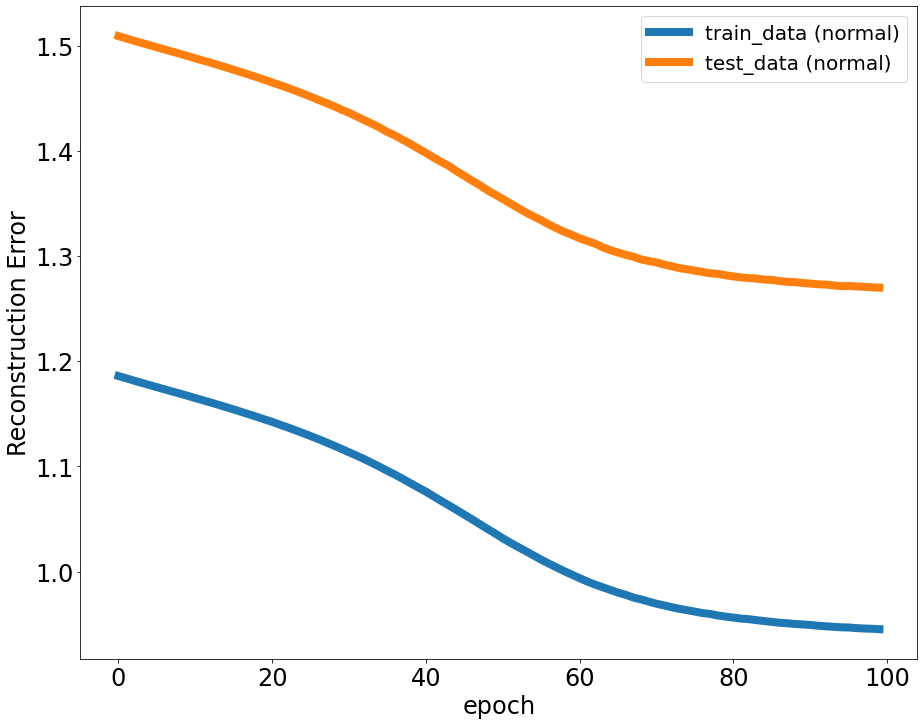

In [27]:
# # loss plot validation data=normal data (subset of train data)
import matplotlib as mpl

mpl.rcParams['font.size'] = 24
plt.rcParams["figure.figsize"] = (15,12)
#plt.figure(figsize = (20, 12))
plt.plot(history.history['loss'],linewidth = 8)
plt.plot(history.history['val_loss'],linewidth = 8)
#plt.title('model loss',fontsize = 24)
plt.ylabel('Reconstruction Error',fontsize = 24)
plt.xlabel('epoch',fontsize = 24)
plt.legend(['train_data (normal)', 'test_data (normal)'], loc='best',fontsize = 20)
#plt.savefig("Losstestcvae2.png", dpi=200)
plt.show()

In [30]:
train_predict=cvae.predict([X_train_scaled,Y_train])
print(X_train_scaled - train_predict)

[[-0.04401338  0.20923967 -1.15331912 ...  0.33682351  0.01528113
   0.00259055]
 [-0.58378589 -0.66431811 -0.7054236  ... -0.95662933 -0.84604611
   0.01594413]
 [ 0.25398548  2.07775676  2.24145716 ...  0.74882968  0.64011893
   0.5726473 ]
 ...
 [-0.20329154  0.30153791  0.87477121 ... -1.18629176 -1.00920948
  -2.5583317 ]
 [-0.37391446  0.39644114 -1.03699923 ...  0.76672023  0.62107097
   0.54302892]
 [ 0.22209289  1.60367306  1.19206236 ... -0.31017007  0.31489399
  -0.35997564]]


In [31]:
jumppy = np.square(X_train_scaled-cvae.predict([X_train_scaled,Y_train], batch_size = m))
jumppy.shape

(158299, 20)

In [32]:
np.mean(jumppy,(0)).shape

(20,)

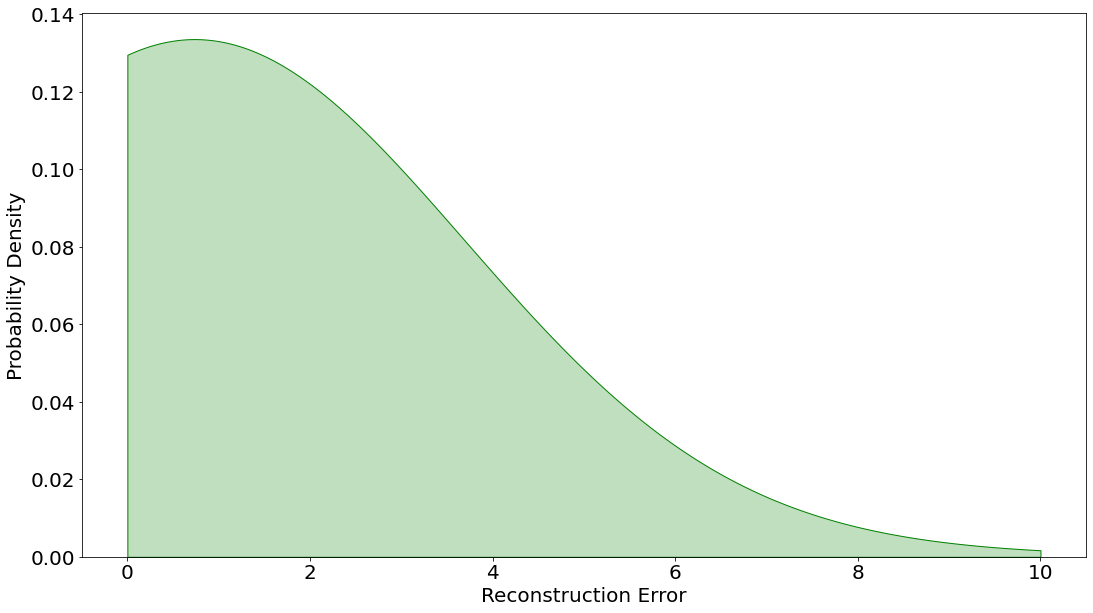

In [33]:
#####RE for the training dataset######

## Plotting the KDE Plot 
#Kernel Density Estimate is used for visualizing the Probability Density of a continuous variable. 
#It depicts the probability density at different values in a continuous variable
mpl.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"] = (18,10)
pred_train = generator.predict([x_train_encoded,Y_train])
mse = np.mean(np.power(X_train_scaled - pred_train, 2), axis=1)
error_df = pd.DataFrame({'recon_error': mse,'label': Y_train})
sns.kdeplot(error_df.recon_error[error_df.label==0], label='Train data (Normal)', shade=True, clip=(0,10), color='g')
plt.xlabel('Reconstruction Error')
plt.ylabel('Probability Density') 
plt.show()

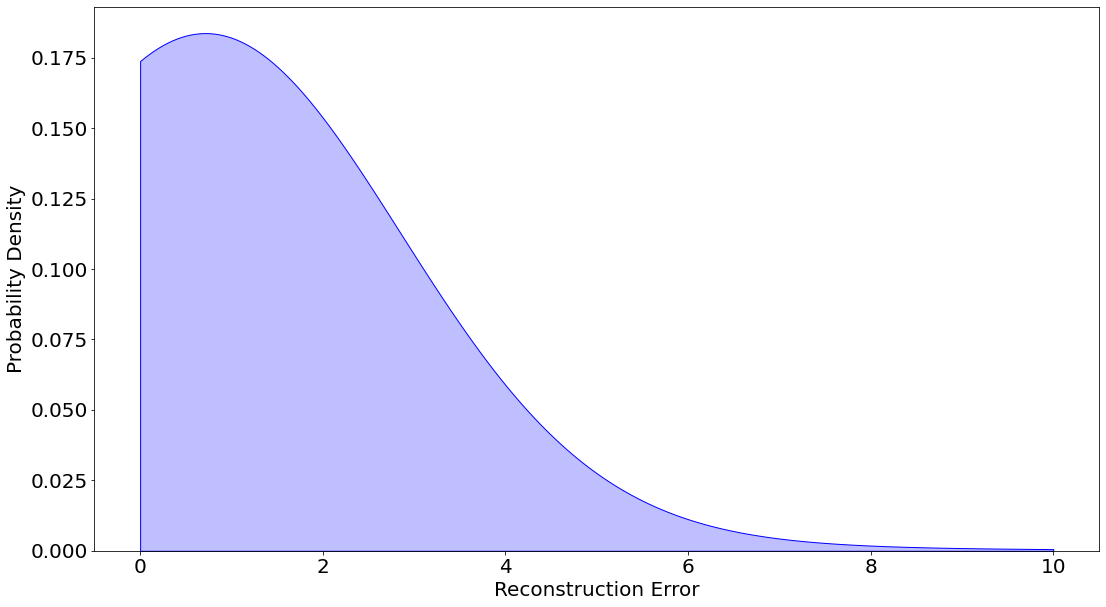

In [34]:
#####RE for the Test dataset (normal)##########
x_test_norm_encoded = encoder.predict([X_test,Y_test], batch_size=m)
mpl.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"] = (18,10)
pred_test_norm = generator.predict([x_test_norm_encoded,Y_test])
mse_test_norm = np.mean(np.power(X_test_scaled - pred_test_norm, 2), axis=1)
error_df1 = pd.DataFrame({'recon_error': mse_test_norm,'label': Y_test})
sns.kdeplot(error_df1.recon_error[error_df1.label==0], label='Test data (Normal)', shade=True, clip=(0,10),color='b')
plt.xlabel('Reconstruction Error')
plt.ylabel('Probability Density')
plt.show()

(3712305, 5)


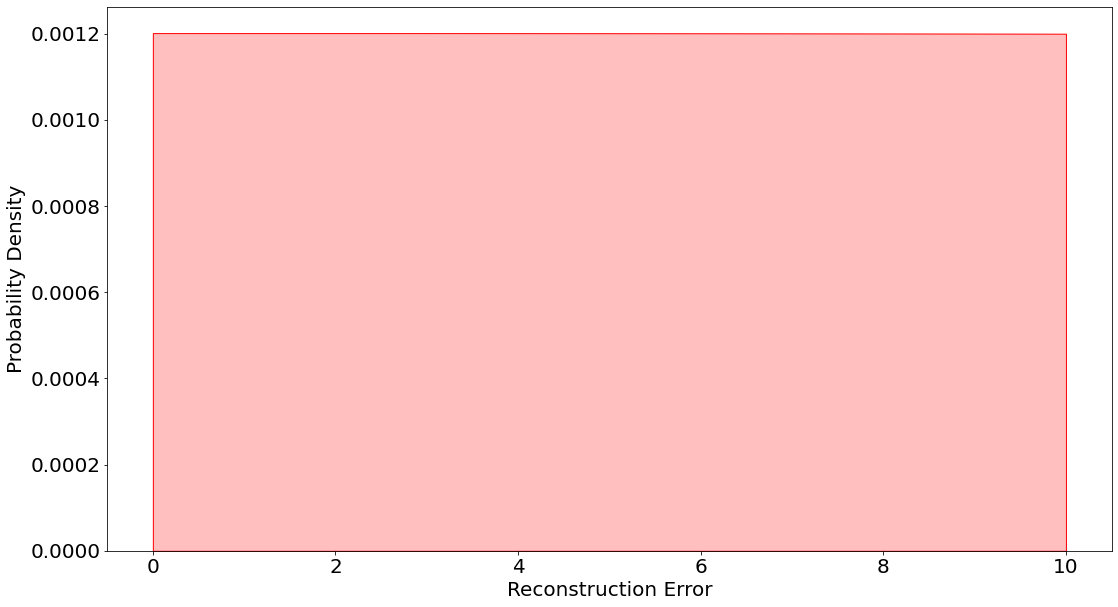

In [35]:
#####RE for Test dataset (attack)######
x_test_attack_encoded = encoder.predict([X_attack,Y_attack], batch_size=m)
print(x_test_attack_encoded.shape)
mpl.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"] = (18,10)
pred_test_attack = generator.predict([x_test_attack_encoded,Y_attack])
mse_test_attack = np.mean(np.power(X_attack_scaled - pred_test_attack, 2), axis=1)
error_df2 = pd.DataFrame({'recon_error': mse_test_attack,'label': Y_attack})
sns.kdeplot(error_df2.recon_error[error_df2.label==1], label='Test data (Attack)', shade=True, clip=(0,10),color='r')
plt.xlabel('Reconstruction Error')
plt.ylabel('Probability Density')
plt.show()

In [39]:
###detecting an anomaly based on RE. For test attack flows it must be high and for test benign flows it must be similar to train
import math
from sklearn import metrics
train_pred = cvae.predict([X_train_scaled, Y_train])
score1 = np.sqrt(metrics.mean_squared_error(train_pred,X_train_scaled))
test_pred = cvae.predict([X_test_scaled, Y_test])
score2 = np.sqrt(metrics.mean_squared_error(test_pred,X_test_scaled))
attack_pred =  cvae.predict([X_attack_scaled, Y_attack])
score3 = np.sqrt(metrics.mean_squared_error(attack_pred,X_attack_scaled))
print(f"Insample Normal Score (RMSE): {score1}")
print(f"Out of Sample Normal Score (RMSE): {score2}")
print(f"Attack Underway Score (RMSE): {score3}")

Insample Normal Score (RMSE): 1.0049201995215609
Out of Sample Normal Score (RMSE): 0.975598273363311
Attack Underway Score (RMSE): 52.656004790988014


In [43]:
#########How well does the predictor work (Metric analysis)###########

In [44]:
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [45]:
###merge error_df1 (normal_test) and error_df2 (attack_test) together
frames = [error_df1, error_df2]
test_error_df= pd.concat(frames)
print(test_error_df.shape)
test_error_df['label'].value_counts()

(3765072, 2)


1.0    3712305
0.0      52767
Name: label, dtype: int64

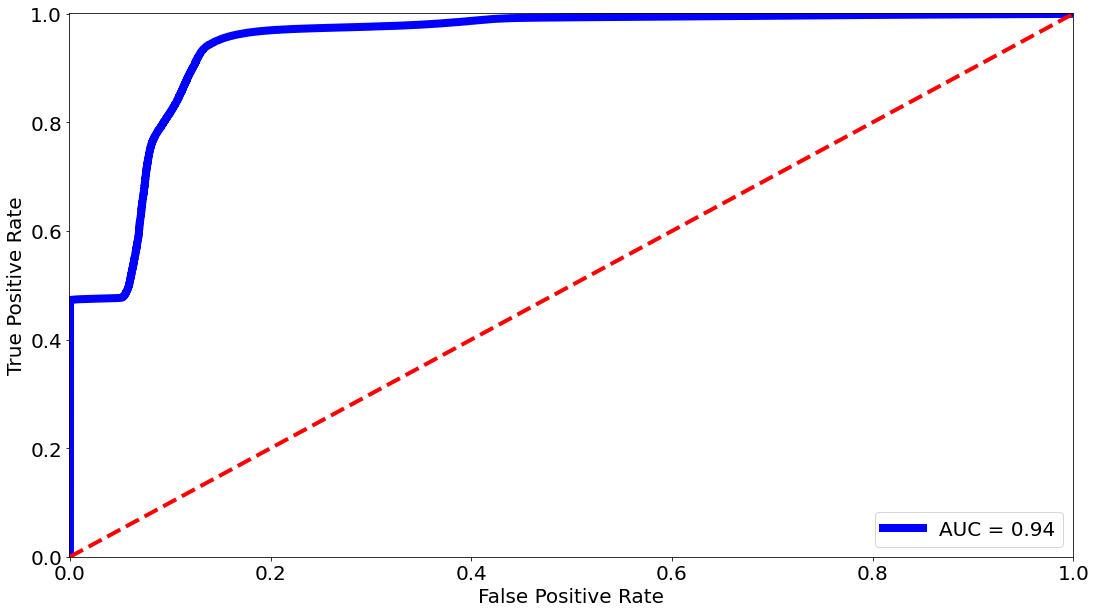

In [46]:
##########ROC GRAPH#######
#How well does our detector work?
fpr, tpr, thresholds = roc_curve(test_error_df.label, test_error_df.recon_error)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc,linewidth = 8, color='b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--',linewidth = 4)
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [212]:
#to predict whether or not an unseen transaction is normal or attack,calculate the RE from the data
#if RE> predefined threshold, mark as attack else normal
threshold = 1.28 ###based on RE between normal train and normal test flows

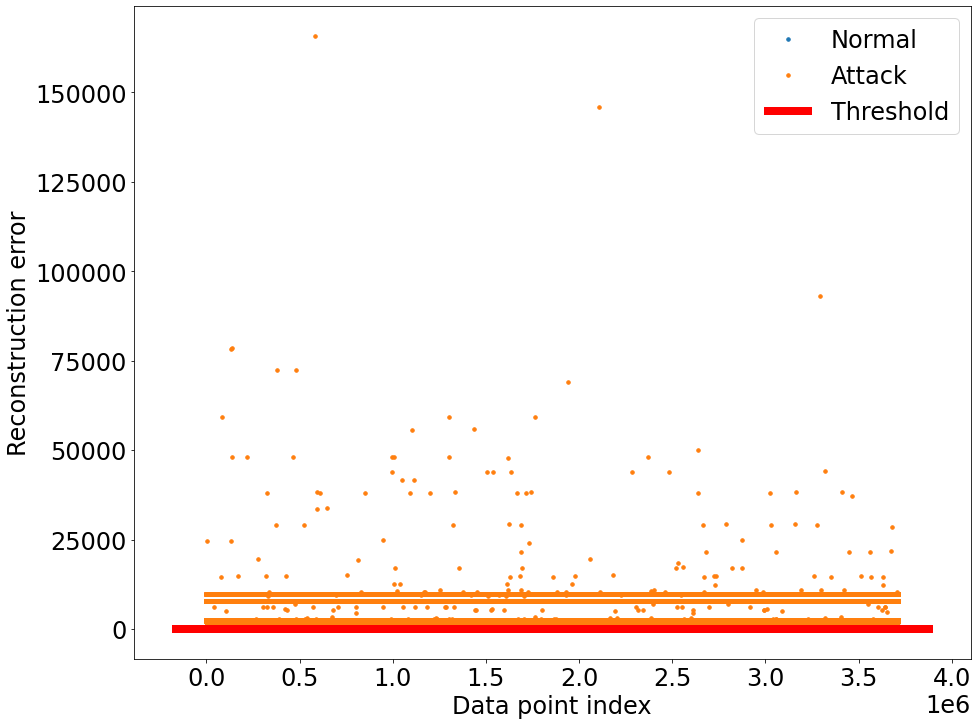

In [213]:
#####RE for different classes of data
group1 = test_error_df.groupby('label')
fig, ax = plt.subplots()
for name, group in group1:
    ax.plot(group.index, group.recon_error, marker='o', ms=3.5, linestyle='',label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold',linewidth = 8)
ax.legend()
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [49]:
##############CONFUSION MATRIX###########

In [214]:
# Compute confusion matrix for UNB test data (attack+normal)
from sklearn.metrics import classification_report
from sklearn.metrics import  confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit
target_classes = ["Normal", "Attack"]
y_pred = [1 if e > threshold else 0 for e in test_error_df.recon_error.values]
cm= confusion_matrix(test_error_df.label, y_pred)

print("Confusion matrix:")
print(cm)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]
print("\nTotal number of true positives", tp)
print("Total number of false negatives",fn)
print("Total number of false positives",fp)
print("Total number of true negatives",tn)

rp=tp+fn
rn=fp+tn
pp=tp+fp
pn=tn+fn

print("Real positives:",rp)
print("Real negatives:",rn)
print("Predicted positives:",pp)
print("Predicted negatives:",pn)

acc=float(tp+tn)/(tp+tn+fp+fn)
print('Classifier Accuracy: %.2f%%' % (acc * 100))

tpr = float(tp)/(tp+fn)
print('True Positive Rate (TPR/Recall/Sensitivity/Hit rate): %.2f%%' % (tpr * 100))

specificity = float (tn)/(tn+fp)
print ("True Negative Rate (TNR/Specificity/selectivity):%.2f%%" % (specificity*100)) 

bal_accuracy=float(tpr+specificity)/2
print("Balanced accuracy:%.2f%%" %(bal_accuracy*100))

o_error_rate= 1-bal_accuracy
print ( "Overall error rate (OER):%.2f%%" %(o_error_rate*100))

fpr = float(fp)/(fp+tn)
print("False Positive Rate (FPR)/Fall out: %.2f%%" % (fpr * 100))

fnr = fn/ (fn+ tp)
print("Evasion Success Rate (ESR/FNR/Miss Rate): %.2f%%" % (fnr*100))

precision=float(tp)/(tp+fp)
print("Total number of correct predictions(Precision/Positive Predictive value/PPV):%.2f%%" %(precision*100))

fScore = 2*((precision*tpr)/(precision+tpr))
print("F1-Score: %.2f%%" %(fScore*100))

npv = tn / (tn + fn)
print("Negative Predictive value (NPV):%.2f%%" %(npv*100))

fdr = fp/ (fp + tp)
print("False Discovery Rate (FDR):%.2f%%" %(fdr*100))

informedness= tpr + specificity -1
print("Informedness: %.2f" %(informedness))

markedness = precision + npv -1
print("Markedness:%.2f" %(markedness))

error_rate= 1-acc
print ( "Misclassification/ error rate:%.2f%%" %(error_rate*100))

Confusion matrix:
[[  46309    6458]
 [ 367730 3344575]]

Total number of true positives 3344575
Total number of false negatives 367730
Total number of false positives 6458
Total number of true negatives 46309
Real positives: 3712305
Real negatives: 52767
Predicted positives: 3351033
Predicted negatives: 414039
Classifier Accuracy: 90.06%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 90.09%
True Negative Rate (TNR/Specificity/selectivity):87.76%
Balanced accuracy:88.93%
Overall error rate (OER):11.07%
False Positive Rate (FPR)/Fall out: 12.24%
Evasion Success Rate (ESR/FNR/Miss Rate): 9.91%
Total number of correct predictions(Precision/Positive Predictive value/PPV):99.81%
F1-Score: 94.70%
Negative Predictive value (NPV):11.18%
False Discovery Rate (FDR):0.19%
Informedness: 0.78
Markedness:0.11
Misclassification/ error rate:9.94%


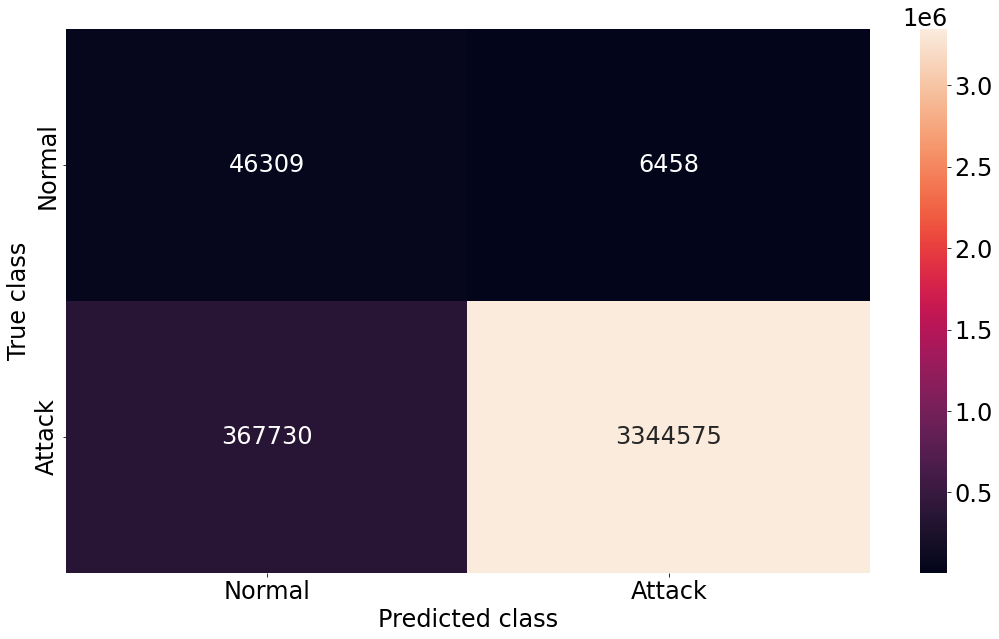

In [216]:
####CONFUSION MATRIX GRAPHICAL FORMAT####
target_classes = ["Normal", "Attack"]
y_pred = [1 if e > threshold else 0 for e in test_error_df.recon_error.values]
cm= confusion_matrix(test_error_df.label, y_pred)
plt.figure(figsize=(18, 10))
sns.heatmap(cm, xticklabels=target_classes, yticklabels=target_classes, annot=True, fmt="d");
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# EVALUATION ON ADVERSARIAL AND NON-AI ATYPICAL/POLYMORPHIC ATTACKS##############

In [217]:
def get_data(classname):
    commonpth1 = os.path.join(r'D:\DATA\Datasets\IoT2023_adv')
    commonpth2 = os.path.join(r'D:\DATA\Datasets\IoT2023_nonAI')
    
    print("Getting data for: " + classname)
    #####################################################DDoS ADVERSARIAL########################################
    AA1=pd.read_csv(commonpth1 + '\Adv_' + classname + 'PA1.csv')
    print("AA1:", AA1['label'].value_counts())

    data1 =AA1.values
    X1=data1[:,:-1] 
    Y1=data1[:,-1] 

    AA2=pd.read_csv(commonpth1 + '\Adv_' + classname + 'PA2.csv')
    print("AA2:", AA2['label'].value_counts())

    data2 =AA2.values
    X2=data2[:,:-1] 
    Y2=data2[:,-1]
    
    AA3=pd.read_csv(commonpth1 + '\Adv_' + classname + 'PA3.csv')
    print("AA3:", AA3['label'].value_counts())

    data3 =AA3.values
    X3=data3[:,:-1] 
    Y3=data3[:,-1]


    #######################################Non AI DDoS Attacks################################################
    benign_classname = classname
    if classname == 'DDoS':
        benign_classname = 'DDoS_HTTP'
    if classname == 'DoS':
        benign_classname = 'DoS_HTTP'
    if classname == 'Mirai':
        benign_classname = 'Mirai-greip'
        
    poly1=pd.read_csv(commonpth2 + '\\' + benign_classname + '_PA1.csv')
    print("poly1:", poly1['label'].value_counts())
    AA4=poly1.iloc[:, [0,1,3,7,8,9,11,14,15, 17,18,20,30,35,37,39,40,41,42,44,46]]

    data4 =AA4.values
    X4=data4[:,:-1] 
    Y4=data4[:,-1] 
  
    poly2=pd.read_csv(commonpth2 + '\\' + benign_classname + '_PA2.csv')
    print("poly2:", poly2['label'].value_counts())
    AA5=poly2.iloc[:, [0,1,3,7,8,9,11,14,15, 17,18,20,30,35,37,39,40,41,42,44,46]]

    data5 =AA5.values
    X5=data5[:,:-1] 
    Y5=data5[:,-1] 
    
    poly3=pd.read_csv(commonpth2 + '\\' + benign_classname + '_PA3.csv')
    print("poly3:", poly3['label'].value_counts())
    AA6=poly3.iloc[:, [0,1,3,7,8,9,11,14,15, 17,18,20,30,35,37,39,40,41,42,44,46]]

    data6 =AA6.values
    X6=data6[:,:-1] 
    Y6=data6[:,-1] 
    
    return X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,X6,Y6



In [218]:
def add_normal_trfm(X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,X6,Y6):

    ########concatenate X and Y data including both normal and synth attack data to generate synth_test data1
    ix = randint(0, X_norm.shape[0], X1.shape[0])
    X1_tst = np.concatenate([X_norm[ix], X1])
    Y1_tst= np.concatenate([Y_norm[ix], Y1])
    print(X1_tst.shape)
    print(Y1_tst.shape)


    ########concatenate X and Y data including both normal and synth attack data to generate synth_test data2
    ix = randint(0, X_norm.shape[0], X2.shape[0])
    X2_tst = np.concatenate([X_norm[ix], X2])
    Y2_tst= np.concatenate([Y_norm[ix], Y2])
    print(X2_tst.shape)
    print(Y2_tst.shape)

    ########concatenate X and Y data including both normal and synth attack data to generate synth_test data3
    ix = randint(0, X_norm.shape[0], X3.shape[0])
    X3_tst = np.concatenate([X_norm[ix], X3])
    Y3_tst= np.concatenate([Y_norm[ix], Y3])
    print(X3_tst.shape)
    print(Y3_tst.shape)
    

    ix = randint(0, X_norm.shape[0], X4.shape[0])
    X4_tst = np.concatenate([X_norm[ix], X4])
    Y4_tst= np.concatenate([Y_norm[ix], Y4])
    print(X4_tst.shape)
    print(Y4_tst.shape)

    ix = randint(0, X_norm.shape[0], X5.shape[0])
    X5_tst = np.concatenate([X_norm[ix], X5])
    Y5_tst= np.concatenate([Y_norm[ix], Y5])
    print(X5_tst.shape)
    print(Y5_tst.shape)

    ix = randint(0, X_norm.shape[0], X6.shape[0])
    X6_tst = np.concatenate([X_norm[ix], X6])
    Y6_tst= np.concatenate([Y_norm[ix], Y6])
    print(X6_tst.shape)
    print(Y6_tst.shape)
    
    ####load the saved scalar#####
    scaler = joblib.load('ss.pkl')
    X1_trfm=scaler.transform(X1_tst)
    X2_trfm=scaler.transform(X2_tst)
    X3_trfm=scaler.transform(X3_tst)
    X4_trfm=scaler.transform(X4_tst)
    X5_trfm=scaler.transform(X5_tst)
    X6_trfm=scaler.transform(X6_tst)
    
    return X1_trfm, X2_trfm, X3_trfm, X4_trfm, X5_trfm, X6_trfm, Y1_tst, Y2_tst, Y3_tst, Y4_tst, Y5_tst, Y6_tst

In [219]:
# make predictions for test data
threshold_new=1.28

def eval_metrics(features, labels):   
    # make predictions for test data
    Y_pred = cvae.predict([features, labels])
    mse = np.mean(np.power(features - Y_pred, 2), axis=1)
    error = pd.DataFrame({'recon_error': mse,'label': labels})
    
    target_classes = ["Normal", "Attack"]
    Y_pred = [1 if e > threshold_new else 0 for e in error.recon_error.values]
    cm= confusion_matrix(error.label, Y_pred)
    
    print("Confusion matrix:\n")
    print(cm)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    print("\nTotal number of true positives(Attack identified as Attack))", tp)
    print("Total number of false negatives (Attack identified as Benign)",fn)
    print("Total number of false positives(Benign identified as Attack)",fp)
    print("Total number of true negatives (Benign identified as Benign)",tn)

    rp=tp+fn
    rn=fp+tn
    pp=tp+fp
    pn=tn+fn

    print("Real positives:",rp)
    print("Real negatives:",rn)
    print("Predicted positives:",pp)
    print("Predicted negatives:",pn,"\n")
    
    acc=float(tp+tn)/(tp+tn+fp+fn)
    acc_csv.append(acc)
    print('Classifier Accuracy: %.2f%%' % (acc * 100))

    tpr = float(tp)/(tp+fn)
    tpr_csv.append(tpr)
    print('True Positive Rate (TPR/Recall/Sensitivity/Hit rate): %.2f%%' % (tpr * 100))

    specificity = float (tn)/(tn+fp)
    tnr_csv.append(specificity)
    print ("True Negative Rate (TNR/Specificity/selectivity):%.2f%%" % (specificity*100)) 

    bal_accuracy=float(tpr+specificity)/2
    bal_accu_csv.append(bal_accuracy)
    print("Balanced accuracy:%.2f%%" %(bal_accuracy*100))
    
    o_error_rate= 1-bal_accuracy
    o_error_csv.append(o_error_rate)
    print ( "Overall error rate (OER):%.2f%%" %(o_error_rate*100))

    fpr = float(fp)/(fp+tn)
    fpr_csv.append(fpr)
    print("False Positive Rate (FPR)/Fall out: %.2f%%" % (fpr * 100))

    fnr = fn/ (fn+ tp)
    fnr_csv.append(fnr)
    print("Evasion Success Rate (ESR/FNR/Miss Rate): %.2f%%" % (fnr*100))

    precision=float(tp)/(tp+fp)
    prec_csv.append(precision)
    print("Total number of correct predictions(Precision/Positive Predictive value/PPV):%.2f%%" %(precision*100))

    fScore = 2*((precision*tpr)/(precision+tpr))
    f1_csv.append(fScore)
    print("F1-Score: %.2f%%" %(fScore*100))

    npv = tn / (tn + fn)
    npv_csv.append(npv)
    print("Negative Predictive value (NPV):%.2f%%" %(npv*100))

    fdr = fp/ (fp + tp)
    fdr_csv.append(fdr)
    print("False Discovery Rate (FDR):%.2f%%" %(fdr*100))

    informedness= tpr + specificity -1
    inform_csv.append(informedness)
    print("Informedness: %.2f" %(informedness))

    markedness = precision + npv -1
    mark_csv.append(markedness)
    print("Markedness:%.2f" %(markedness))

    error_rate= 1-acc
    error_csv.append(error_rate)
    print ( "Misclassification/ error rate:%.2f%%" %(error_rate*100))
    
    plot_tpr(Y_pred, error.label)

    
    
    ###########average TPR Depiction###########
def plot_tpr(prediction, labels):
    denominator = 0
    average_tpr = list()
    numerator = 0
    Increment = False

    for idx, j in enumerate(prediction): ## enumerate through the predictions
        if j == 1: ### j is the prediction
            #TRUE POSITIVE CASE
            if j == labels[idx]: ## comparing 1 (attack prediction) with actual label
                numerator += 1
                denominator += 1
                Increment = True
        else:
            #FALSE NEGATIVE CASE
            if j !=labels[idx]:  ## comparing 0 (benign prediction) with actual label
                denominator += 1
                Increment = True
        if(Increment):
            average_tpr.append(numerator/denominator)
        Increment = False



    #####Plot average TPR based on attack flows##################
    %matplotlib inline
    %pylab inline
    mpl.rcParams['font.size'] = 24
    plt.rcParams["figure.figsize"] = (15,12) 
    plt.plot(numpy.array(average_tpr), label='TPR',linewidth = 4, color="dodgerblue")
    plt.xlabel("\n Attack Flows\n")
    plt.ylabel("\nTrue Positive Rate (TPR)")
    plt.ylim(0, 1)
    plt.fill_between((range(len(average_tpr))), average_tpr, color="lightblue")
    plt.show()



In [220]:
def print_results():
    counter = 0
    for i in range(len(tpr_csv)):
        if counter % 6 == 0:
            print("CVAE Results", "\n")
        print("TPR: %.2f%%, TNR: %.2f%%, BA: %.2f%%, pID: %.2f , ESR: %.2f%%, OER: %.2f%%, Precision: %.2f%%, F1-score: %.2f%%, Markedness: %.2f" % (tpr_csv[i] * 100, tnr_csv[i] * 100,bal_accu_csv[i] * 100,inform_csv[i], fnr_csv[i] * 100, o_error_csv[i] * 100, prec_csv[i] * 100,f1_csv[i] * 100, mark_csv[i]))

        counter += 1

In [221]:

def save_2_csv(classname):
########################Creating a CSV File#################

    another_counter = 0
    with open('CVAE_PA_res' + classname +'.csv', mode='w', newline='') as data_file:
        data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_NONE)
        data_writer.writerow(['Attack', 'TPR', 'TNR','Bal_Accuracy','Proficiency','ESR','OER',"FPR",'Precision','F1_Score', 'Markedness', "Accuracy","NPV", "FDR"])
        for i in range(len(tpr_csv)):
            if i % 6 == 0 and i != 0:

                another_counter=1
            else:
                another_counter+=1
            data_writer.writerow(["PA" + str(another_counter), '%.2f' % (tpr_csv[i] * 100), '%.2f' % (tnr_csv[i] * 100), '%.2f' % (bal_accu_csv[i] * 100), '%.2f' % inform_csv[i],'%.2f' % (fnr_csv[i] * 100), '%.2f' % (o_error_csv[i] * 100),'%.2f' % (fpr_csv[i] * 100), '%.2f'% (prec_csv[i] * 100),'%.2f' %  (f1_csv[i] * 100), '%.2f' % mark_csv[i], '%.2f' % (acc_csv[i] * 100),'%.2f' % (npv_csv[i] * 100),'%.2f' % (fdr_csv[i] * 100)]) 

In [222]:
def output_graphs(datasets, labelo, isAdvers, classname):
    colors = ['b', 'g', 'r']

    mpl.rcParams['font.size'] = 24
    plt.rcParams["figure.figsize"] = (15,12)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--',linewidth = 4)

    for i, data in enumerate(datasets):   
        Y_pred = cvae.predict([data, labelo[i]])
        mse = np.mean(np.power(data - Y_pred, 2), axis=1)
        error = pd.DataFrame({'recon_error': mse,'label': labelo[i]})
        fpr, tpr, threshold_new = roc_curve(error.label, error.recon_error)
        roc_auc = auc(fpr, tpr)
        graph_name = 'Adv_'+ classname +'_PA' if isAdvers else 'Non-AI_'+ classname +'_PA'
        plt.plot(fpr, tpr, label= graph_name + str(i + 1) + '(AUC= %0.2f)' % roc_auc, linewidth = 8, color = colors[i])

    plt.legend(prop={'size':24},loc='lower right')

    plt.xlabel('False positive rate', fontsize = 24)
    plt.ylabel('True positive rate', fontsize = 24)
    plt.show()


Getting data for: Brute
AA1: 1.0    1013
Name: label, dtype: int64
AA2: 1.0    1260
Name: label, dtype: int64
AA3: 1.0    1112
Name: label, dtype: int64
poly1: 1    1013
Name: label, dtype: int64
poly2: 1    1260
Name: label, dtype: int64
poly3: 1    1112
Name: label, dtype: int64
(2026, 20)
(2026,)
(2520, 20)
(2520,)
(2224, 20)
(2224,)
(2026, 20)
(2026,)
(2520, 20)
(2520,)
(2224, 20)
(2224,)

 Results for: Brute

################[1] Adver AA1##########################

Confusion matrix:

[[883 130]
 [922  91]]

Total number of true positives(Attack identified as Attack)) 91
Total number of false negatives (Attack identified as Benign) 922
Total number of false positives(Benign identified as Attack) 130
Total number of true negatives (Benign identified as Benign) 883
Real positives: 1013
Real negatives: 1013
Predicted positives: 221
Predicted negatives: 1805 

Classifier Accuracy: 48.08%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 8.98%
True Negative Rate (TNR/Specificity/sel

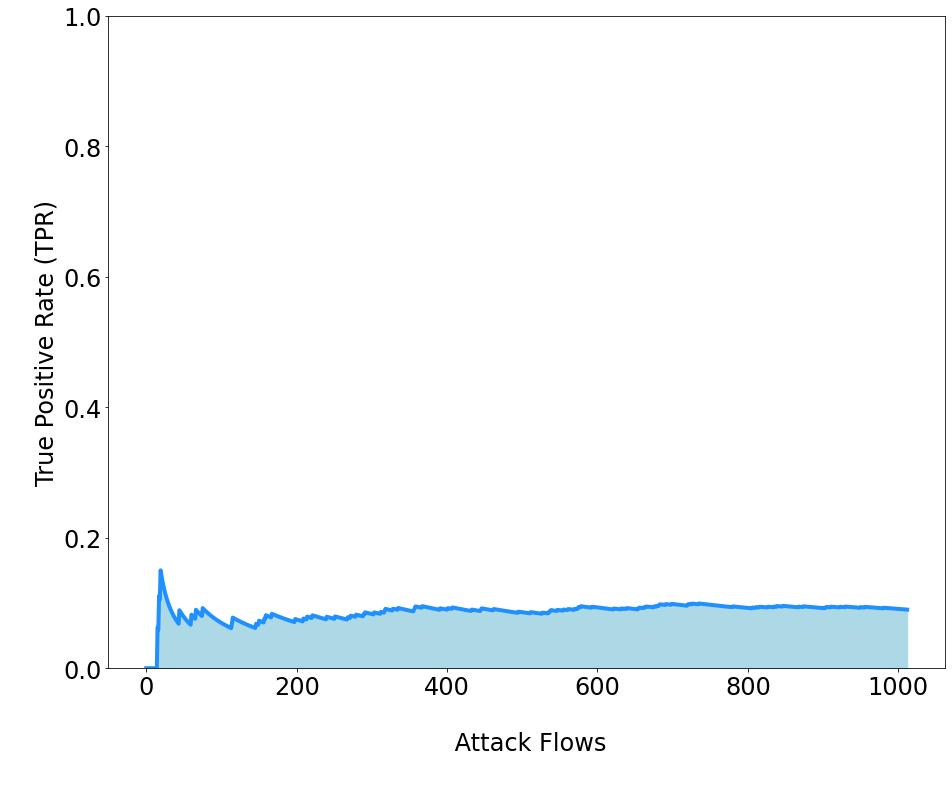


################[2] Adver AA2##########################

Confusion matrix:

[[1132  128]
 [ 779  481]]

Total number of true positives(Attack identified as Attack)) 481
Total number of false negatives (Attack identified as Benign) 779
Total number of false positives(Benign identified as Attack) 128
Total number of true negatives (Benign identified as Benign) 1132
Real positives: 1260
Real negatives: 1260
Predicted positives: 609
Predicted negatives: 1911 

Classifier Accuracy: 64.01%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 38.17%
True Negative Rate (TNR/Specificity/selectivity):89.84%
Balanced accuracy:64.01%
Overall error rate (OER):35.99%
False Positive Rate (FPR)/Fall out: 10.16%
Evasion Success Rate (ESR/FNR/Miss Rate): 61.83%
Total number of correct predictions(Precision/Positive Predictive value/PPV):78.98%
F1-Score: 51.47%
Negative Predictive value (NPV):59.24%
False Discovery Rate (FDR):21.02%
Informedness: 0.28
Markedness:0.38
Misclassification/ error rate:35.99

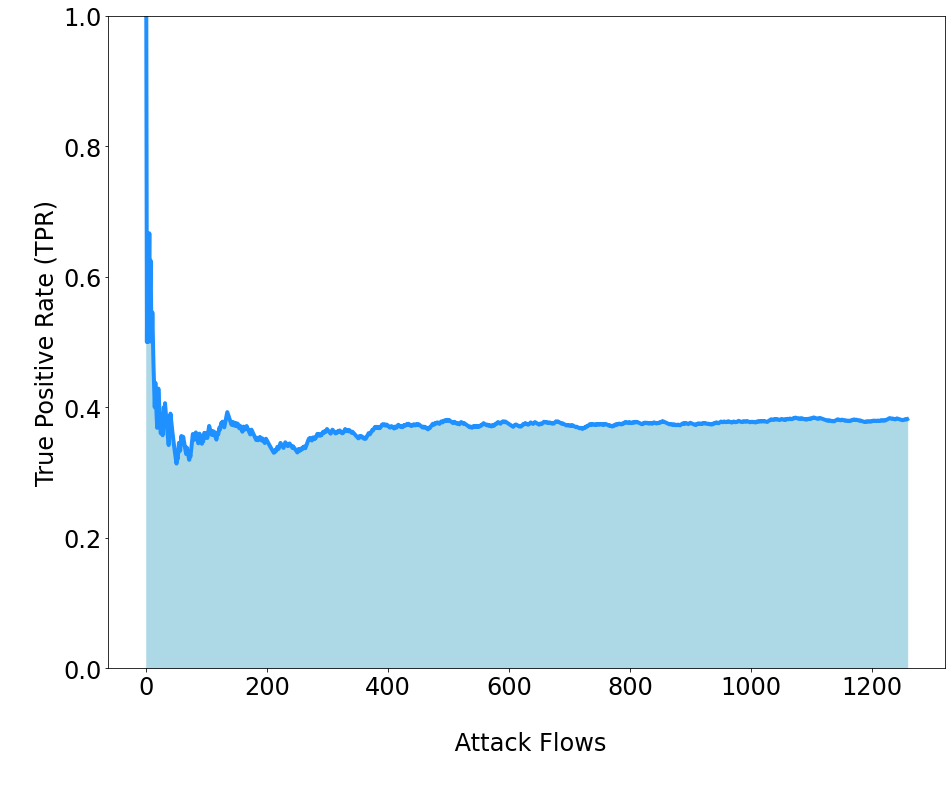


################[3] Adver AA3##########################

Confusion matrix:

[[ 970  142]
 [1015   97]]

Total number of true positives(Attack identified as Attack)) 97
Total number of false negatives (Attack identified as Benign) 1015
Total number of false positives(Benign identified as Attack) 142
Total number of true negatives (Benign identified as Benign) 970
Real positives: 1112
Real negatives: 1112
Predicted positives: 239
Predicted negatives: 1985 

Classifier Accuracy: 47.98%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 8.72%
True Negative Rate (TNR/Specificity/selectivity):87.23%
Balanced accuracy:47.98%
Overall error rate (OER):52.02%
False Positive Rate (FPR)/Fall out: 12.77%
Evasion Success Rate (ESR/FNR/Miss Rate): 91.28%
Total number of correct predictions(Precision/Positive Predictive value/PPV):40.59%
F1-Score: 14.36%
Negative Predictive value (NPV):48.87%
False Discovery Rate (FDR):59.41%
Informedness: -0.04
Markedness:-0.11
Misclassification/ error rate:52.02

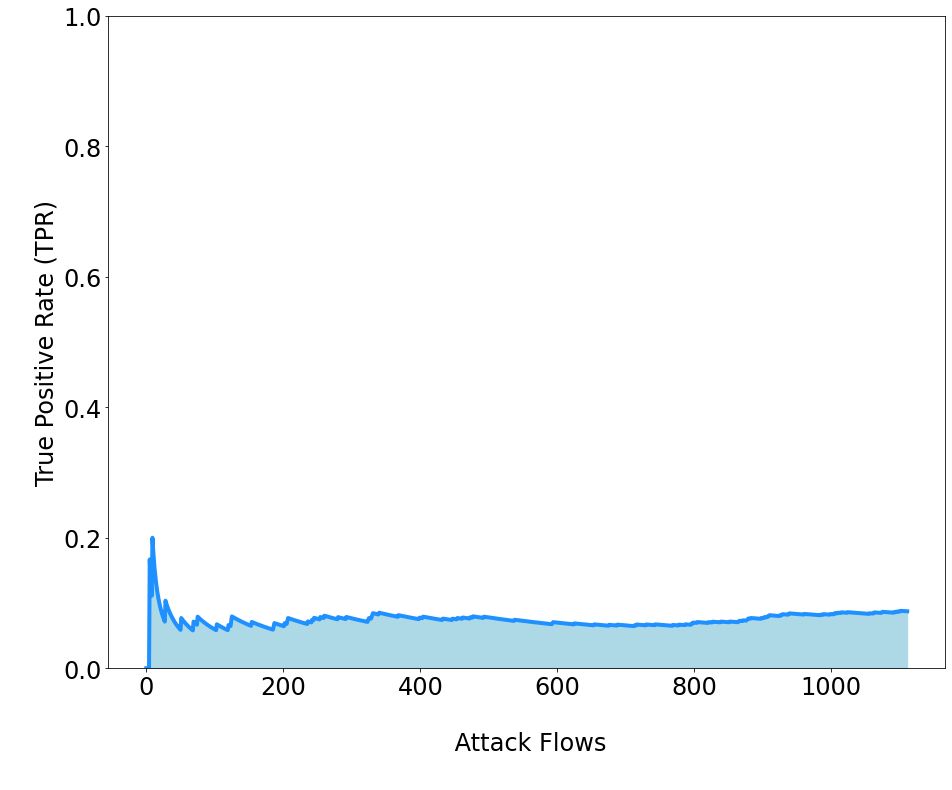


################[4] NonAI AA1##########################

Confusion matrix:

[[892 121]
 [791 222]]

Total number of true positives(Attack identified as Attack)) 222
Total number of false negatives (Attack identified as Benign) 791
Total number of false positives(Benign identified as Attack) 121
Total number of true negatives (Benign identified as Benign) 892
Real positives: 1013
Real negatives: 1013
Predicted positives: 343
Predicted negatives: 1683 

Classifier Accuracy: 54.99%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 21.92%
True Negative Rate (TNR/Specificity/selectivity):88.06%
Balanced accuracy:54.99%
Overall error rate (OER):45.01%
False Positive Rate (FPR)/Fall out: 11.94%
Evasion Success Rate (ESR/FNR/Miss Rate): 78.08%
Total number of correct predictions(Precision/Positive Predictive value/PPV):64.72%
F1-Score: 32.74%
Negative Predictive value (NPV):53.00%
False Discovery Rate (FDR):35.28%
Informedness: 0.10
Markedness:0.18
Misclassification/ error rate:45.01%
Pop

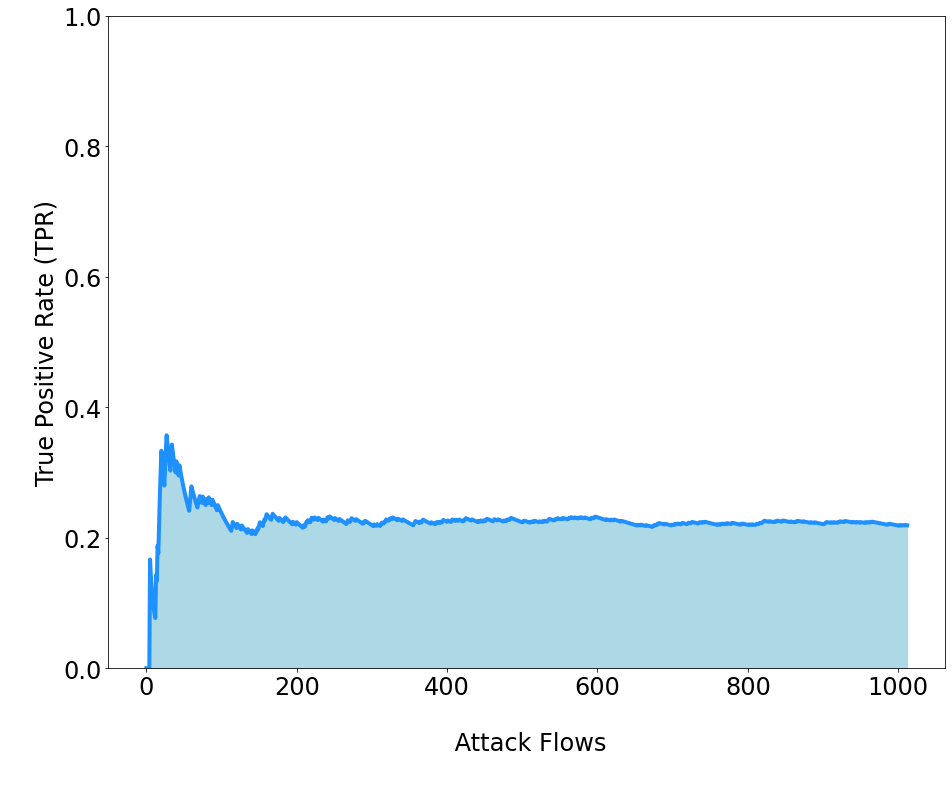


################[5] NonAI AA2##########################

Confusion matrix:

[[1115  145]
 [ 975  285]]

Total number of true positives(Attack identified as Attack)) 285
Total number of false negatives (Attack identified as Benign) 975
Total number of false positives(Benign identified as Attack) 145
Total number of true negatives (Benign identified as Benign) 1115
Real positives: 1260
Real negatives: 1260
Predicted positives: 430
Predicted negatives: 2090 

Classifier Accuracy: 55.56%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 22.62%
True Negative Rate (TNR/Specificity/selectivity):88.49%
Balanced accuracy:55.56%
Overall error rate (OER):44.44%
False Positive Rate (FPR)/Fall out: 11.51%
Evasion Success Rate (ESR/FNR/Miss Rate): 77.38%
Total number of correct predictions(Precision/Positive Predictive value/PPV):66.28%
F1-Score: 33.73%
Negative Predictive value (NPV):53.35%
False Discovery Rate (FDR):33.72%
Informedness: 0.11
Markedness:0.20
Misclassification/ error rate:44.44

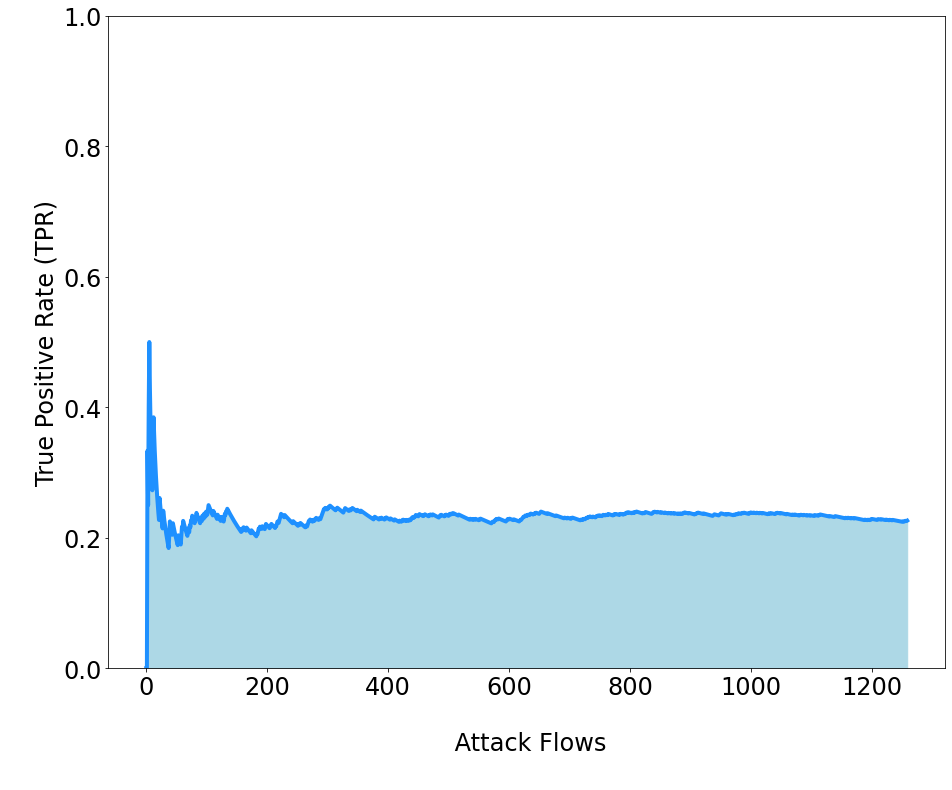


################[6] NonAI AA3##########################

Confusion matrix:

[[984 128]
 [881 231]]

Total number of true positives(Attack identified as Attack)) 231
Total number of false negatives (Attack identified as Benign) 881
Total number of false positives(Benign identified as Attack) 128
Total number of true negatives (Benign identified as Benign) 984
Real positives: 1112
Real negatives: 1112
Predicted positives: 359
Predicted negatives: 1865 

Classifier Accuracy: 54.63%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 20.77%
True Negative Rate (TNR/Specificity/selectivity):88.49%
Balanced accuracy:54.63%
Overall error rate (OER):45.37%
False Positive Rate (FPR)/Fall out: 11.51%
Evasion Success Rate (ESR/FNR/Miss Rate): 79.23%
Total number of correct predictions(Precision/Positive Predictive value/PPV):64.35%
F1-Score: 31.41%
Negative Predictive value (NPV):52.76%
False Discovery Rate (FDR):35.65%
Informedness: 0.09
Markedness:0.17
Misclassification/ error rate:45.37%
Pop

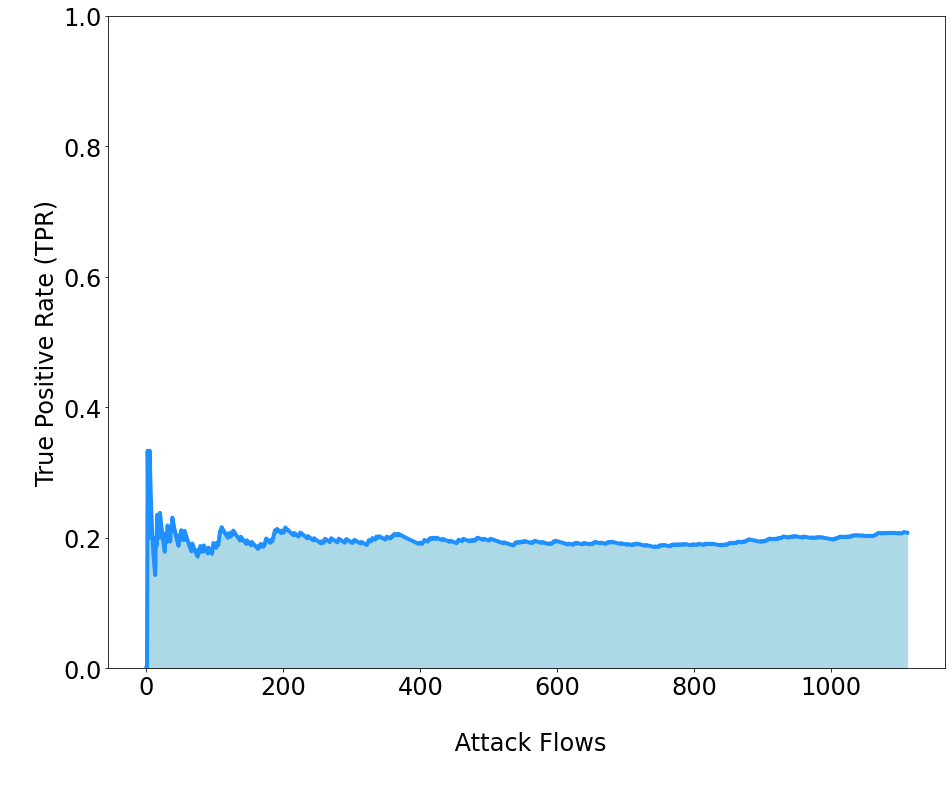

ID-CVAE Results 

TPR: 8.98%, TNR: 87.17%, BA: 48.08%, pID: -0.04 , ESR: 91.02%, OER: 51.92%, Precision: 41.18%, F1-score: 14.75%, Markedness: -0.10
TPR: 38.17%, TNR: 89.84%, BA: 64.01%, pID: 0.28 , ESR: 61.83%, OER: 35.99%, Precision: 78.98%, F1-score: 51.47%, Markedness: 0.38
TPR: 8.72%, TNR: 87.23%, BA: 47.98%, pID: -0.04 , ESR: 91.28%, OER: 52.02%, Precision: 40.59%, F1-score: 14.36%, Markedness: -0.11
TPR: 21.92%, TNR: 88.06%, BA: 54.99%, pID: 0.10 , ESR: 78.08%, OER: 45.01%, Precision: 64.72%, F1-score: 32.74%, Markedness: 0.18
TPR: 22.62%, TNR: 88.49%, BA: 55.56%, pID: 0.11 , ESR: 77.38%, OER: 44.44%, Precision: 66.28%, F1-score: 33.73%, Markedness: 0.20
TPR: 20.77%, TNR: 88.49%, BA: 54.63%, pID: 0.09 , ESR: 79.23%, OER: 45.37%, Precision: 64.35%, F1-score: 31.41%, Markedness: 0.17


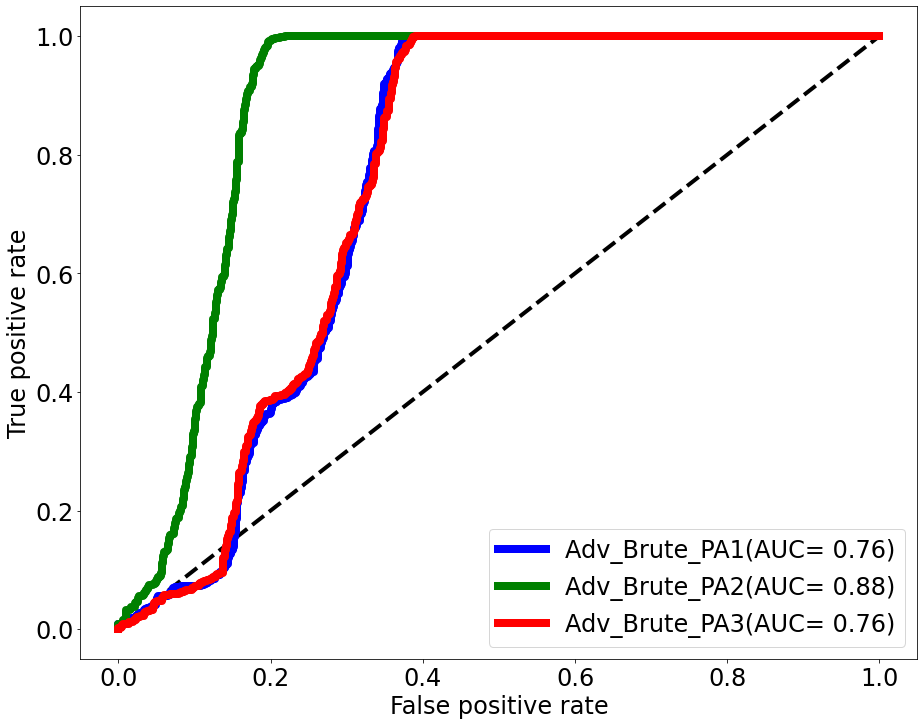

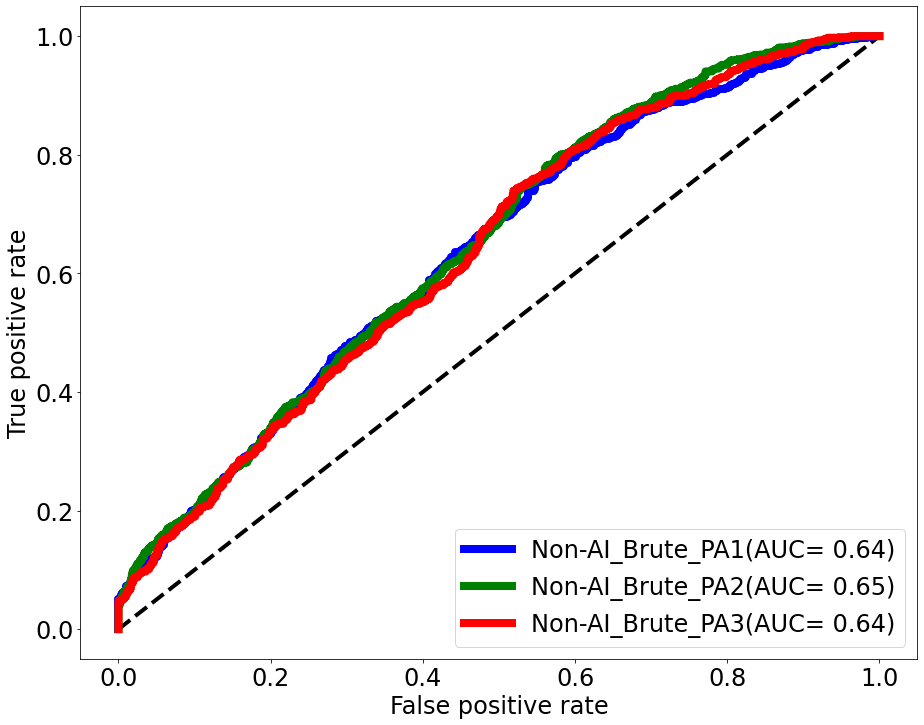

Getting data for: DDoS
AA1: 1.0    2280
Name: label, dtype: int64
AA2: 1.0    2697
Name: label, dtype: int64
AA3: 1.0    2471
Name: label, dtype: int64
poly1: 1    2280
Name: label, dtype: int64
poly2: 1    2697
Name: label, dtype: int64
poly3: 1    2471
Name: label, dtype: int64
(4560, 20)
(4560,)
(5394, 20)
(5394,)
(4942, 20)
(4942,)
(4560, 20)
(4560,)
(5394, 20)
(5394,)
(4942, 20)
(4942,)

 Results for: DDoS

################[1] Adver AA1##########################

Confusion matrix:

[[1991  289]
 [1265 1015]]

Total number of true positives(Attack identified as Attack)) 1015
Total number of false negatives (Attack identified as Benign) 1265
Total number of false positives(Benign identified as Attack) 289
Total number of true negatives (Benign identified as Benign) 1991
Real positives: 2280
Real negatives: 2280
Predicted positives: 1304
Predicted negatives: 3256 

Classifier Accuracy: 65.92%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 44.52%
True Negative Rate (TNR/Specifi

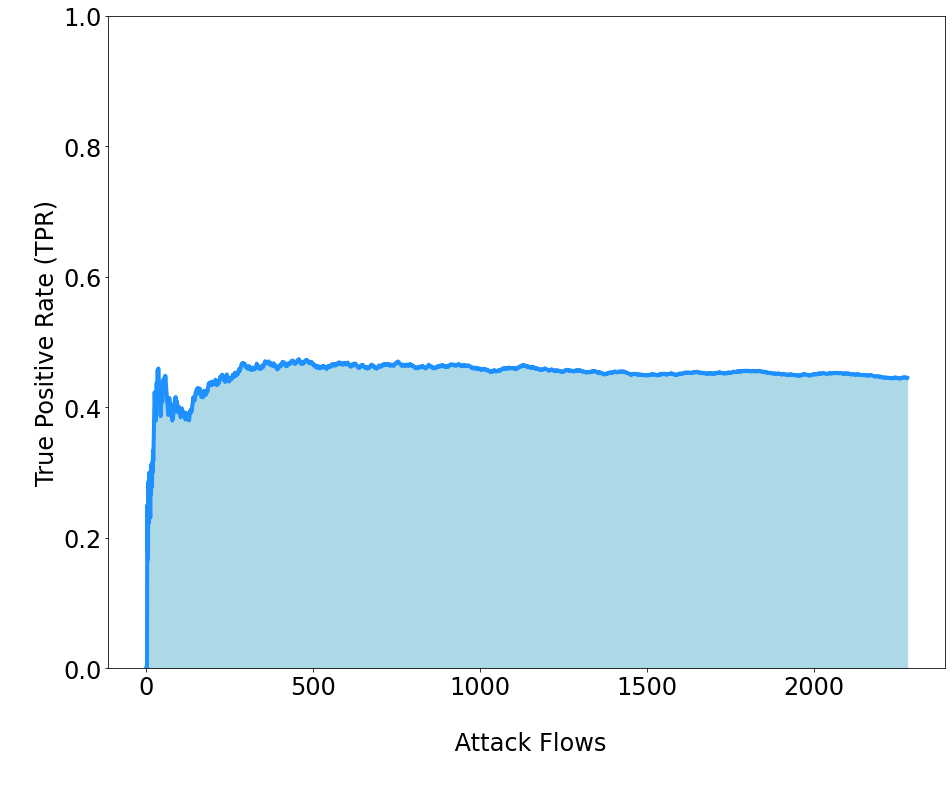


################[2] Adver AA2##########################

Confusion matrix:

[[2370  327]
 [1509 1188]]

Total number of true positives(Attack identified as Attack)) 1188
Total number of false negatives (Attack identified as Benign) 1509
Total number of false positives(Benign identified as Attack) 327
Total number of true negatives (Benign identified as Benign) 2370
Real positives: 2697
Real negatives: 2697
Predicted positives: 1515
Predicted negatives: 3879 

Classifier Accuracy: 65.96%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 44.05%
True Negative Rate (TNR/Specificity/selectivity):87.88%
Balanced accuracy:65.96%
Overall error rate (OER):34.04%
False Positive Rate (FPR)/Fall out: 12.12%
Evasion Success Rate (ESR/FNR/Miss Rate): 55.95%
Total number of correct predictions(Precision/Positive Predictive value/PPV):78.42%
F1-Score: 56.41%
Negative Predictive value (NPV):61.10%
False Discovery Rate (FDR):21.58%
Informedness: 0.32
Markedness:0.40
Misclassification/ error rate:34

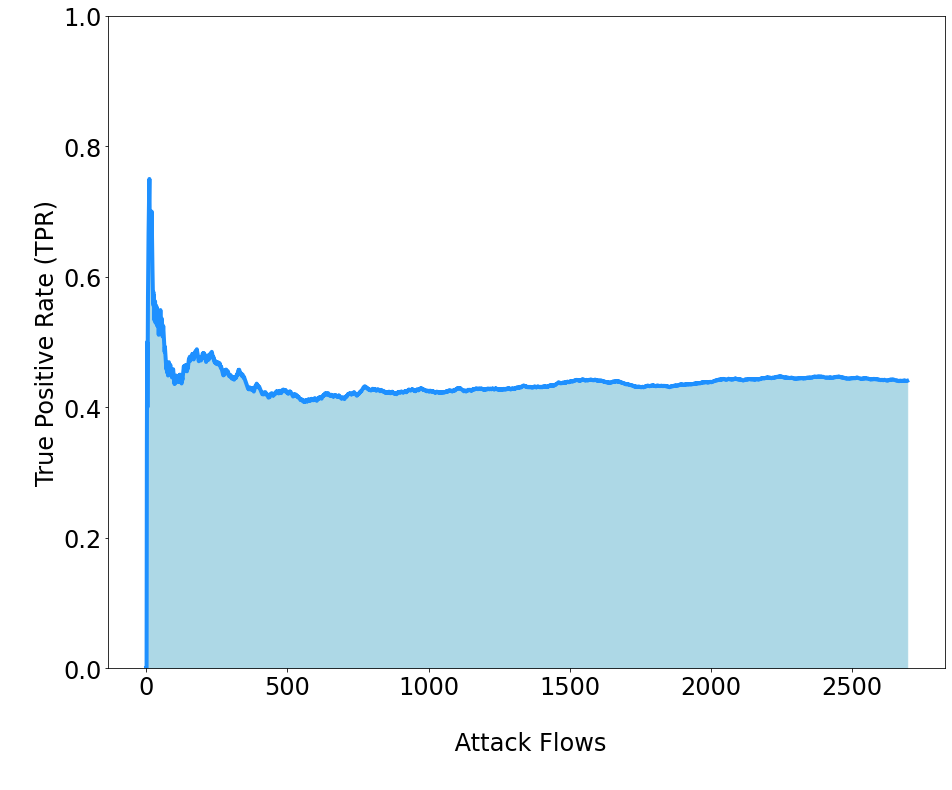


################[3] Adver AA3##########################

Confusion matrix:

[[2164  307]
 [1511  960]]

Total number of true positives(Attack identified as Attack)) 960
Total number of false negatives (Attack identified as Benign) 1511
Total number of false positives(Benign identified as Attack) 307
Total number of true negatives (Benign identified as Benign) 2164
Real positives: 2471
Real negatives: 2471
Predicted positives: 1267
Predicted negatives: 3675 

Classifier Accuracy: 63.21%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 38.85%
True Negative Rate (TNR/Specificity/selectivity):87.58%
Balanced accuracy:63.21%
Overall error rate (OER):36.79%
False Positive Rate (FPR)/Fall out: 12.42%
Evasion Success Rate (ESR/FNR/Miss Rate): 61.15%
Total number of correct predictions(Precision/Positive Predictive value/PPV):75.77%
F1-Score: 51.36%
Negative Predictive value (NPV):58.88%
False Discovery Rate (FDR):24.23%
Informedness: 0.26
Markedness:0.35
Misclassification/ error rate:36.

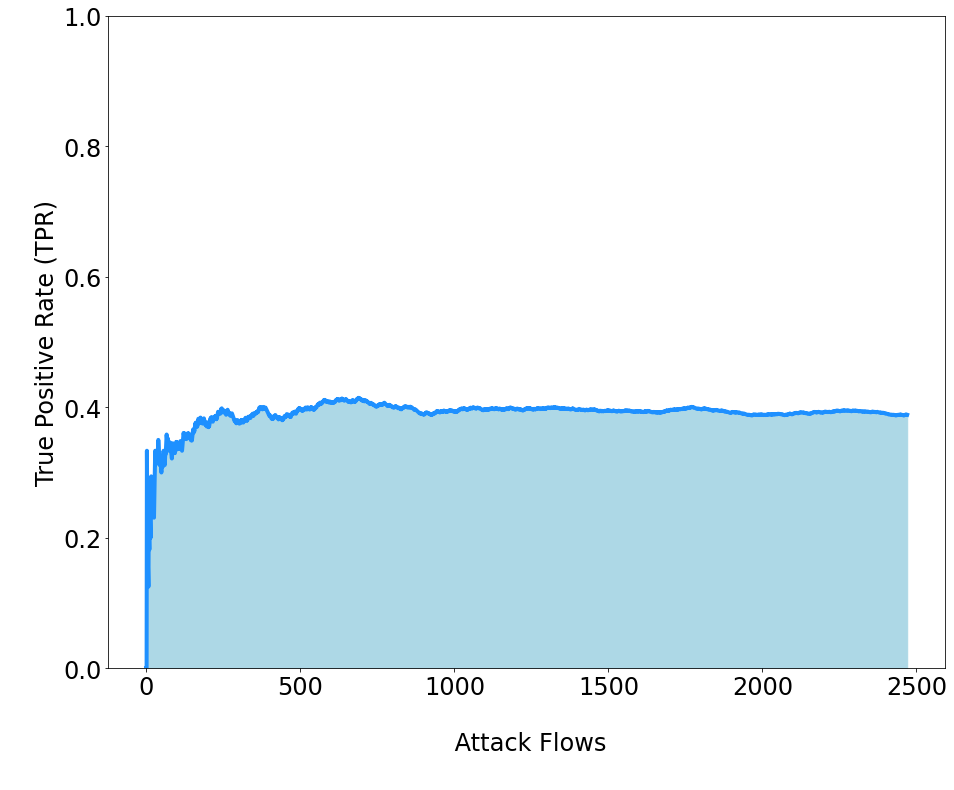


################[4] NonAI AA1##########################

Confusion matrix:

[[2011  269]
 [1604  676]]

Total number of true positives(Attack identified as Attack)) 676
Total number of false negatives (Attack identified as Benign) 1604
Total number of false positives(Benign identified as Attack) 269
Total number of true negatives (Benign identified as Benign) 2011
Real positives: 2280
Real negatives: 2280
Predicted positives: 945
Predicted negatives: 3615 

Classifier Accuracy: 58.93%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 29.65%
True Negative Rate (TNR/Specificity/selectivity):88.20%
Balanced accuracy:58.93%
Overall error rate (OER):41.07%
False Positive Rate (FPR)/Fall out: 11.80%
Evasion Success Rate (ESR/FNR/Miss Rate): 70.35%
Total number of correct predictions(Precision/Positive Predictive value/PPV):71.53%
F1-Score: 41.92%
Negative Predictive value (NPV):55.63%
False Discovery Rate (FDR):28.47%
Informedness: 0.18
Markedness:0.27
Misclassification/ error rate:41.0

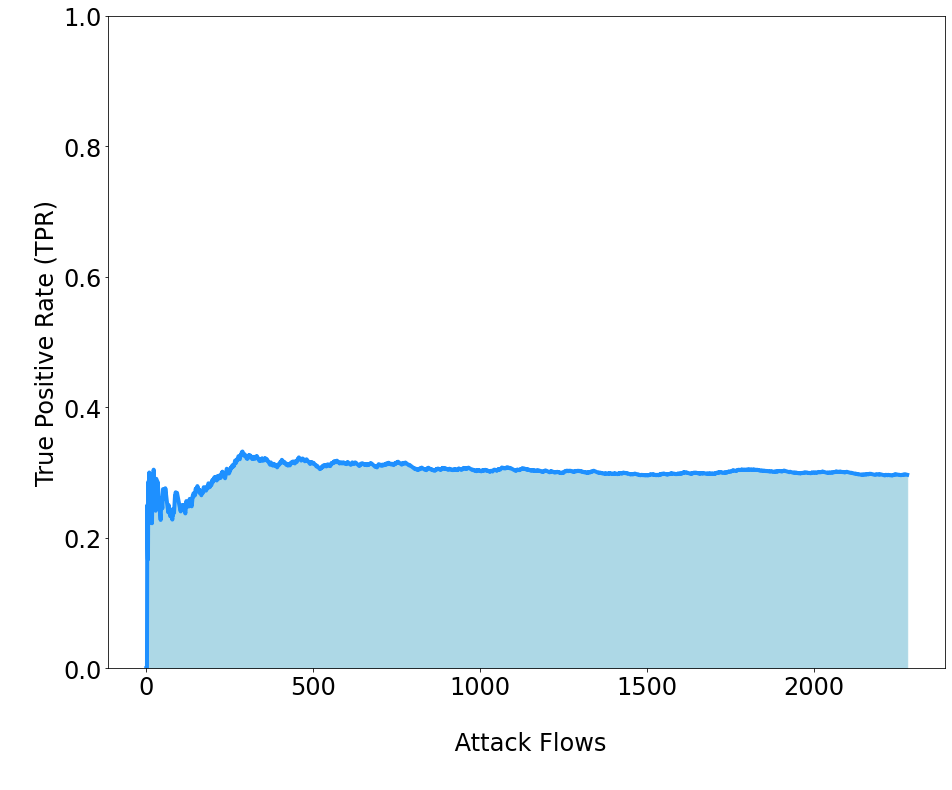


################[5] NonAI AA2##########################

Confusion matrix:

[[2354  343]
 [1883  814]]

Total number of true positives(Attack identified as Attack)) 814
Total number of false negatives (Attack identified as Benign) 1883
Total number of false positives(Benign identified as Attack) 343
Total number of true negatives (Benign identified as Benign) 2354
Real positives: 2697
Real negatives: 2697
Predicted positives: 1157
Predicted negatives: 4237 

Classifier Accuracy: 58.73%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 30.18%
True Negative Rate (TNR/Specificity/selectivity):87.28%
Balanced accuracy:58.73%
Overall error rate (OER):41.27%
False Positive Rate (FPR)/Fall out: 12.72%
Evasion Success Rate (ESR/FNR/Miss Rate): 69.82%
Total number of correct predictions(Precision/Positive Predictive value/PPV):70.35%
F1-Score: 42.24%
Negative Predictive value (NPV):55.56%
False Discovery Rate (FDR):29.65%
Informedness: 0.17
Markedness:0.26
Misclassification/ error rate:41.

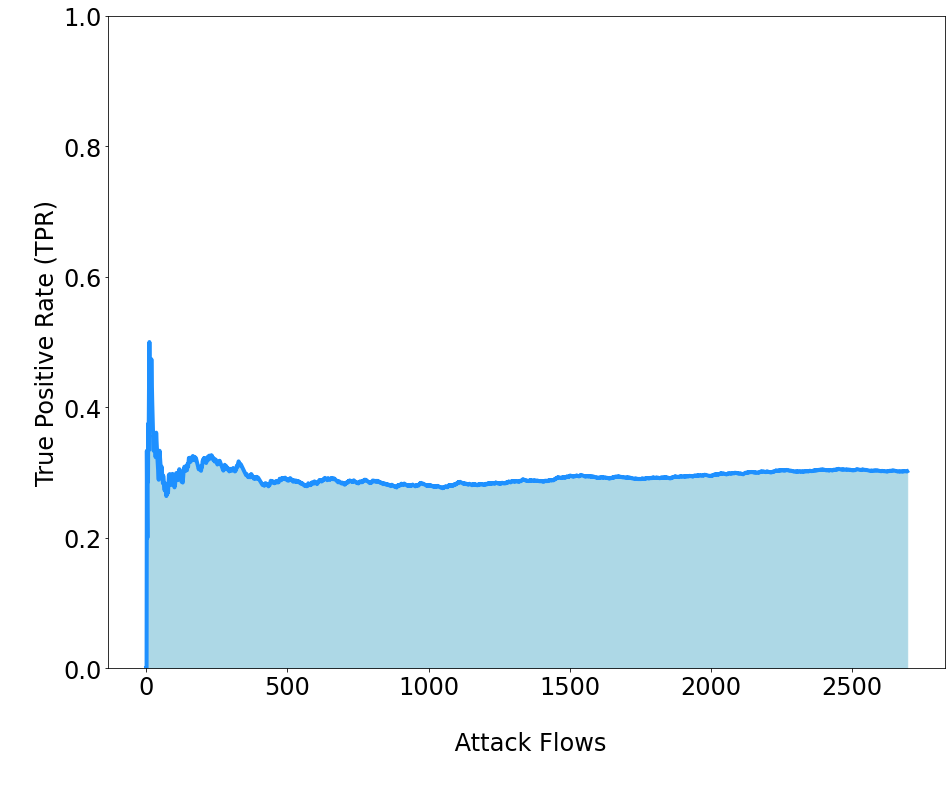


################[6] NonAI AA3##########################

Confusion matrix:

[[2191  280]
 [1754  717]]

Total number of true positives(Attack identified as Attack)) 717
Total number of false negatives (Attack identified as Benign) 1754
Total number of false positives(Benign identified as Attack) 280
Total number of true negatives (Benign identified as Benign) 2191
Real positives: 2471
Real negatives: 2471
Predicted positives: 997
Predicted negatives: 3945 

Classifier Accuracy: 58.84%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 29.02%
True Negative Rate (TNR/Specificity/selectivity):88.67%
Balanced accuracy:58.84%
Overall error rate (OER):41.16%
False Positive Rate (FPR)/Fall out: 11.33%
Evasion Success Rate (ESR/FNR/Miss Rate): 70.98%
Total number of correct predictions(Precision/Positive Predictive value/PPV):71.92%
F1-Score: 41.35%
Negative Predictive value (NPV):55.54%
False Discovery Rate (FDR):28.08%
Informedness: 0.18
Markedness:0.27
Misclassification/ error rate:41.1

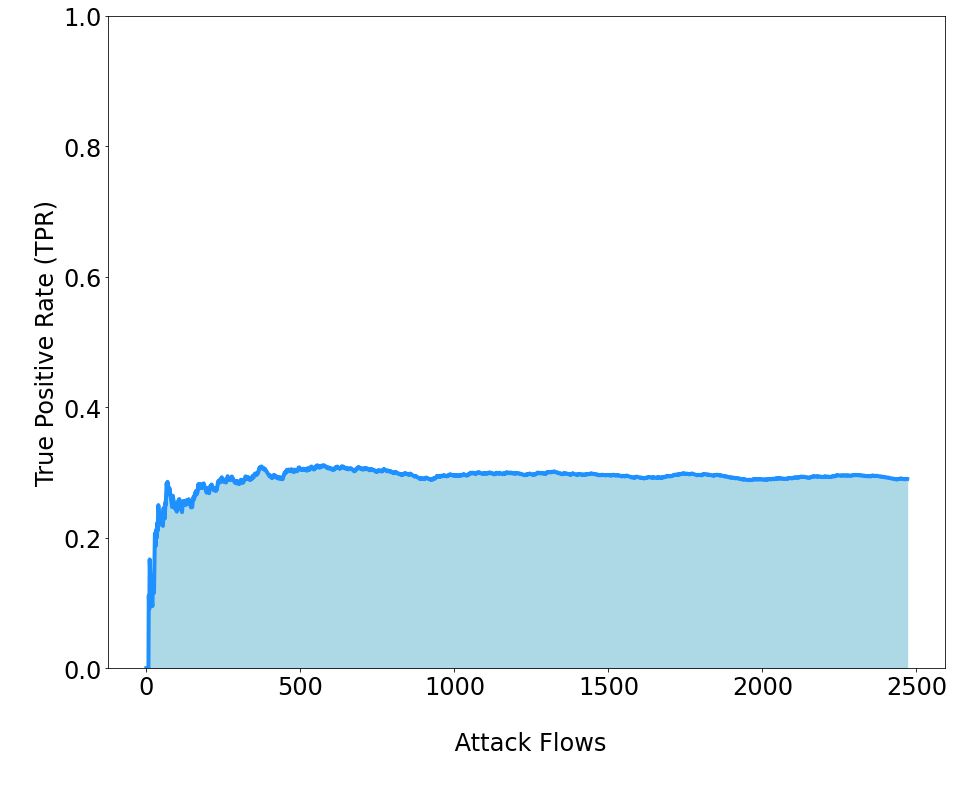

ID-CVAE Results 

TPR: 44.52%, TNR: 87.32%, BA: 65.92%, pID: 0.32 , ESR: 55.48%, OER: 34.08%, Precision: 77.84%, F1-score: 56.64%, Markedness: 0.39
TPR: 44.05%, TNR: 87.88%, BA: 65.96%, pID: 0.32 , ESR: 55.95%, OER: 34.04%, Precision: 78.42%, F1-score: 56.41%, Markedness: 0.40
TPR: 38.85%, TNR: 87.58%, BA: 63.21%, pID: 0.26 , ESR: 61.15%, OER: 36.79%, Precision: 75.77%, F1-score: 51.36%, Markedness: 0.35
TPR: 29.65%, TNR: 88.20%, BA: 58.93%, pID: 0.18 , ESR: 70.35%, OER: 41.07%, Precision: 71.53%, F1-score: 41.92%, Markedness: 0.27
TPR: 30.18%, TNR: 87.28%, BA: 58.73%, pID: 0.17 , ESR: 69.82%, OER: 41.27%, Precision: 70.35%, F1-score: 42.24%, Markedness: 0.26
TPR: 29.02%, TNR: 88.67%, BA: 58.84%, pID: 0.18 , ESR: 70.98%, OER: 41.16%, Precision: 71.92%, F1-score: 41.35%, Markedness: 0.27


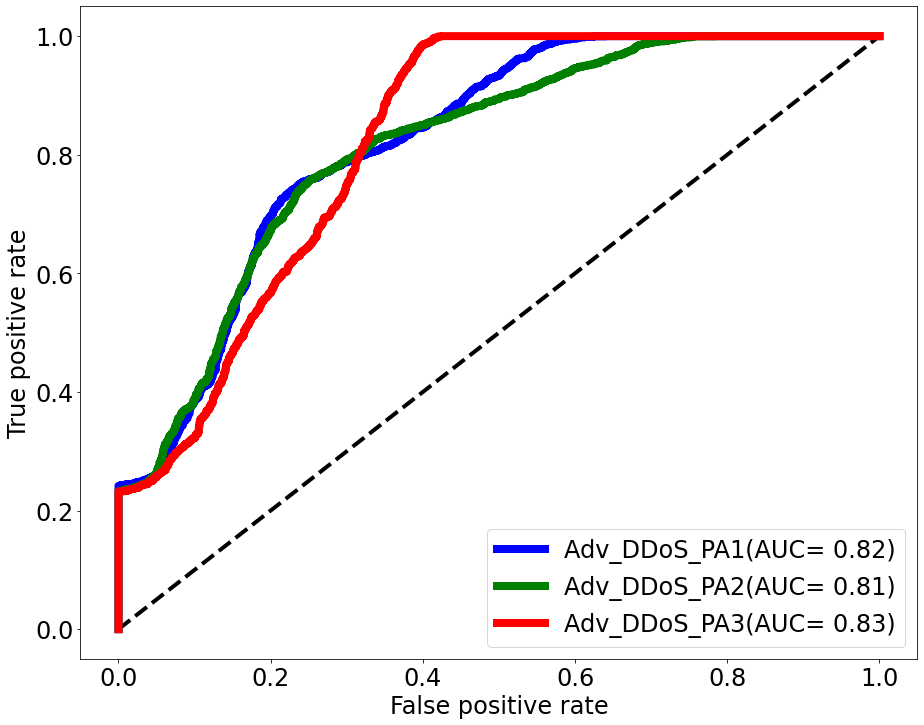

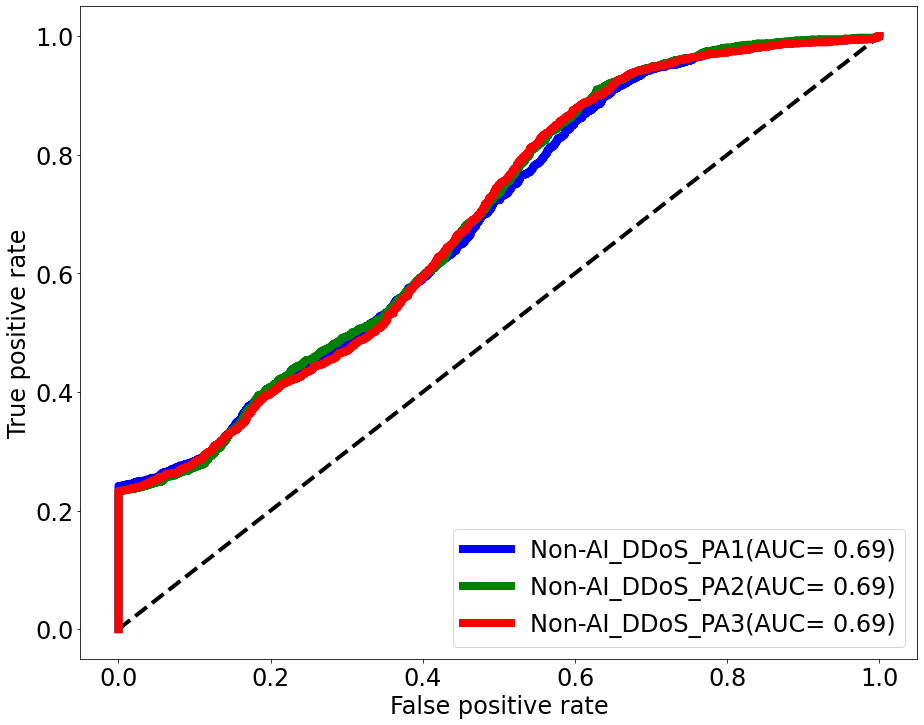

Getting data for: DoS
AA1: 1.0    16378
Name: label, dtype: int64
AA2: 1.0    17635
Name: label, dtype: int64
AA3: 1.0    16534
Name: label, dtype: int64
poly1: 1    16378
Name: label, dtype: int64
poly2: 1    17635
Name: label, dtype: int64
poly3: 1    16534
Name: label, dtype: int64
(32756, 20)
(32756,)
(35270, 20)
(35270,)
(33068, 20)
(33068,)
(32756, 20)
(32756,)
(35270, 20)
(35270,)
(33068, 20)
(33068,)

 Results for: DoS

################[1] Adver AA1##########################

Confusion matrix:

[[14397  1981]
 [ 7457  8921]]

Total number of true positives(Attack identified as Attack)) 8921
Total number of false negatives (Attack identified as Benign) 7457
Total number of false positives(Benign identified as Attack) 1981
Total number of true negatives (Benign identified as Benign) 14397
Real positives: 16378
Real negatives: 16378
Predicted positives: 10902
Predicted negatives: 21854 

Classifier Accuracy: 71.19%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 54.47%
True 

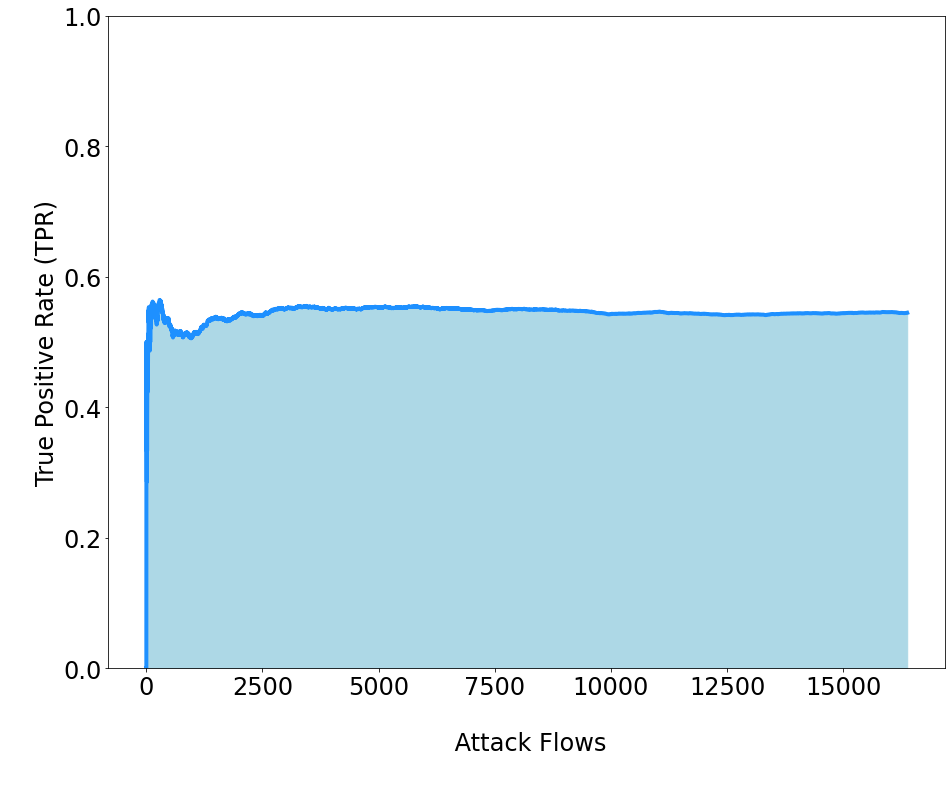


################[2] Adver AA2##########################

Confusion matrix:

[[15466  2169]
 [ 8243  9392]]

Total number of true positives(Attack identified as Attack)) 9392
Total number of false negatives (Attack identified as Benign) 8243
Total number of false positives(Benign identified as Attack) 2169
Total number of true negatives (Benign identified as Benign) 15466
Real positives: 17635
Real negatives: 17635
Predicted positives: 11561
Predicted negatives: 23709 

Classifier Accuracy: 70.48%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 53.26%
True Negative Rate (TNR/Specificity/selectivity):87.70%
Balanced accuracy:70.48%
Overall error rate (OER):29.52%
False Positive Rate (FPR)/Fall out: 12.30%
Evasion Success Rate (ESR/FNR/Miss Rate): 46.74%
Total number of correct predictions(Precision/Positive Predictive value/PPV):81.24%
F1-Score: 64.34%
Negative Predictive value (NPV):65.23%
False Discovery Rate (FDR):18.76%
Informedness: 0.41
Markedness:0.46
Misclassification/ err

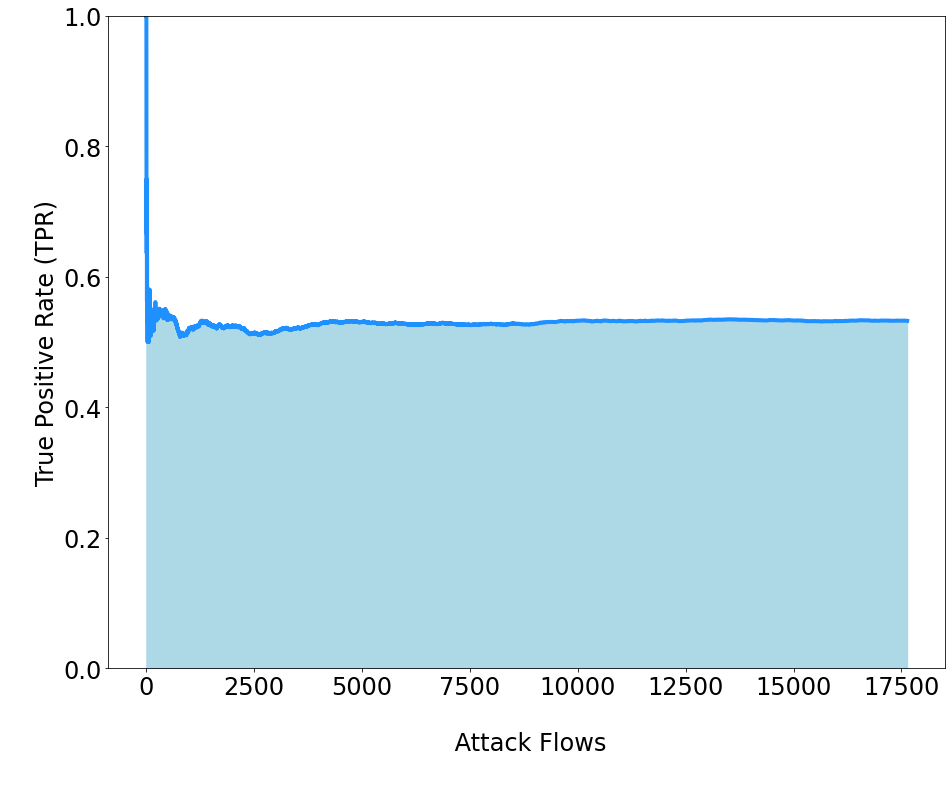


################[3] Adver AA3##########################

Confusion matrix:

[[14551  1983]
 [ 7632  8902]]

Total number of true positives(Attack identified as Attack)) 8902
Total number of false negatives (Attack identified as Benign) 7632
Total number of false positives(Benign identified as Attack) 1983
Total number of true negatives (Benign identified as Benign) 14551
Real positives: 16534
Real negatives: 16534
Predicted positives: 10885
Predicted negatives: 22183 

Classifier Accuracy: 70.92%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 53.84%
True Negative Rate (TNR/Specificity/selectivity):88.01%
Balanced accuracy:70.92%
Overall error rate (OER):29.08%
False Positive Rate (FPR)/Fall out: 11.99%
Evasion Success Rate (ESR/FNR/Miss Rate): 46.16%
Total number of correct predictions(Precision/Positive Predictive value/PPV):81.78%
F1-Score: 64.93%
Negative Predictive value (NPV):65.60%
False Discovery Rate (FDR):18.22%
Informedness: 0.42
Markedness:0.47
Misclassification/ err

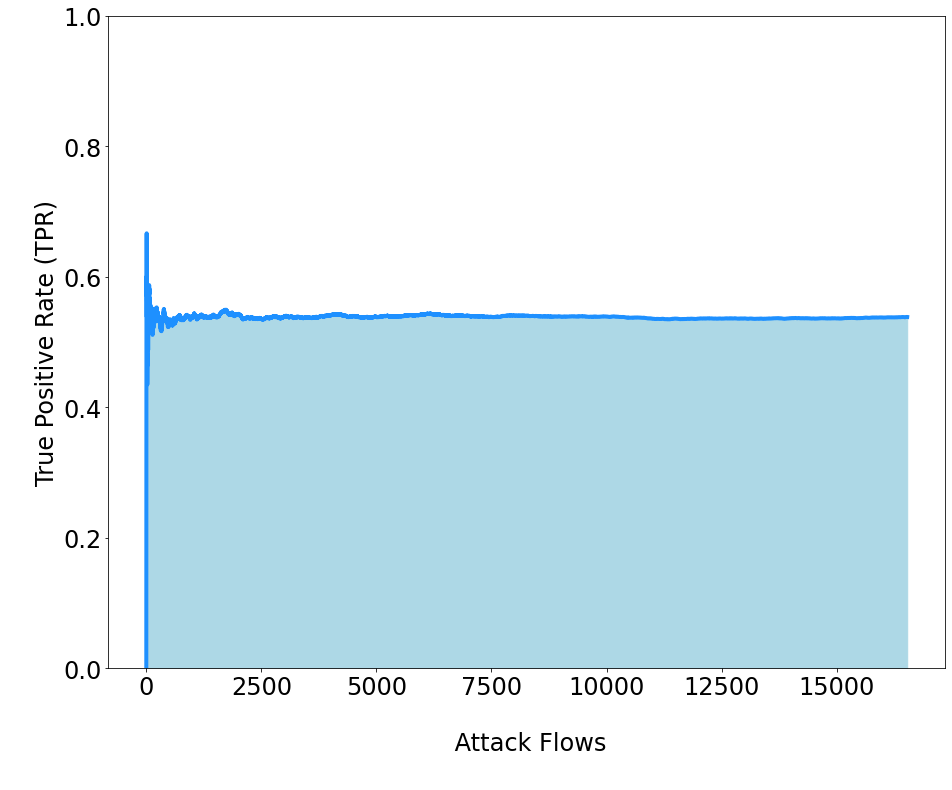


################[4] NonAI AA1##########################

Confusion matrix:

[[14361  2017]
 [ 9835  6543]]

Total number of true positives(Attack identified as Attack)) 6543
Total number of false negatives (Attack identified as Benign) 9835
Total number of false positives(Benign identified as Attack) 2017
Total number of true negatives (Benign identified as Benign) 14361
Real positives: 16378
Real negatives: 16378
Predicted positives: 8560
Predicted negatives: 24196 

Classifier Accuracy: 63.82%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 39.95%
True Negative Rate (TNR/Specificity/selectivity):87.68%
Balanced accuracy:63.82%
Overall error rate (OER):36.18%
False Positive Rate (FPR)/Fall out: 12.32%
Evasion Success Rate (ESR/FNR/Miss Rate): 60.05%
Total number of correct predictions(Precision/Positive Predictive value/PPV):76.44%
F1-Score: 52.47%
Negative Predictive value (NPV):59.35%
False Discovery Rate (FDR):23.56%
Informedness: 0.28
Markedness:0.36
Misclassification/ erro

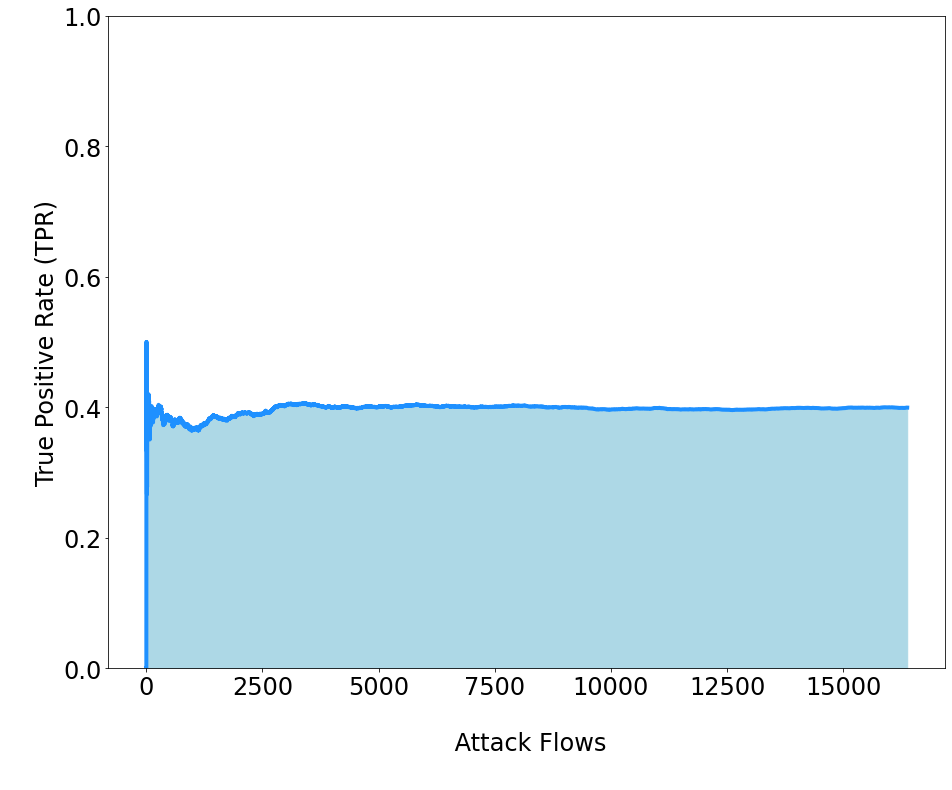


################[5] NonAI AA2##########################

Confusion matrix:

[[15515  2120]
 [10771  6864]]

Total number of true positives(Attack identified as Attack)) 6864
Total number of false negatives (Attack identified as Benign) 10771
Total number of false positives(Benign identified as Attack) 2120
Total number of true negatives (Benign identified as Benign) 15515
Real positives: 17635
Real negatives: 17635
Predicted positives: 8984
Predicted negatives: 26286 

Classifier Accuracy: 63.45%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 38.92%
True Negative Rate (TNR/Specificity/selectivity):87.98%
Balanced accuracy:63.45%
Overall error rate (OER):36.55%
False Positive Rate (FPR)/Fall out: 12.02%
Evasion Success Rate (ESR/FNR/Miss Rate): 61.08%
Total number of correct predictions(Precision/Positive Predictive value/PPV):76.40%
F1-Score: 51.57%
Negative Predictive value (NPV):59.02%
False Discovery Rate (FDR):23.60%
Informedness: 0.27
Markedness:0.35
Misclassification/ err

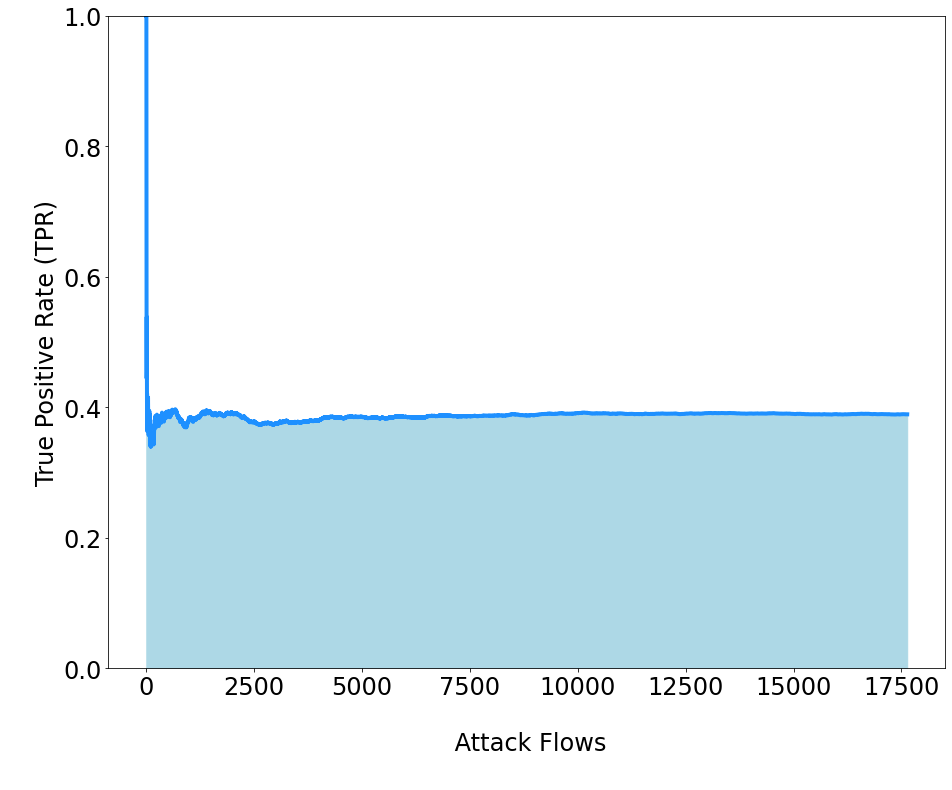


################[6] NonAI AA3##########################

Confusion matrix:

[[14525  2009]
 [ 9980  6554]]

Total number of true positives(Attack identified as Attack)) 6554
Total number of false negatives (Attack identified as Benign) 9980
Total number of false positives(Benign identified as Attack) 2009
Total number of true negatives (Benign identified as Benign) 14525
Real positives: 16534
Real negatives: 16534
Predicted positives: 8563
Predicted negatives: 24505 

Classifier Accuracy: 63.74%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 39.64%
True Negative Rate (TNR/Specificity/selectivity):87.85%
Balanced accuracy:63.74%
Overall error rate (OER):36.26%
False Positive Rate (FPR)/Fall out: 12.15%
Evasion Success Rate (ESR/FNR/Miss Rate): 60.36%
Total number of correct predictions(Precision/Positive Predictive value/PPV):76.54%
F1-Score: 52.23%
Negative Predictive value (NPV):59.27%
False Discovery Rate (FDR):23.46%
Informedness: 0.27
Markedness:0.36
Misclassification/ erro

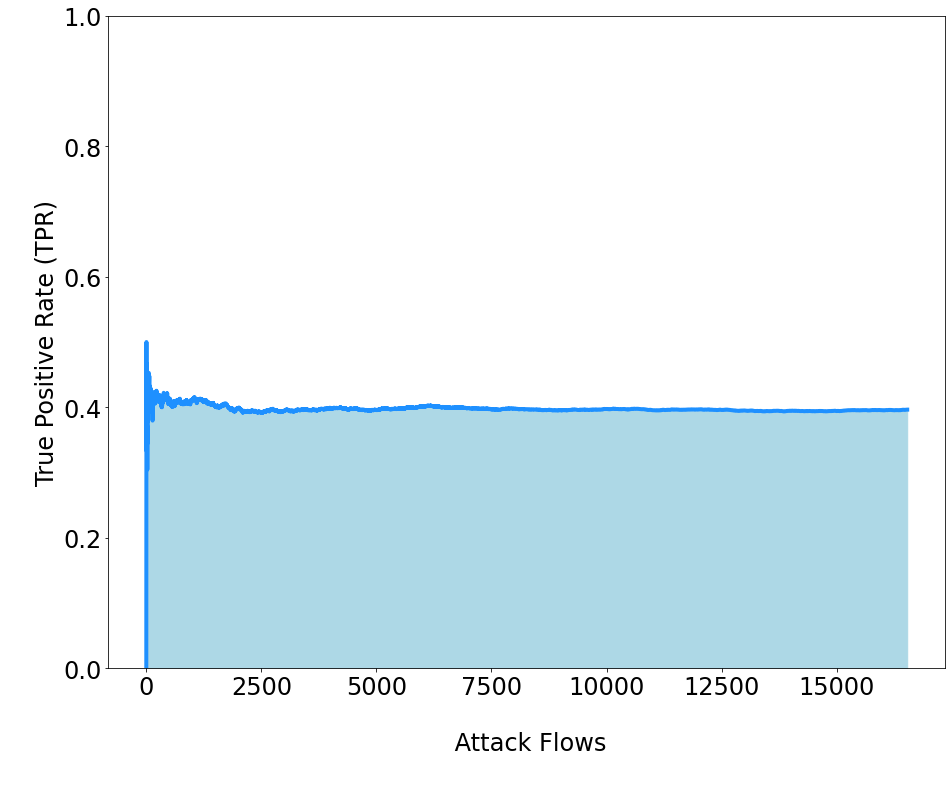

ID-CVAE Results 

TPR: 54.47%, TNR: 87.90%, BA: 71.19%, pID: 0.42 , ESR: 45.53%, OER: 28.81%, Precision: 81.83%, F1-score: 65.40%, Markedness: 0.48
TPR: 53.26%, TNR: 87.70%, BA: 70.48%, pID: 0.41 , ESR: 46.74%, OER: 29.52%, Precision: 81.24%, F1-score: 64.34%, Markedness: 0.46
TPR: 53.84%, TNR: 88.01%, BA: 70.92%, pID: 0.42 , ESR: 46.16%, OER: 29.08%, Precision: 81.78%, F1-score: 64.93%, Markedness: 0.47
TPR: 39.95%, TNR: 87.68%, BA: 63.82%, pID: 0.28 , ESR: 60.05%, OER: 36.18%, Precision: 76.44%, F1-score: 52.47%, Markedness: 0.36
TPR: 38.92%, TNR: 87.98%, BA: 63.45%, pID: 0.27 , ESR: 61.08%, OER: 36.55%, Precision: 76.40%, F1-score: 51.57%, Markedness: 0.35
TPR: 39.64%, TNR: 87.85%, BA: 63.74%, pID: 0.27 , ESR: 60.36%, OER: 36.26%, Precision: 76.54%, F1-score: 52.23%, Markedness: 0.36


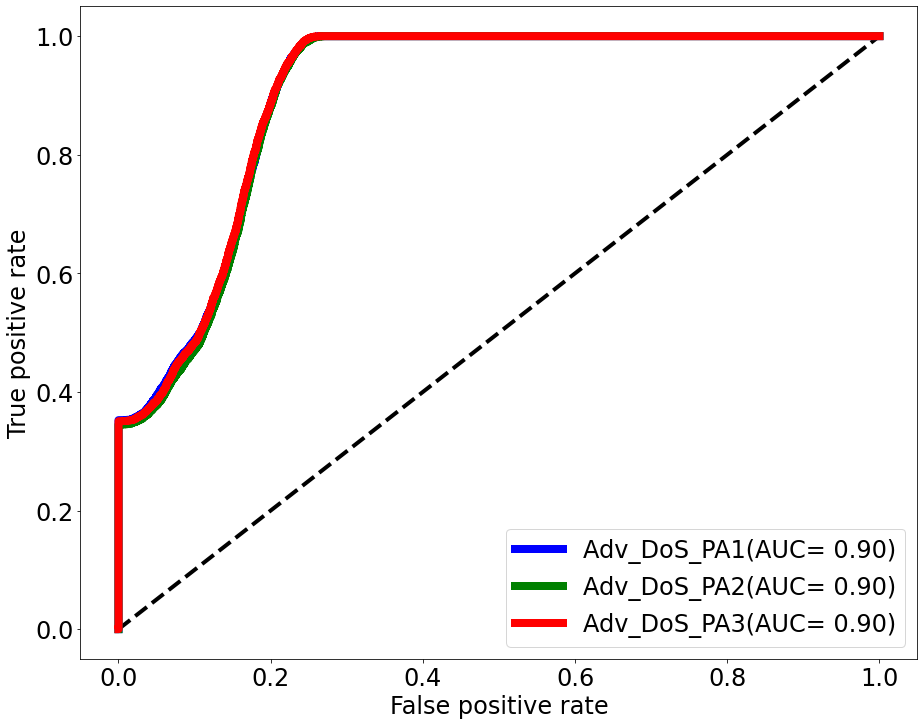

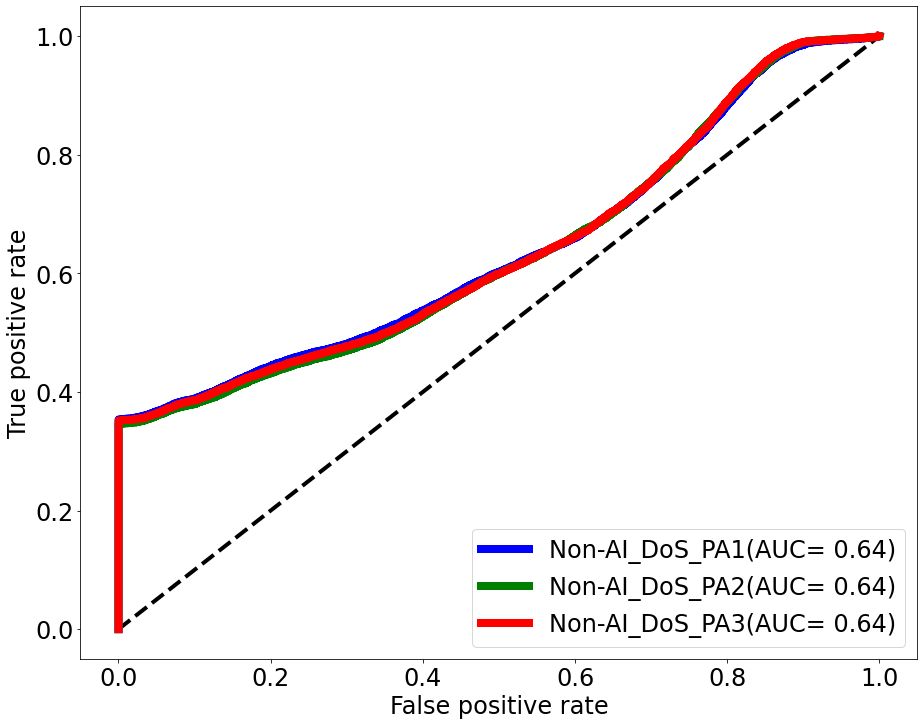

Getting data for: Mirai
AA1: 1.0    3757
Name: label, dtype: int64
AA2: 1.0    3629
Name: label, dtype: int64
AA3: 1.0    3877
Name: label, dtype: int64
poly1: 1    3757
Name: label, dtype: int64
poly2: 1    3629
Name: label, dtype: int64
poly3: 1    3877
Name: label, dtype: int64
(7514, 20)
(7514,)
(7258, 20)
(7258,)
(7754, 20)
(7754,)
(7514, 20)
(7514,)
(7258, 20)
(7258,)
(7754, 20)
(7754,)

 Results for: Mirai

################[1] Adver AA1##########################

Confusion matrix:

[[3302  455]
 [3703   54]]

Total number of true positives(Attack identified as Attack)) 54
Total number of false negatives (Attack identified as Benign) 3703
Total number of false positives(Benign identified as Attack) 455
Total number of true negatives (Benign identified as Benign) 3302
Real positives: 3757
Real negatives: 3757
Predicted positives: 509
Predicted negatives: 7005 

Classifier Accuracy: 44.66%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 1.44%
True Negative Rate (TNR/Specifici

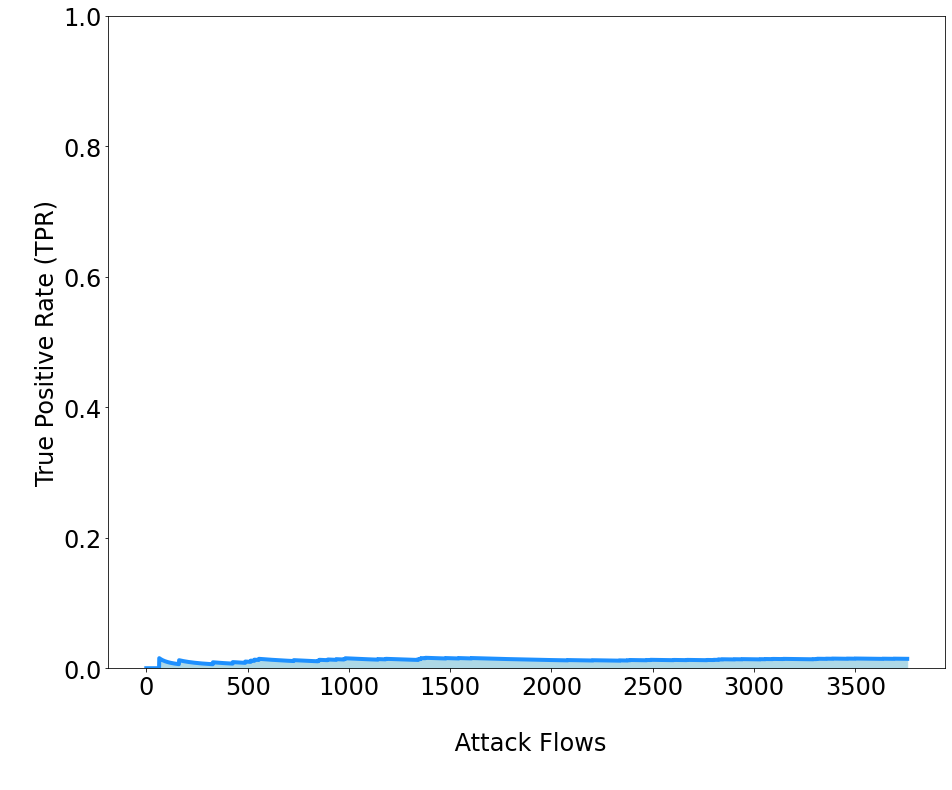


################[2] Adver AA2##########################

Confusion matrix:

[[3188  441]
 [1784 1845]]

Total number of true positives(Attack identified as Attack)) 1845
Total number of false negatives (Attack identified as Benign) 1784
Total number of false positives(Benign identified as Attack) 441
Total number of true negatives (Benign identified as Benign) 3188
Real positives: 3629
Real negatives: 3629
Predicted positives: 2286
Predicted negatives: 4972 

Classifier Accuracy: 69.34%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 50.84%
True Negative Rate (TNR/Specificity/selectivity):87.85%
Balanced accuracy:69.34%
Overall error rate (OER):30.66%
False Positive Rate (FPR)/Fall out: 12.15%
Evasion Success Rate (ESR/FNR/Miss Rate): 49.16%
Total number of correct predictions(Precision/Positive Predictive value/PPV):80.71%
F1-Score: 62.38%
Negative Predictive value (NPV):64.12%
False Discovery Rate (FDR):19.29%
Informedness: 0.39
Markedness:0.45
Misclassification/ error rate:30

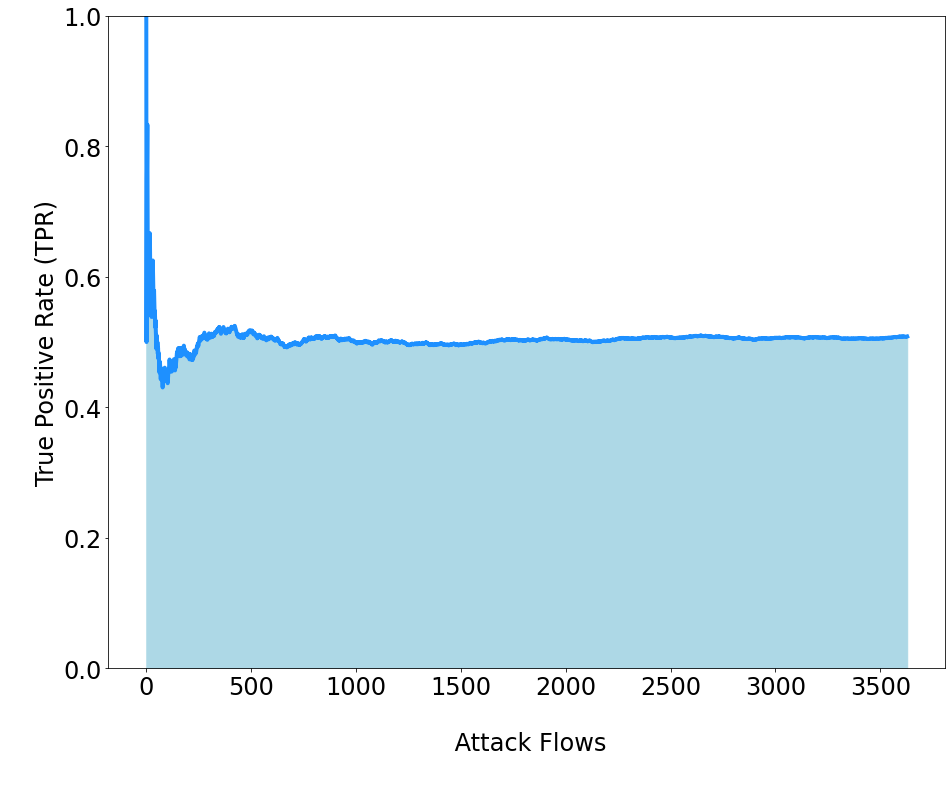


################[3] Adver AA3##########################

Confusion matrix:

[[3370  507]
 [3868    9]]

Total number of true positives(Attack identified as Attack)) 9
Total number of false negatives (Attack identified as Benign) 3868
Total number of false positives(Benign identified as Attack) 507
Total number of true negatives (Benign identified as Benign) 3370
Real positives: 3877
Real negatives: 3877
Predicted positives: 516
Predicted negatives: 7238 

Classifier Accuracy: 43.58%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 0.23%
True Negative Rate (TNR/Specificity/selectivity):86.92%
Balanced accuracy:43.58%
Overall error rate (OER):56.42%
False Positive Rate (FPR)/Fall out: 13.08%
Evasion Success Rate (ESR/FNR/Miss Rate): 99.77%
Total number of correct predictions(Precision/Positive Predictive value/PPV):1.74%
F1-Score: 0.41%
Negative Predictive value (NPV):46.56%
False Discovery Rate (FDR):98.26%
Informedness: -0.13
Markedness:-0.52
Misclassification/ error rate:56.42%


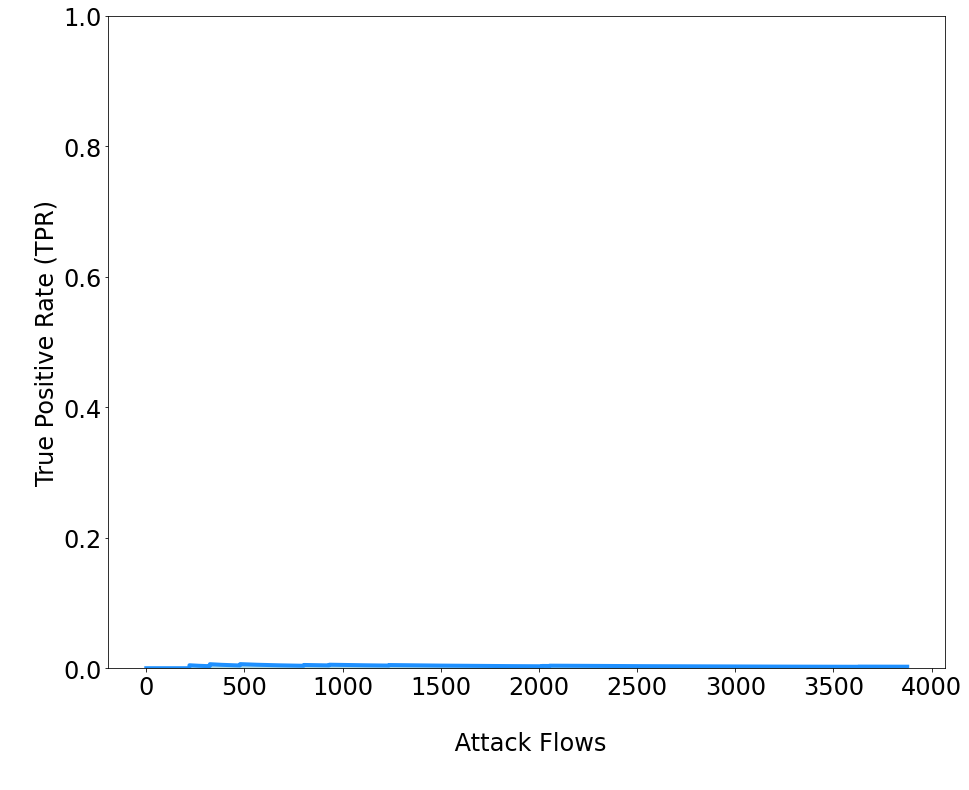


################[4] NonAI AA1##########################

Confusion matrix:

[[3293  464]
 [1201 2556]]

Total number of true positives(Attack identified as Attack)) 2556
Total number of false negatives (Attack identified as Benign) 1201
Total number of false positives(Benign identified as Attack) 464
Total number of true negatives (Benign identified as Benign) 3293
Real positives: 3757
Real negatives: 3757
Predicted positives: 3020
Predicted negatives: 4494 

Classifier Accuracy: 77.84%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 68.03%
True Negative Rate (TNR/Specificity/selectivity):87.65%
Balanced accuracy:77.84%
Overall error rate (OER):22.16%
False Positive Rate (FPR)/Fall out: 12.35%
Evasion Success Rate (ESR/FNR/Miss Rate): 31.97%
Total number of correct predictions(Precision/Positive Predictive value/PPV):84.64%
F1-Score: 75.43%
Negative Predictive value (NPV):73.28%
False Discovery Rate (FDR):15.36%
Informedness: 0.56
Markedness:0.58
Misclassification/ error rate:22

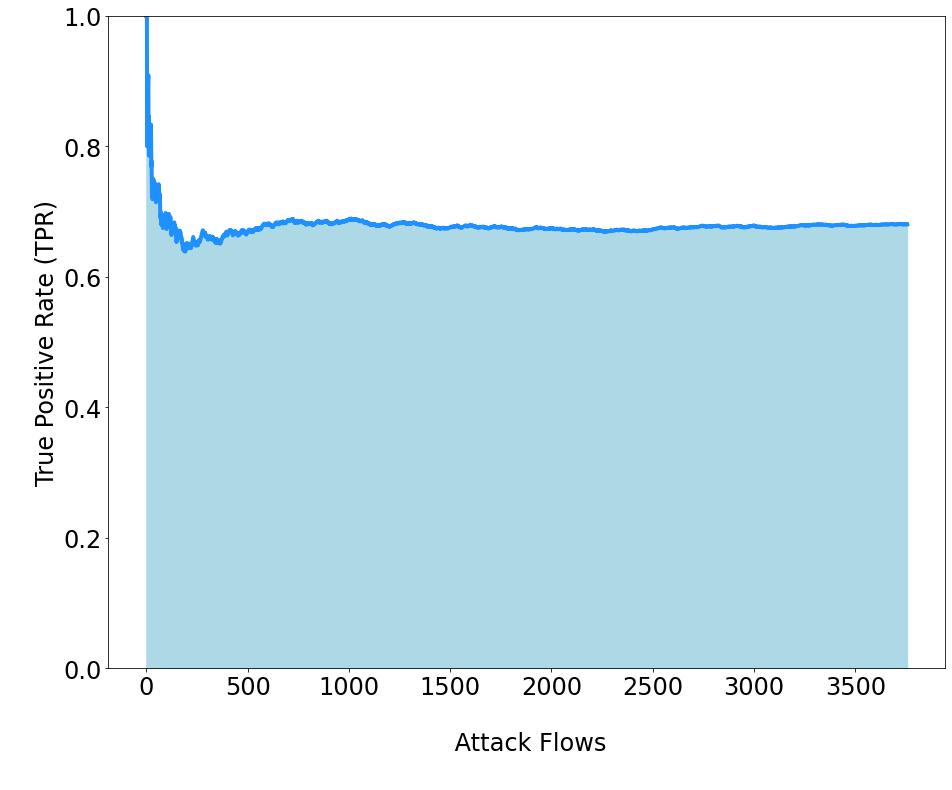


################[5] NonAI AA2##########################

Confusion matrix:

[[3196  433]
 [1168 2461]]

Total number of true positives(Attack identified as Attack)) 2461
Total number of false negatives (Attack identified as Benign) 1168
Total number of false positives(Benign identified as Attack) 433
Total number of true negatives (Benign identified as Benign) 3196
Real positives: 3629
Real negatives: 3629
Predicted positives: 2894
Predicted negatives: 4364 

Classifier Accuracy: 77.94%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 67.81%
True Negative Rate (TNR/Specificity/selectivity):88.07%
Balanced accuracy:77.94%
Overall error rate (OER):22.06%
False Positive Rate (FPR)/Fall out: 11.93%
Evasion Success Rate (ESR/FNR/Miss Rate): 32.19%
Total number of correct predictions(Precision/Positive Predictive value/PPV):85.04%
F1-Score: 75.46%
Negative Predictive value (NPV):73.24%
False Discovery Rate (FDR):14.96%
Informedness: 0.56
Markedness:0.58
Misclassification/ error rate:22

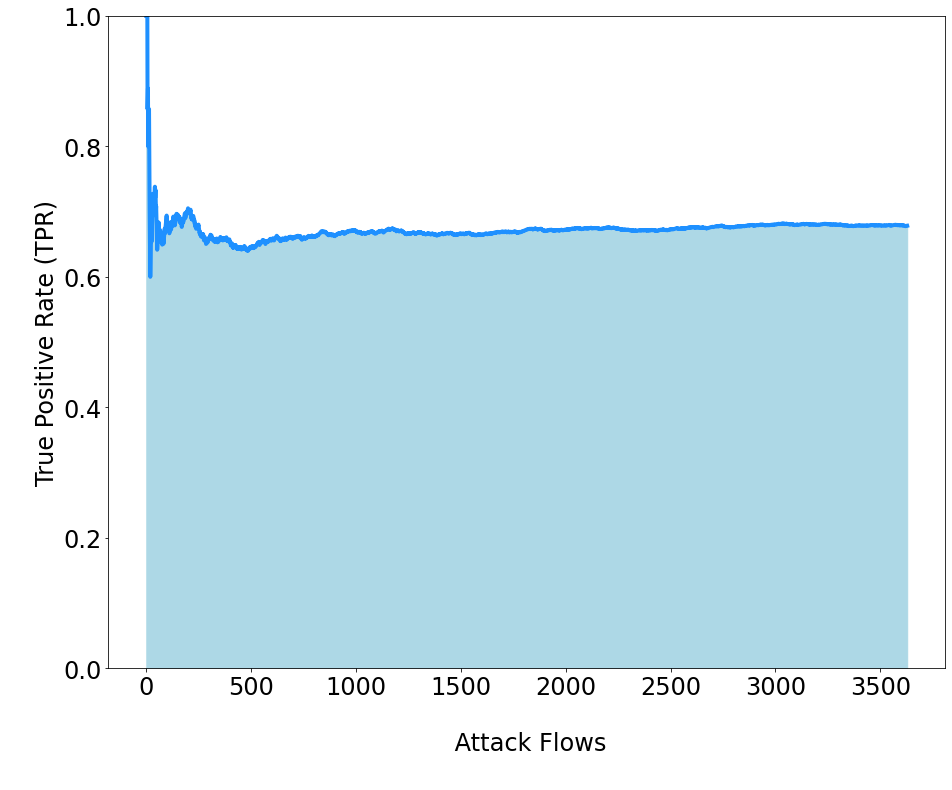


################[6] NonAI AA3##########################

Confusion matrix:

[[3412  465]
 [1267 2610]]

Total number of true positives(Attack identified as Attack)) 2610
Total number of false negatives (Attack identified as Benign) 1267
Total number of false positives(Benign identified as Attack) 465
Total number of true negatives (Benign identified as Benign) 3412
Real positives: 3877
Real negatives: 3877
Predicted positives: 3075
Predicted negatives: 4679 

Classifier Accuracy: 77.66%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 67.32%
True Negative Rate (TNR/Specificity/selectivity):88.01%
Balanced accuracy:77.66%
Overall error rate (OER):22.34%
False Positive Rate (FPR)/Fall out: 11.99%
Evasion Success Rate (ESR/FNR/Miss Rate): 32.68%
Total number of correct predictions(Precision/Positive Predictive value/PPV):84.88%
F1-Score: 75.09%
Negative Predictive value (NPV):72.92%
False Discovery Rate (FDR):15.12%
Informedness: 0.55
Markedness:0.58
Misclassification/ error rate:22

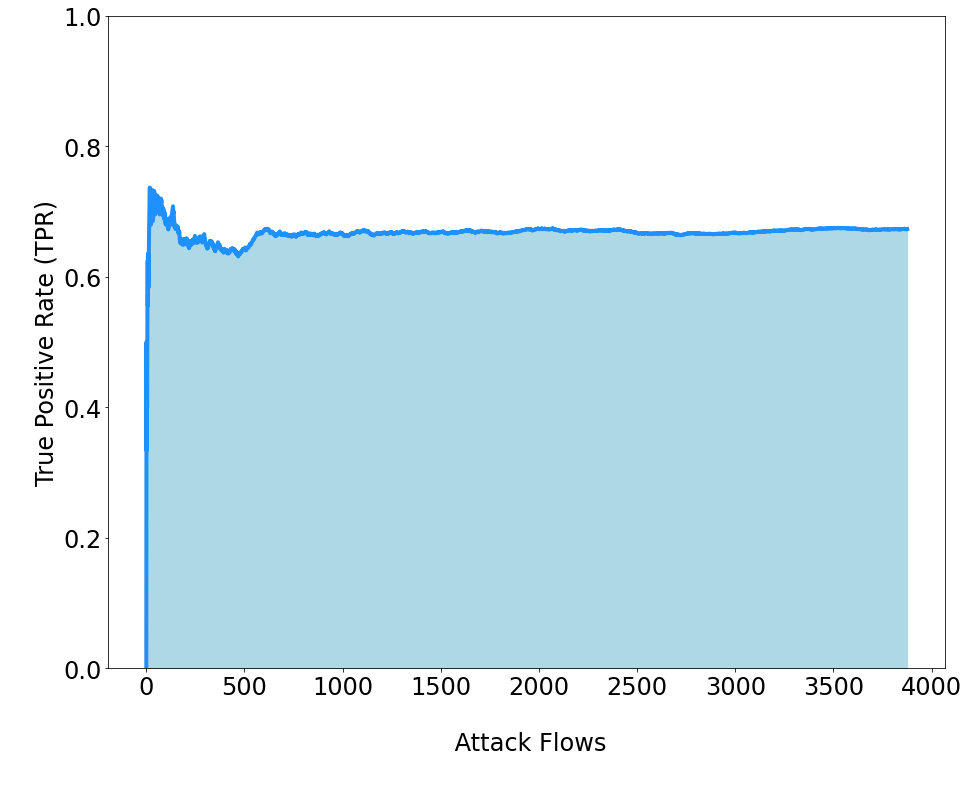

ID-CVAE Results 

TPR: 1.44%, TNR: 87.89%, BA: 44.66%, pID: -0.11 , ESR: 98.56%, OER: 55.34%, Precision: 10.61%, F1-score: 2.53%, Markedness: -0.42
TPR: 50.84%, TNR: 87.85%, BA: 69.34%, pID: 0.39 , ESR: 49.16%, OER: 30.66%, Precision: 80.71%, F1-score: 62.38%, Markedness: 0.45
TPR: 0.23%, TNR: 86.92%, BA: 43.58%, pID: -0.13 , ESR: 99.77%, OER: 56.42%, Precision: 1.74%, F1-score: 0.41%, Markedness: -0.52
TPR: 68.03%, TNR: 87.65%, BA: 77.84%, pID: 0.56 , ESR: 31.97%, OER: 22.16%, Precision: 84.64%, F1-score: 75.43%, Markedness: 0.58
TPR: 67.81%, TNR: 88.07%, BA: 77.94%, pID: 0.56 , ESR: 32.19%, OER: 22.06%, Precision: 85.04%, F1-score: 75.46%, Markedness: 0.58
TPR: 67.32%, TNR: 88.01%, BA: 77.66%, pID: 0.55 , ESR: 32.68%, OER: 22.34%, Precision: 84.88%, F1-score: 75.09%, Markedness: 0.58


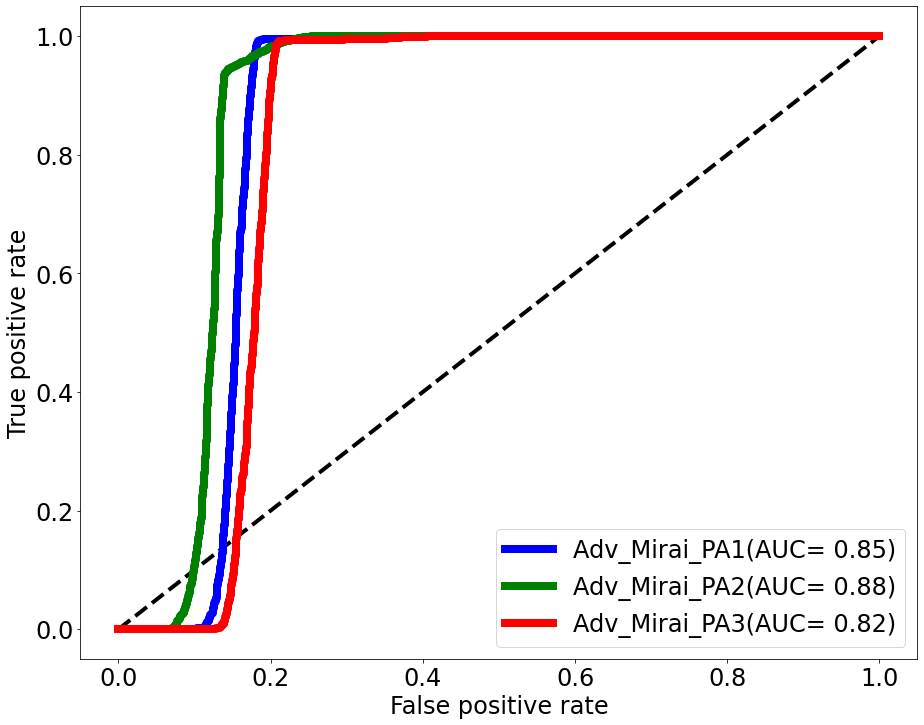

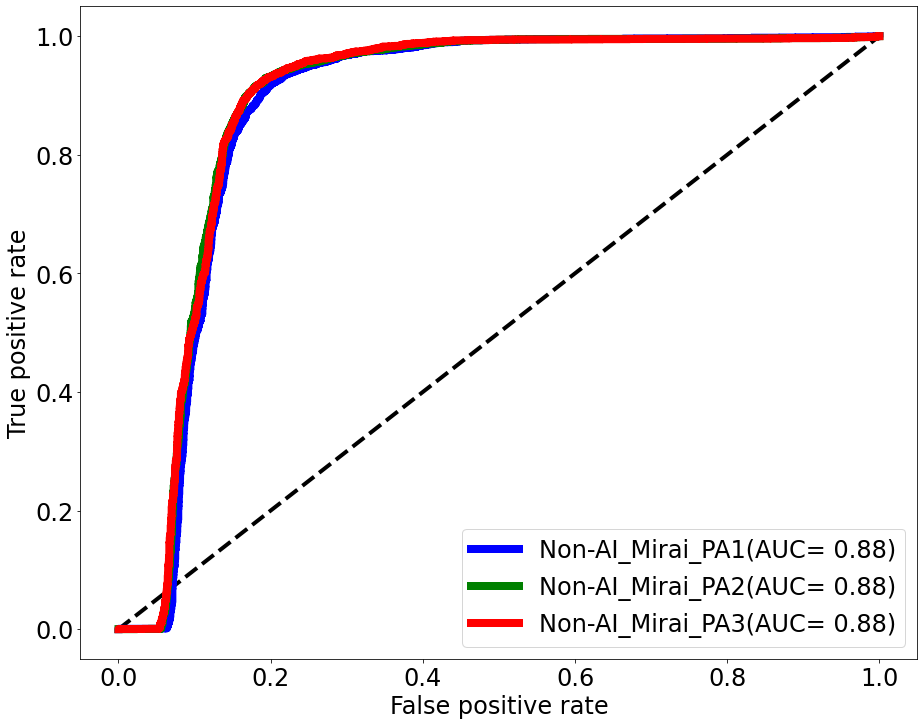

Getting data for: Recon
AA1: 1.0    19492
Name: label, dtype: int64
AA2: 1.0    19361
Name: label, dtype: int64
AA3: 1.0    22226
Name: label, dtype: int64
poly1: 1    19492
Name: label, dtype: int64
poly2: 1    19361
Name: label, dtype: int64
poly3: 1    22226
Name: label, dtype: int64
(38984, 20)
(38984,)
(38722, 20)
(38722,)
(44452, 20)
(44452,)
(38984, 20)
(38984,)
(38722, 20)
(38722,)
(44452, 20)
(44452,)

 Results for: Recon

################[1] Adver AA1##########################

Confusion matrix:

[[17100  2392]
 [ 8016 11476]]

Total number of true positives(Attack identified as Attack)) 11476
Total number of false negatives (Attack identified as Benign) 8016
Total number of false positives(Benign identified as Attack) 2392
Total number of true negatives (Benign identified as Benign) 17100
Real positives: 19492
Real negatives: 19492
Predicted positives: 13868
Predicted negatives: 25116 

Classifier Accuracy: 73.30%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 58.88%


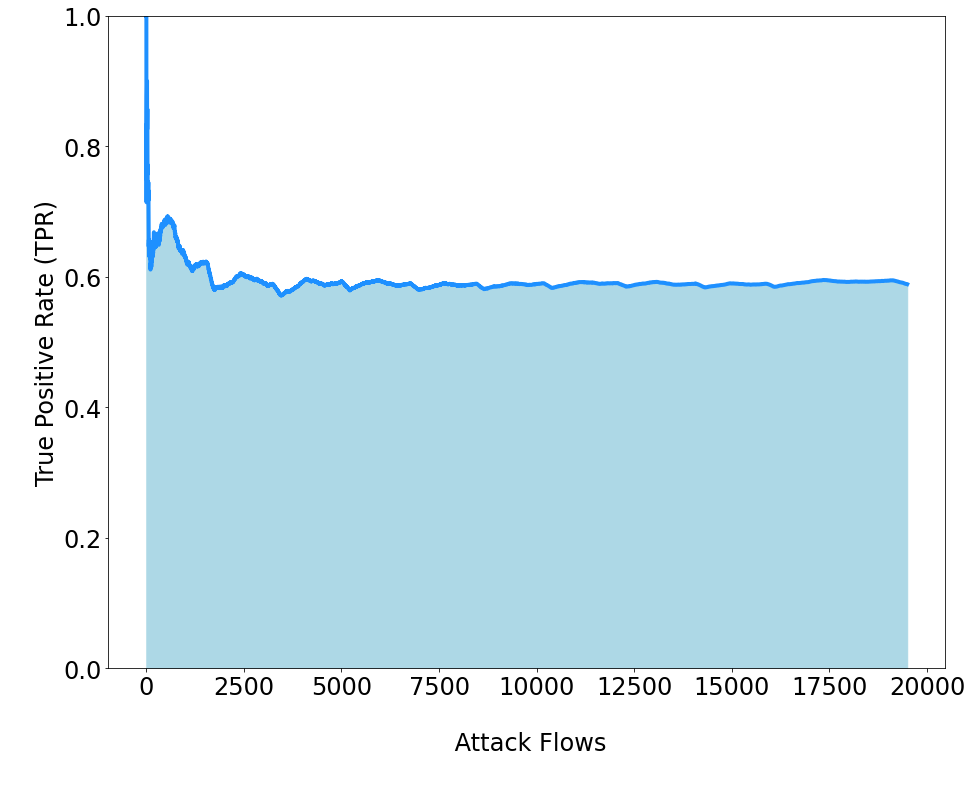


################[2] Adver AA2##########################

Confusion matrix:

[[17058  2303]
 [12685  6676]]

Total number of true positives(Attack identified as Attack)) 6676
Total number of false negatives (Attack identified as Benign) 12685
Total number of false positives(Benign identified as Attack) 2303
Total number of true negatives (Benign identified as Benign) 17058
Real positives: 19361
Real negatives: 19361
Predicted positives: 8979
Predicted negatives: 29743 

Classifier Accuracy: 61.29%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 34.48%
True Negative Rate (TNR/Specificity/selectivity):88.10%
Balanced accuracy:61.29%
Overall error rate (OER):38.71%
False Positive Rate (FPR)/Fall out: 11.90%
Evasion Success Rate (ESR/FNR/Miss Rate): 65.52%
Total number of correct predictions(Precision/Positive Predictive value/PPV):74.35%
F1-Score: 47.11%
Negative Predictive value (NPV):57.35%
False Discovery Rate (FDR):25.65%
Informedness: 0.23
Markedness:0.32
Misclassification/ err

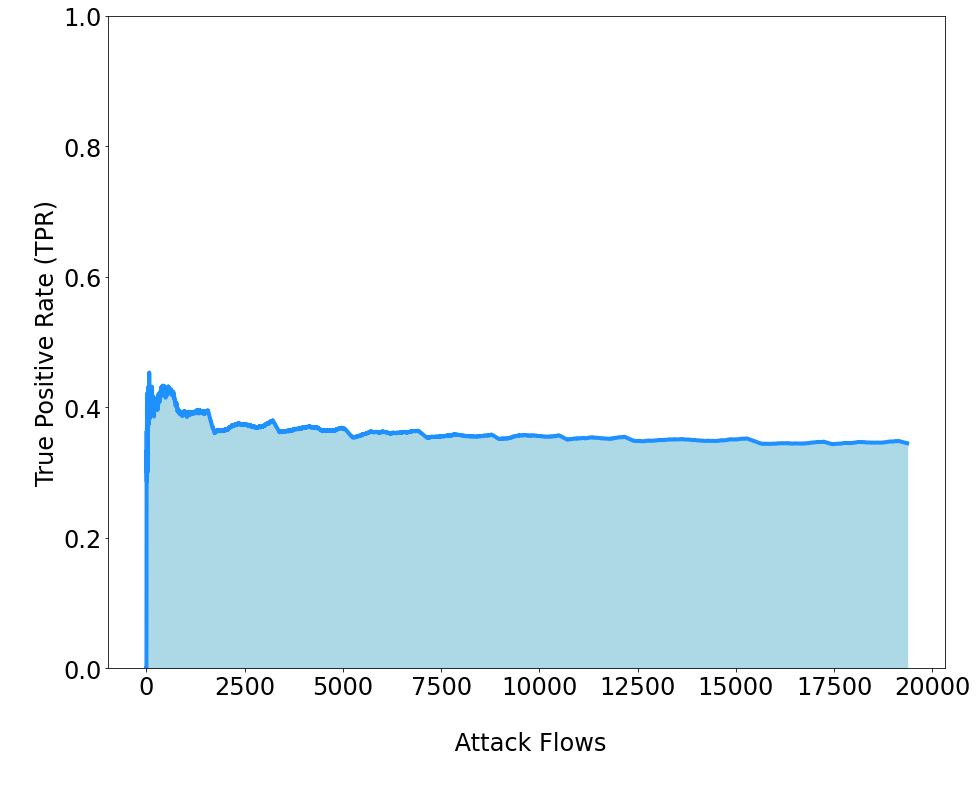


################[3] Adver AA3##########################

Confusion matrix:

[[19564  2662]
 [14458  7768]]

Total number of true positives(Attack identified as Attack)) 7768
Total number of false negatives (Attack identified as Benign) 14458
Total number of false positives(Benign identified as Attack) 2662
Total number of true negatives (Benign identified as Benign) 19564
Real positives: 22226
Real negatives: 22226
Predicted positives: 10430
Predicted negatives: 34022 

Classifier Accuracy: 61.49%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 34.95%
True Negative Rate (TNR/Specificity/selectivity):88.02%
Balanced accuracy:61.49%
Overall error rate (OER):38.51%
False Positive Rate (FPR)/Fall out: 11.98%
Evasion Success Rate (ESR/FNR/Miss Rate): 65.05%
Total number of correct predictions(Precision/Positive Predictive value/PPV):74.48%
F1-Score: 47.57%
Negative Predictive value (NPV):57.50%
False Discovery Rate (FDR):25.52%
Informedness: 0.23
Markedness:0.32
Misclassification/ er

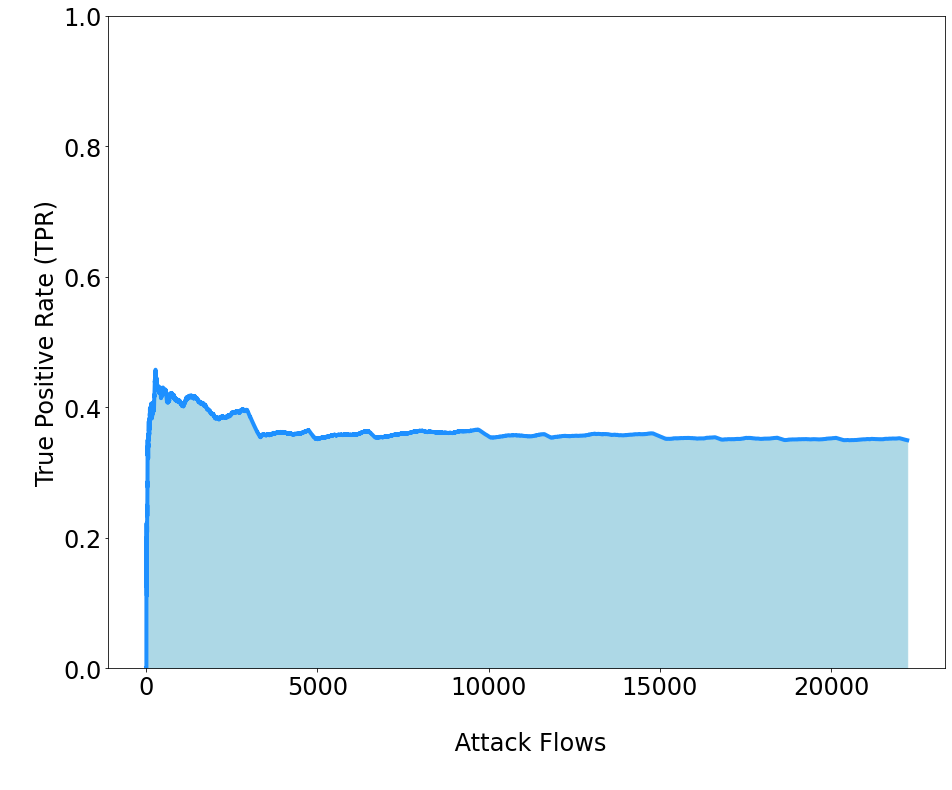


################[4] NonAI AA1##########################

Confusion matrix:

[[17089  2403]
 [ 9746  9746]]

Total number of true positives(Attack identified as Attack)) 9746
Total number of false negatives (Attack identified as Benign) 9746
Total number of false positives(Benign identified as Attack) 2403
Total number of true negatives (Benign identified as Benign) 17089
Real positives: 19492
Real negatives: 19492
Predicted positives: 12149
Predicted negatives: 26835 

Classifier Accuracy: 68.84%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 50.00%
True Negative Rate (TNR/Specificity/selectivity):87.67%
Balanced accuracy:68.84%
Overall error rate (OER):31.16%
False Positive Rate (FPR)/Fall out: 12.33%
Evasion Success Rate (ESR/FNR/Miss Rate): 50.00%
Total number of correct predictions(Precision/Positive Predictive value/PPV):80.22%
F1-Score: 61.60%
Negative Predictive value (NPV):63.68%
False Discovery Rate (FDR):19.78%
Informedness: 0.38
Markedness:0.44
Misclassification/ err

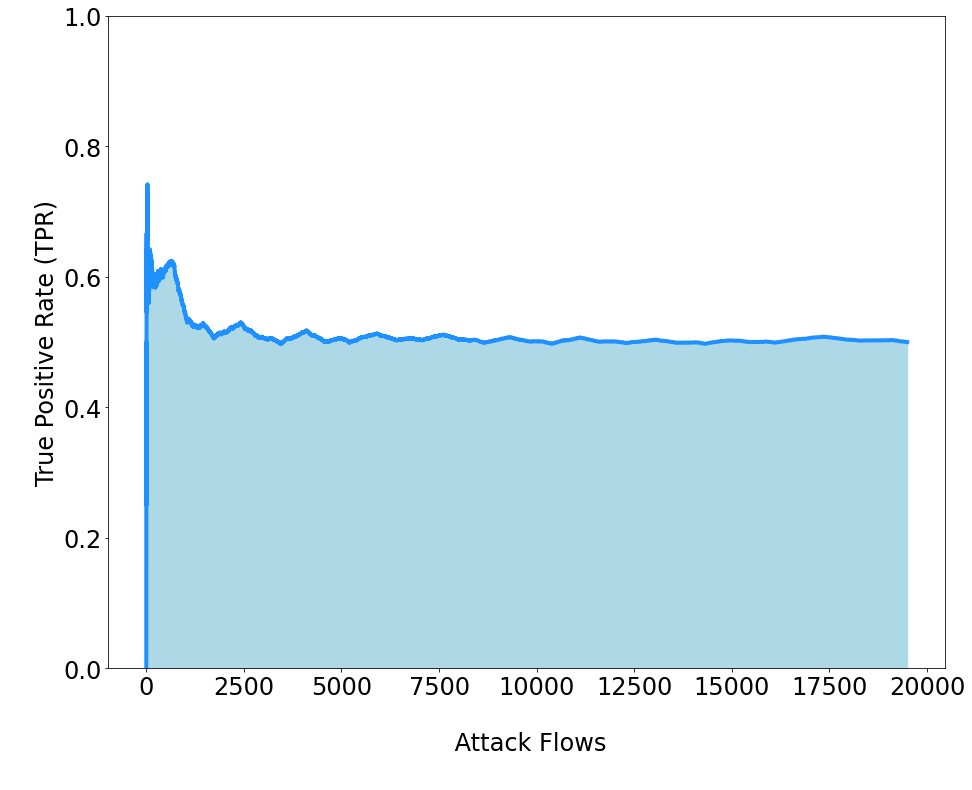


################[5] NonAI AA2##########################

Confusion matrix:

[[16954  2407]
 [ 9782  9579]]

Total number of true positives(Attack identified as Attack)) 9579
Total number of false negatives (Attack identified as Benign) 9782
Total number of false positives(Benign identified as Attack) 2407
Total number of true negatives (Benign identified as Benign) 16954
Real positives: 19361
Real negatives: 19361
Predicted positives: 11986
Predicted negatives: 26736 

Classifier Accuracy: 68.52%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 49.48%
True Negative Rate (TNR/Specificity/selectivity):87.57%
Balanced accuracy:68.52%
Overall error rate (OER):31.48%
False Positive Rate (FPR)/Fall out: 12.43%
Evasion Success Rate (ESR/FNR/Miss Rate): 50.52%
Total number of correct predictions(Precision/Positive Predictive value/PPV):79.92%
F1-Score: 61.12%
Negative Predictive value (NPV):63.41%
False Discovery Rate (FDR):20.08%
Informedness: 0.37
Markedness:0.43
Misclassification/ err

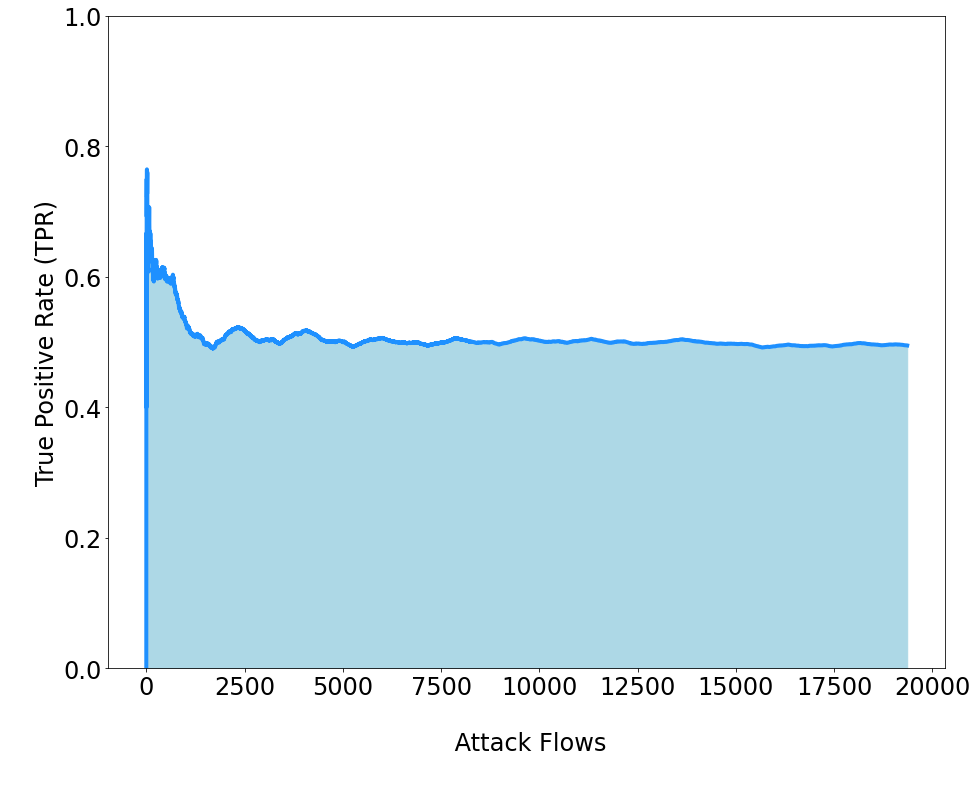


################[6] NonAI AA3##########################

Confusion matrix:

[[19494  2732]
 [11191 11035]]

Total number of true positives(Attack identified as Attack)) 11035
Total number of false negatives (Attack identified as Benign) 11191
Total number of false positives(Benign identified as Attack) 2732
Total number of true negatives (Benign identified as Benign) 19494
Real positives: 22226
Real negatives: 22226
Predicted positives: 13767
Predicted negatives: 30685 

Classifier Accuracy: 68.68%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 49.65%
True Negative Rate (TNR/Specificity/selectivity):87.71%
Balanced accuracy:68.68%
Overall error rate (OER):31.32%
False Positive Rate (FPR)/Fall out: 12.29%
Evasion Success Rate (ESR/FNR/Miss Rate): 50.35%
Total number of correct predictions(Precision/Positive Predictive value/PPV):80.16%
F1-Score: 61.32%
Negative Predictive value (NPV):63.53%
False Discovery Rate (FDR):19.84%
Informedness: 0.37
Markedness:0.44
Misclassification/ e

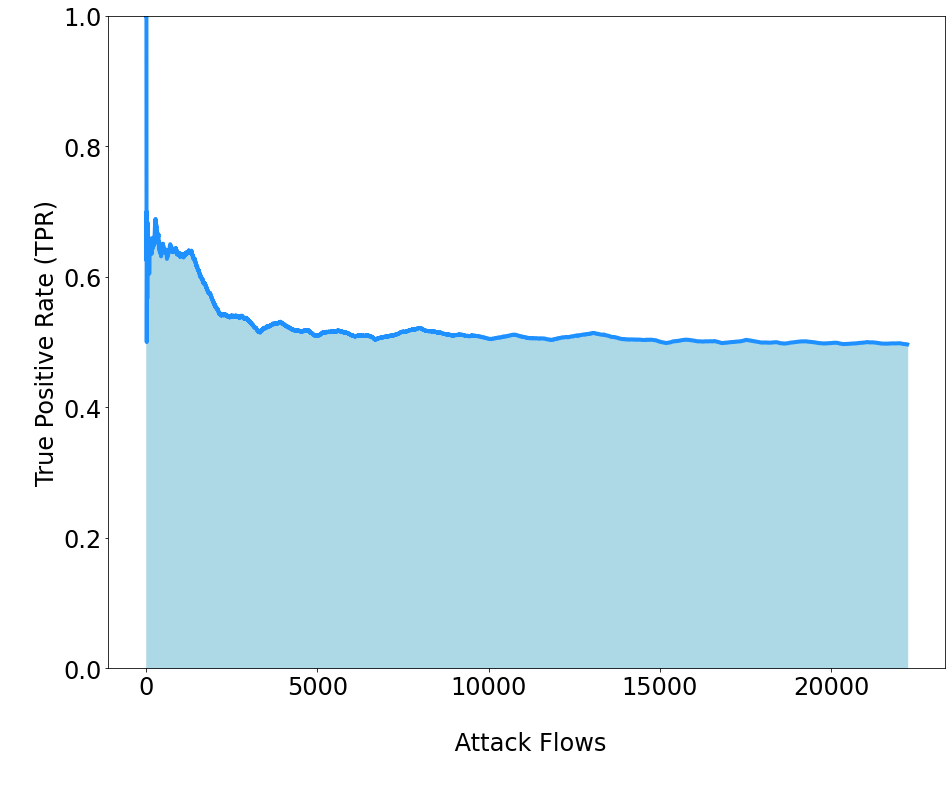

ID-CVAE Results 

TPR: 58.88%, TNR: 87.73%, BA: 73.30%, pID: 0.47 , ESR: 41.12%, OER: 26.70%, Precision: 82.75%, F1-score: 68.80%, Markedness: 0.51
TPR: 34.48%, TNR: 88.10%, BA: 61.29%, pID: 0.23 , ESR: 65.52%, OER: 38.71%, Precision: 74.35%, F1-score: 47.11%, Markedness: 0.32
TPR: 34.95%, TNR: 88.02%, BA: 61.49%, pID: 0.23 , ESR: 65.05%, OER: 38.51%, Precision: 74.48%, F1-score: 47.57%, Markedness: 0.32
TPR: 50.00%, TNR: 87.67%, BA: 68.84%, pID: 0.38 , ESR: 50.00%, OER: 31.16%, Precision: 80.22%, F1-score: 61.60%, Markedness: 0.44
TPR: 49.48%, TNR: 87.57%, BA: 68.52%, pID: 0.37 , ESR: 50.52%, OER: 31.48%, Precision: 79.92%, F1-score: 61.12%, Markedness: 0.43
TPR: 49.65%, TNR: 87.71%, BA: 68.68%, pID: 0.37 , ESR: 50.35%, OER: 31.32%, Precision: 80.16%, F1-score: 61.32%, Markedness: 0.44


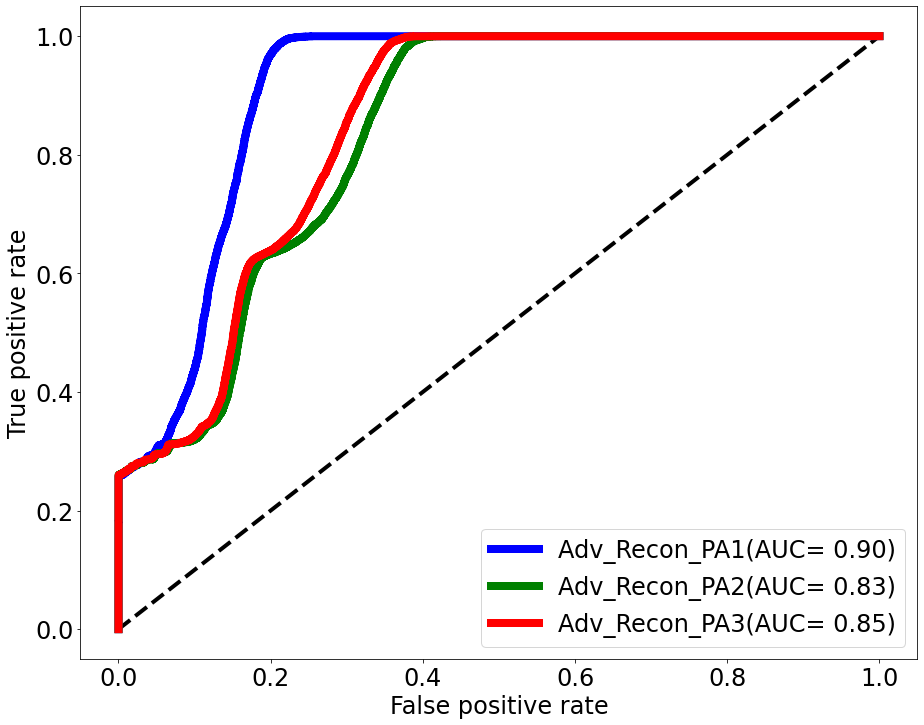

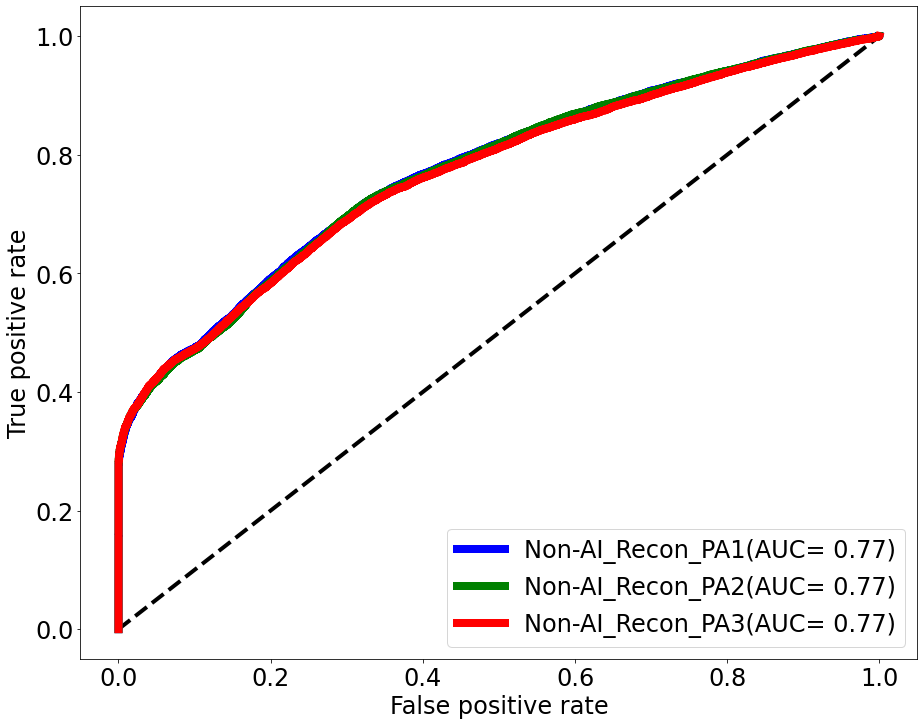

Getting data for: Spoof
AA1: 1.0    26917
Name: label, dtype: int64
AA2: 1.0    26985
Name: label, dtype: int64
AA3: 1.0    30619
Name: label, dtype: int64
poly1: 1    26917
Name: label, dtype: int64
poly2: 1    26985
Name: label, dtype: int64
poly3: 1    30619
Name: label, dtype: int64
(53834, 20)
(53834,)
(53970, 20)
(53970,)
(61238, 20)
(61238,)
(53834, 20)
(53834,)
(53970, 20)
(53970,)
(61238, 20)
(61238,)

 Results for: Spoof

################[1] Adver AA1##########################

Confusion matrix:

[[23599  3318]
 [26046   871]]

Total number of true positives(Attack identified as Attack)) 871
Total number of false negatives (Attack identified as Benign) 26046
Total number of false positives(Benign identified as Attack) 3318
Total number of true negatives (Benign identified as Benign) 23599
Real positives: 26917
Real negatives: 26917
Predicted positives: 4189
Predicted negatives: 49645 

Classifier Accuracy: 45.45%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 3.24%
Tru

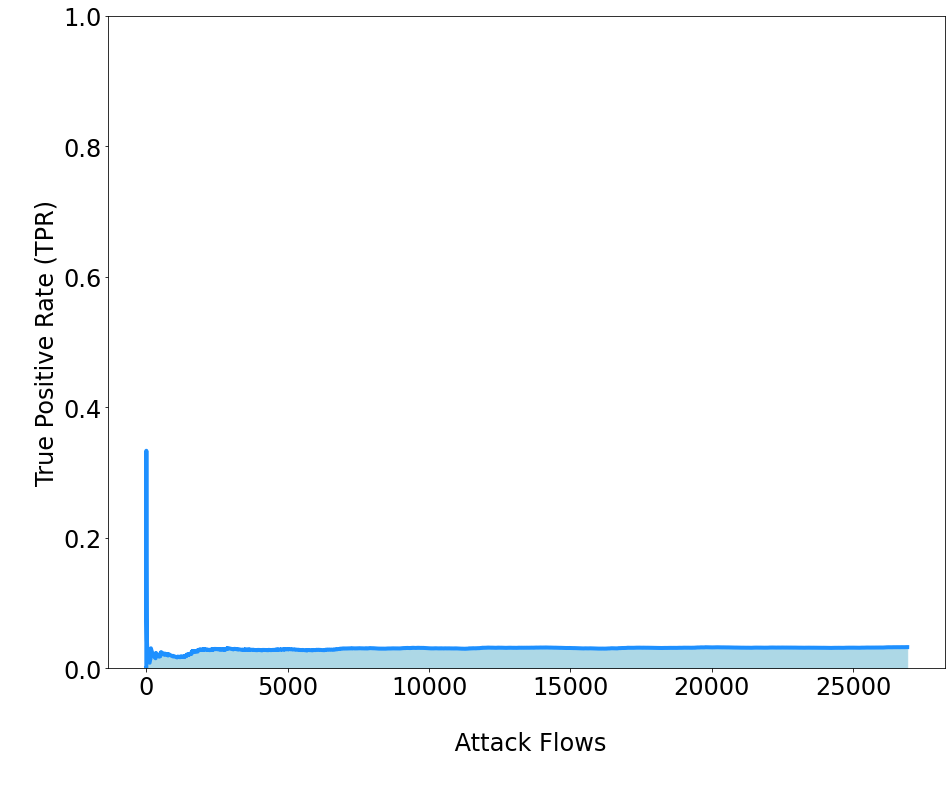


################[2] Adver AA2##########################

Confusion matrix:

[[23664  3321]
 [26171   814]]

Total number of true positives(Attack identified as Attack)) 814
Total number of false negatives (Attack identified as Benign) 26171
Total number of false positives(Benign identified as Attack) 3321
Total number of true negatives (Benign identified as Benign) 23664
Real positives: 26985
Real negatives: 26985
Predicted positives: 4135
Predicted negatives: 49835 

Classifier Accuracy: 45.35%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 3.02%
True Negative Rate (TNR/Specificity/selectivity):87.69%
Balanced accuracy:45.35%
Overall error rate (OER):54.65%
False Positive Rate (FPR)/Fall out: 12.31%
Evasion Success Rate (ESR/FNR/Miss Rate): 96.98%
Total number of correct predictions(Precision/Positive Predictive value/PPV):19.69%
F1-Score: 5.23%
Negative Predictive value (NPV):47.48%
False Discovery Rate (FDR):80.31%
Informedness: -0.09
Markedness:-0.33
Misclassification/ erro

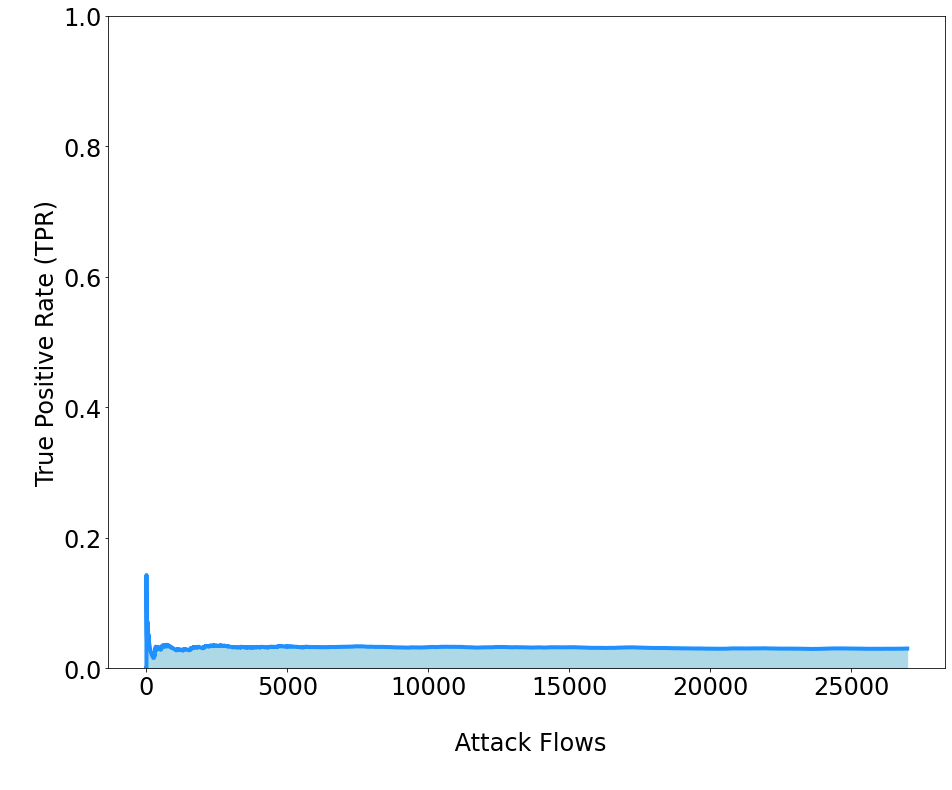


################[3] Adver AA3##########################

Confusion matrix:

[[26987  3632]
 [21010  9609]]

Total number of true positives(Attack identified as Attack)) 9609
Total number of false negatives (Attack identified as Benign) 21010
Total number of false positives(Benign identified as Attack) 3632
Total number of true negatives (Benign identified as Benign) 26987
Real positives: 30619
Real negatives: 30619
Predicted positives: 13241
Predicted negatives: 47997 

Classifier Accuracy: 59.76%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 31.38%
True Negative Rate (TNR/Specificity/selectivity):88.14%
Balanced accuracy:59.76%
Overall error rate (OER):40.24%
False Positive Rate (FPR)/Fall out: 11.86%
Evasion Success Rate (ESR/FNR/Miss Rate): 68.62%
Total number of correct predictions(Precision/Positive Predictive value/PPV):72.57%
F1-Score: 43.82%
Negative Predictive value (NPV):56.23%
False Discovery Rate (FDR):27.43%
Informedness: 0.20
Markedness:0.29
Misclassification/ er

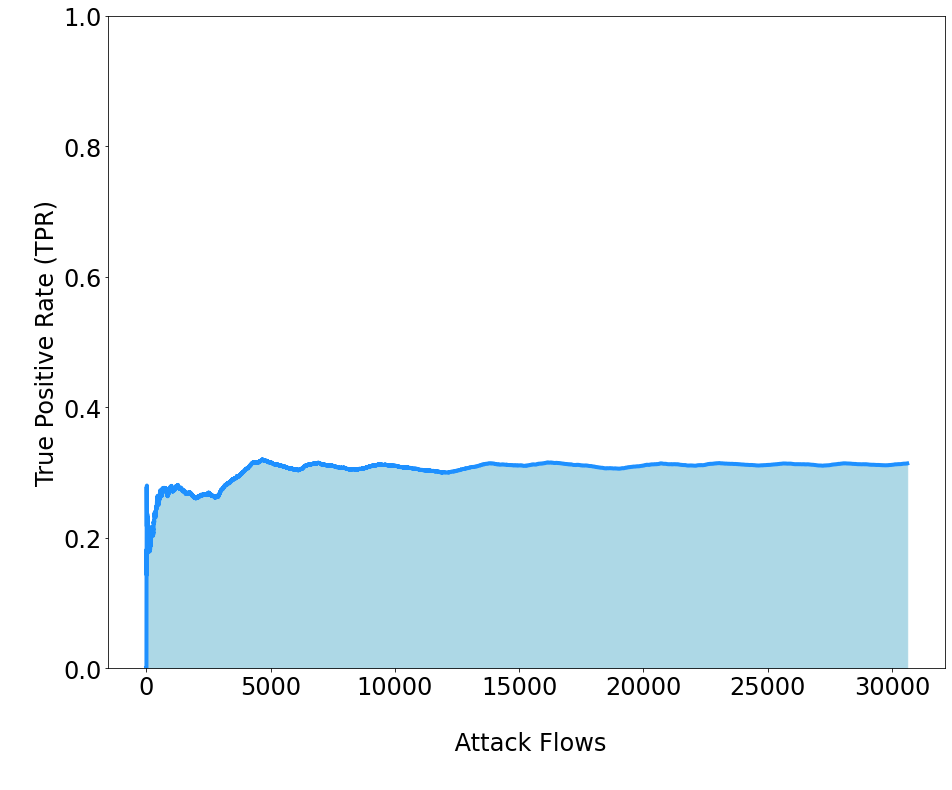


################[4] NonAI AA1##########################

Confusion matrix:

[[23603  3314]
 [18169  8748]]

Total number of true positives(Attack identified as Attack)) 8748
Total number of false negatives (Attack identified as Benign) 18169
Total number of false positives(Benign identified as Attack) 3314
Total number of true negatives (Benign identified as Benign) 23603
Real positives: 26917
Real negatives: 26917
Predicted positives: 12062
Predicted negatives: 41772 

Classifier Accuracy: 60.09%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 32.50%
True Negative Rate (TNR/Specificity/selectivity):87.69%
Balanced accuracy:60.09%
Overall error rate (OER):39.91%
False Positive Rate (FPR)/Fall out: 12.31%
Evasion Success Rate (ESR/FNR/Miss Rate): 67.50%
Total number of correct predictions(Precision/Positive Predictive value/PPV):72.53%
F1-Score: 44.89%
Negative Predictive value (NPV):56.50%
False Discovery Rate (FDR):27.47%
Informedness: 0.20
Markedness:0.29
Misclassification/ er

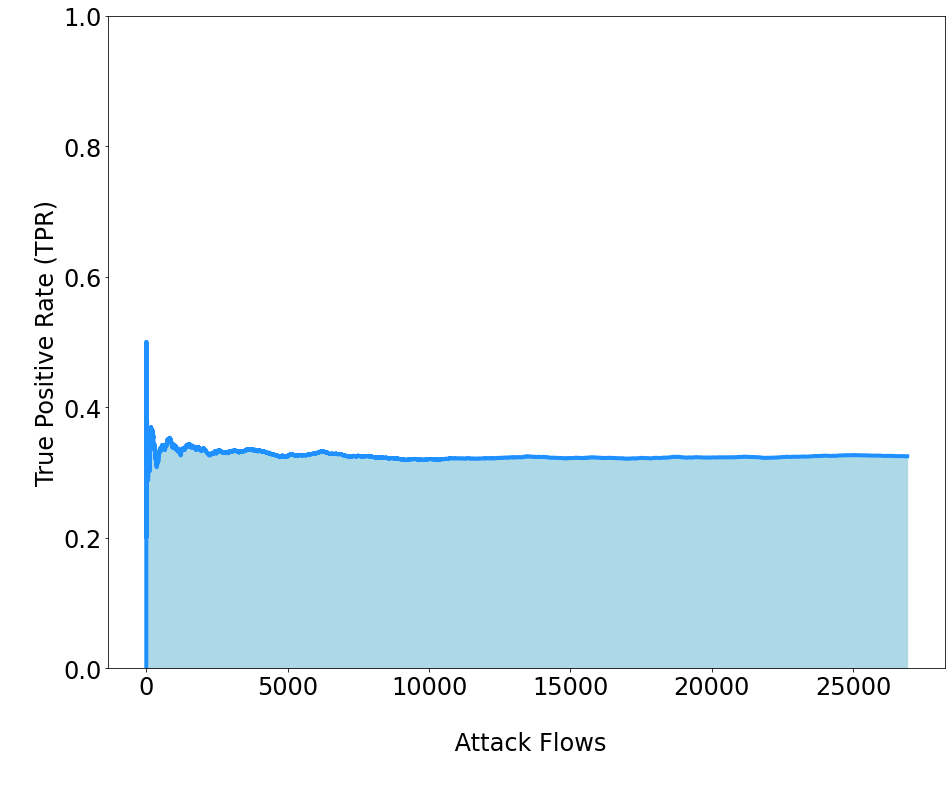


################[5] NonAI AA2##########################

Confusion matrix:

[[23599  3386]
 [18296  8689]]

Total number of true positives(Attack identified as Attack)) 8689
Total number of false negatives (Attack identified as Benign) 18296
Total number of false positives(Benign identified as Attack) 3386
Total number of true negatives (Benign identified as Benign) 23599
Real positives: 26985
Real negatives: 26985
Predicted positives: 12075
Predicted negatives: 41895 

Classifier Accuracy: 59.83%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 32.20%
True Negative Rate (TNR/Specificity/selectivity):87.45%
Balanced accuracy:59.83%
Overall error rate (OER):40.17%
False Positive Rate (FPR)/Fall out: 12.55%
Evasion Success Rate (ESR/FNR/Miss Rate): 67.80%
Total number of correct predictions(Precision/Positive Predictive value/PPV):71.96%
F1-Score: 44.49%
Negative Predictive value (NPV):56.33%
False Discovery Rate (FDR):28.04%
Informedness: 0.20
Markedness:0.28
Misclassification/ er

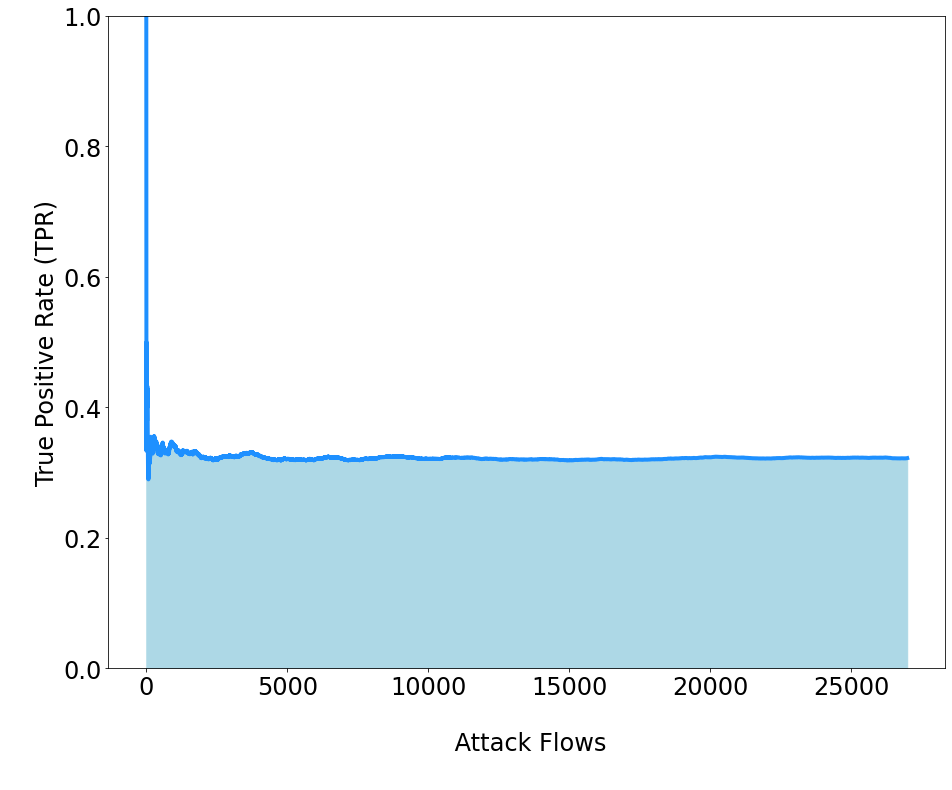


################[6] NonAI AA3##########################

Confusion matrix:

[[26864  3755]
 [20630  9989]]

Total number of true positives(Attack identified as Attack)) 9989
Total number of false negatives (Attack identified as Benign) 20630
Total number of false positives(Benign identified as Attack) 3755
Total number of true negatives (Benign identified as Benign) 26864
Real positives: 30619
Real negatives: 30619
Predicted positives: 13744
Predicted negatives: 47494 

Classifier Accuracy: 60.18%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 32.62%
True Negative Rate (TNR/Specificity/selectivity):87.74%
Balanced accuracy:60.18%
Overall error rate (OER):39.82%
False Positive Rate (FPR)/Fall out: 12.26%
Evasion Success Rate (ESR/FNR/Miss Rate): 67.38%
Total number of correct predictions(Precision/Positive Predictive value/PPV):72.68%
F1-Score: 45.03%
Negative Predictive value (NPV):56.56%
False Discovery Rate (FDR):27.32%
Informedness: 0.20
Markedness:0.29
Misclassification/ er

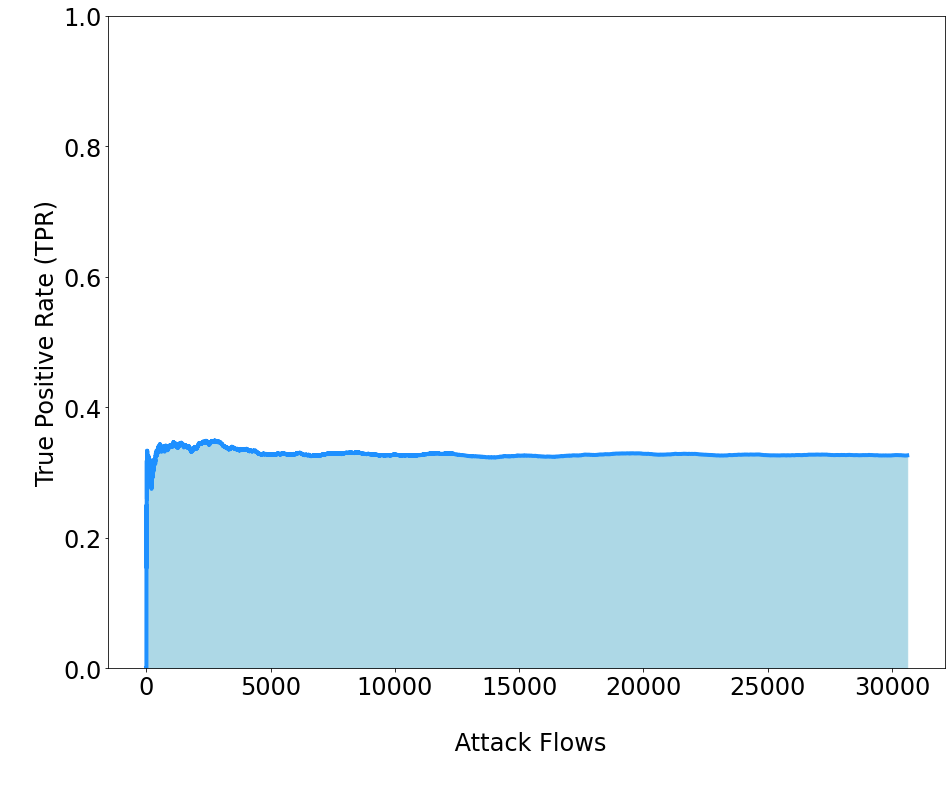

ID-CVAE Results 

TPR: 3.24%, TNR: 87.67%, BA: 45.45%, pID: -0.09 , ESR: 96.76%, OER: 54.55%, Precision: 20.79%, F1-score: 5.60%, Markedness: -0.32
TPR: 3.02%, TNR: 87.69%, BA: 45.35%, pID: -0.09 , ESR: 96.98%, OER: 54.65%, Precision: 19.69%, F1-score: 5.23%, Markedness: -0.33
TPR: 31.38%, TNR: 88.14%, BA: 59.76%, pID: 0.20 , ESR: 68.62%, OER: 40.24%, Precision: 72.57%, F1-score: 43.82%, Markedness: 0.29
TPR: 32.50%, TNR: 87.69%, BA: 60.09%, pID: 0.20 , ESR: 67.50%, OER: 39.91%, Precision: 72.53%, F1-score: 44.89%, Markedness: 0.29
TPR: 32.20%, TNR: 87.45%, BA: 59.83%, pID: 0.20 , ESR: 67.80%, OER: 40.17%, Precision: 71.96%, F1-score: 44.49%, Markedness: 0.28
TPR: 32.62%, TNR: 87.74%, BA: 60.18%, pID: 0.20 , ESR: 67.38%, OER: 39.82%, Precision: 72.68%, F1-score: 45.03%, Markedness: 0.29


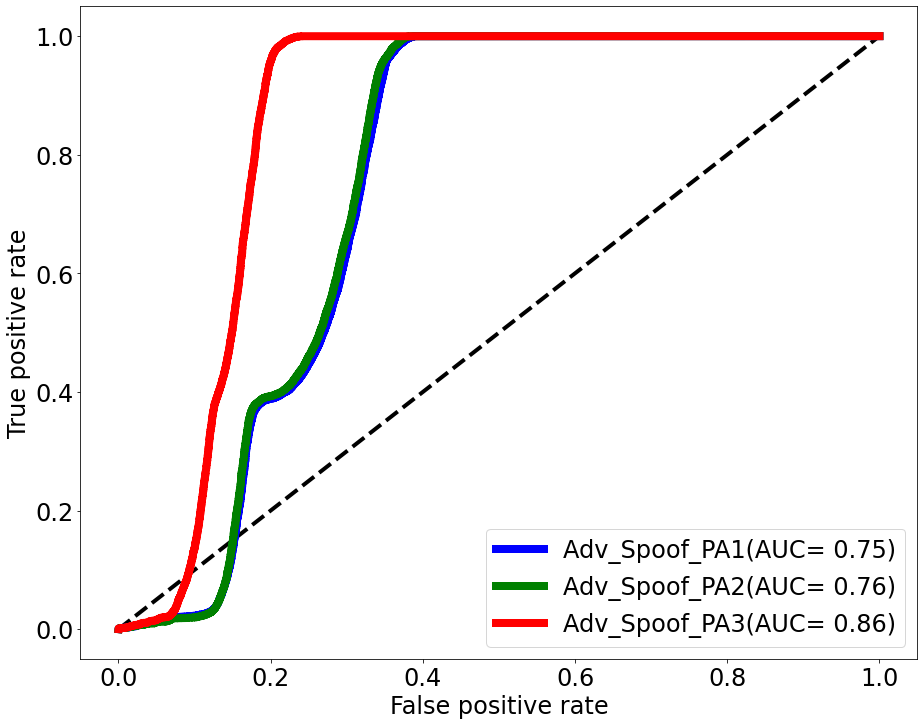

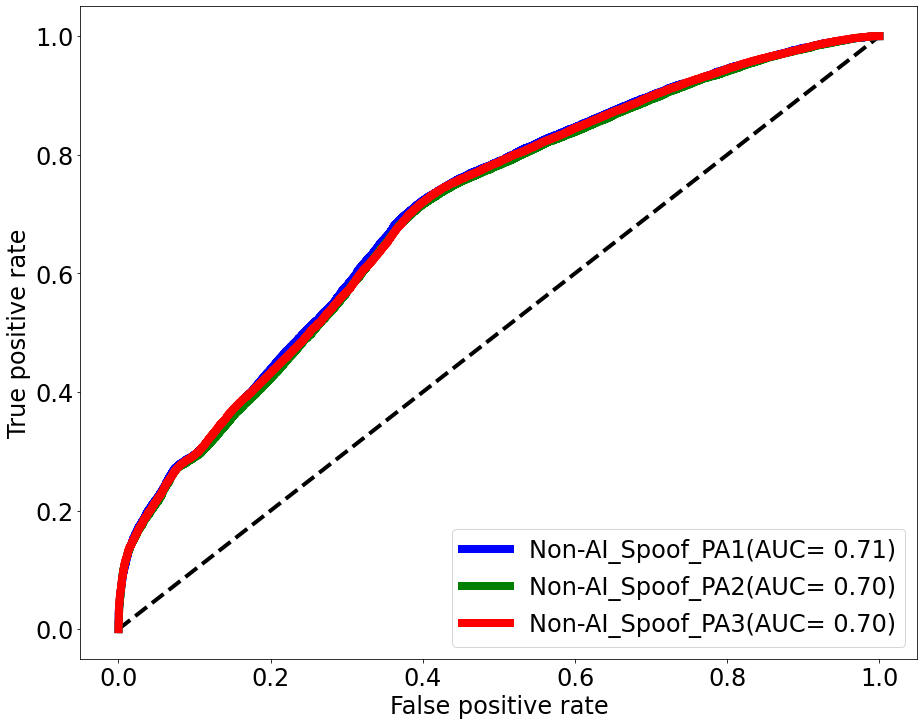

Getting data for: Web
AA1: 1.0    2006
Name: label, dtype: int64
AA2: 1.0    2359
Name: label, dtype: int64
AA3: 1.0    2170
Name: label, dtype: int64
poly1: 1    2006
Name: label, dtype: int64
poly2: 1    2359
Name: label, dtype: int64
poly3: 1    2170
Name: label, dtype: int64
(4012, 20)
(4012,)
(4718, 20)
(4718,)
(4340, 20)
(4340,)
(4012, 20)
(4012,)
(4718, 20)
(4718,)
(4340, 20)
(4340,)

 Results for: Web

################[1] Adver AA1##########################

Confusion matrix:

[[1757  249]
 [1061  945]]

Total number of true positives(Attack identified as Attack)) 945
Total number of false negatives (Attack identified as Benign) 1061
Total number of false positives(Benign identified as Attack) 249
Total number of true negatives (Benign identified as Benign) 1757
Real positives: 2006
Real negatives: 2006
Predicted positives: 1194
Predicted negatives: 2818 

Classifier Accuracy: 67.35%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 47.11%
True Negative Rate (TNR/Specificit

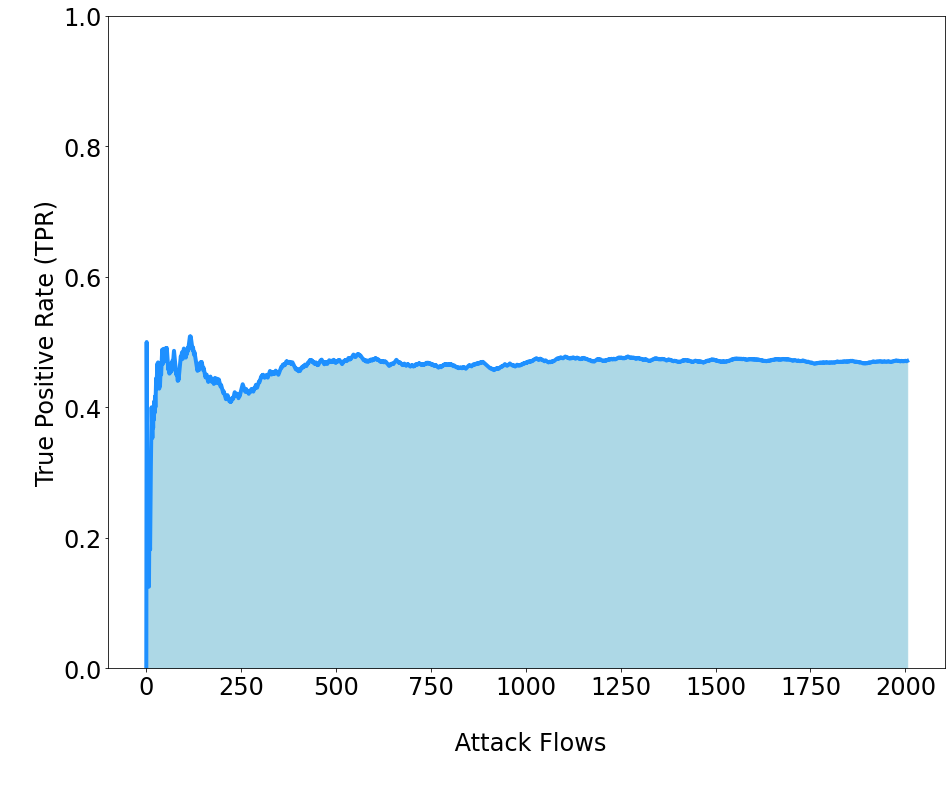


################[2] Adver AA2##########################

Confusion matrix:

[[2063  296]
 [1285 1074]]

Total number of true positives(Attack identified as Attack)) 1074
Total number of false negatives (Attack identified as Benign) 1285
Total number of false positives(Benign identified as Attack) 296
Total number of true negatives (Benign identified as Benign) 2063
Real positives: 2359
Real negatives: 2359
Predicted positives: 1370
Predicted negatives: 3348 

Classifier Accuracy: 66.49%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 45.53%
True Negative Rate (TNR/Specificity/selectivity):87.45%
Balanced accuracy:66.49%
Overall error rate (OER):33.51%
False Positive Rate (FPR)/Fall out: 12.55%
Evasion Success Rate (ESR/FNR/Miss Rate): 54.47%
Total number of correct predictions(Precision/Positive Predictive value/PPV):78.39%
F1-Score: 57.60%
Negative Predictive value (NPV):61.62%
False Discovery Rate (FDR):21.61%
Informedness: 0.33
Markedness:0.40
Misclassification/ error rate:33

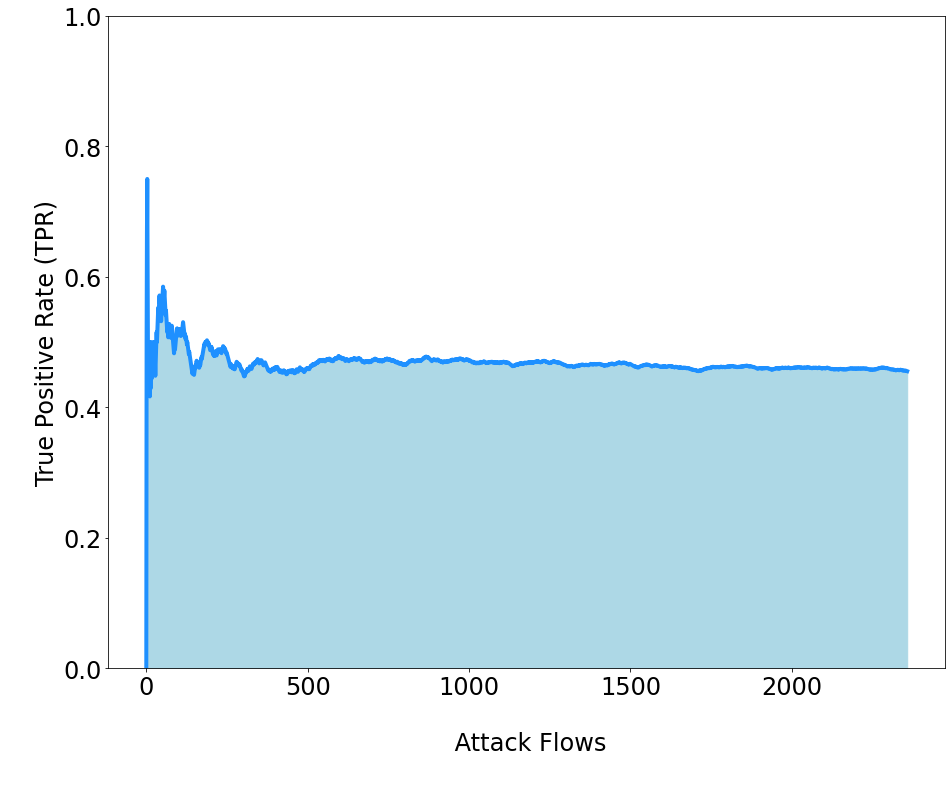


################[3] Adver AA3##########################

Confusion matrix:

[[1894  276]
 [1201  969]]

Total number of true positives(Attack identified as Attack)) 969
Total number of false negatives (Attack identified as Benign) 1201
Total number of false positives(Benign identified as Attack) 276
Total number of true negatives (Benign identified as Benign) 1894
Real positives: 2170
Real negatives: 2170
Predicted positives: 1245
Predicted negatives: 3095 

Classifier Accuracy: 65.97%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 44.65%
True Negative Rate (TNR/Specificity/selectivity):87.28%
Balanced accuracy:65.97%
Overall error rate (OER):34.03%
False Positive Rate (FPR)/Fall out: 12.72%
Evasion Success Rate (ESR/FNR/Miss Rate): 55.35%
Total number of correct predictions(Precision/Positive Predictive value/PPV):77.83%
F1-Score: 56.75%
Negative Predictive value (NPV):61.20%
False Discovery Rate (FDR):22.17%
Informedness: 0.32
Markedness:0.39
Misclassification/ error rate:34.

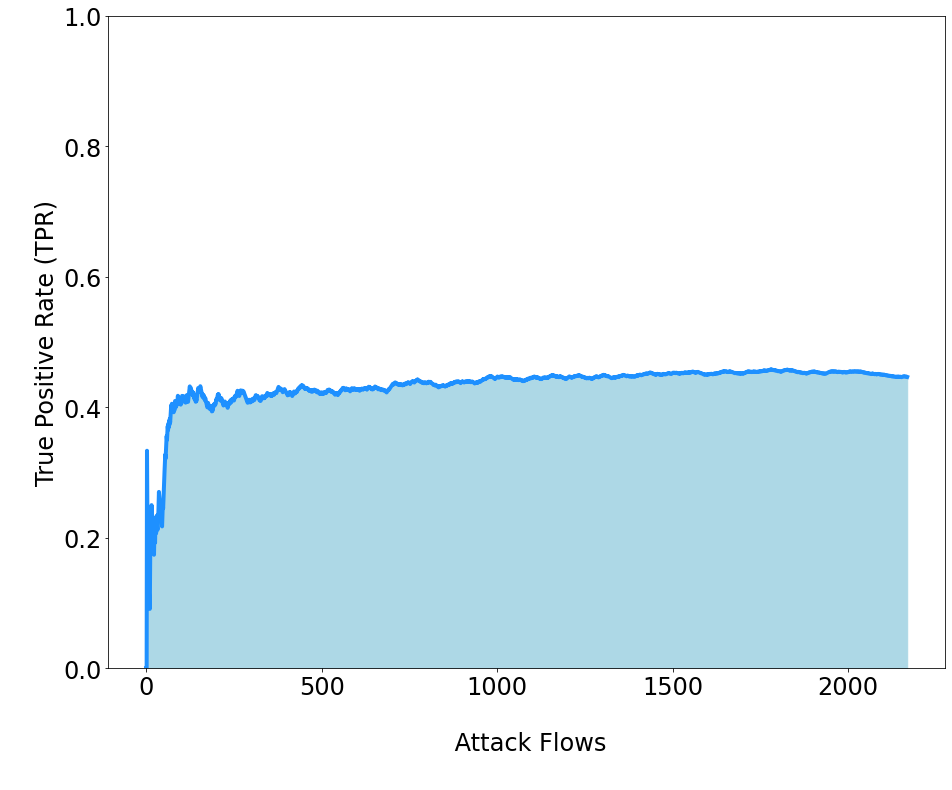


################[4] NonAI AA1##########################

Confusion matrix:

[[1765  241]
 [1126  880]]

Total number of true positives(Attack identified as Attack)) 880
Total number of false negatives (Attack identified as Benign) 1126
Total number of false positives(Benign identified as Attack) 241
Total number of true negatives (Benign identified as Benign) 1765
Real positives: 2006
Real negatives: 2006
Predicted positives: 1121
Predicted negatives: 2891 

Classifier Accuracy: 65.93%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 43.87%
True Negative Rate (TNR/Specificity/selectivity):87.99%
Balanced accuracy:65.93%
Overall error rate (OER):34.07%
False Positive Rate (FPR)/Fall out: 12.01%
Evasion Success Rate (ESR/FNR/Miss Rate): 56.13%
Total number of correct predictions(Precision/Positive Predictive value/PPV):78.50%
F1-Score: 56.28%
Negative Predictive value (NPV):61.05%
False Discovery Rate (FDR):21.50%
Informedness: 0.32
Markedness:0.40
Misclassification/ error rate:34.

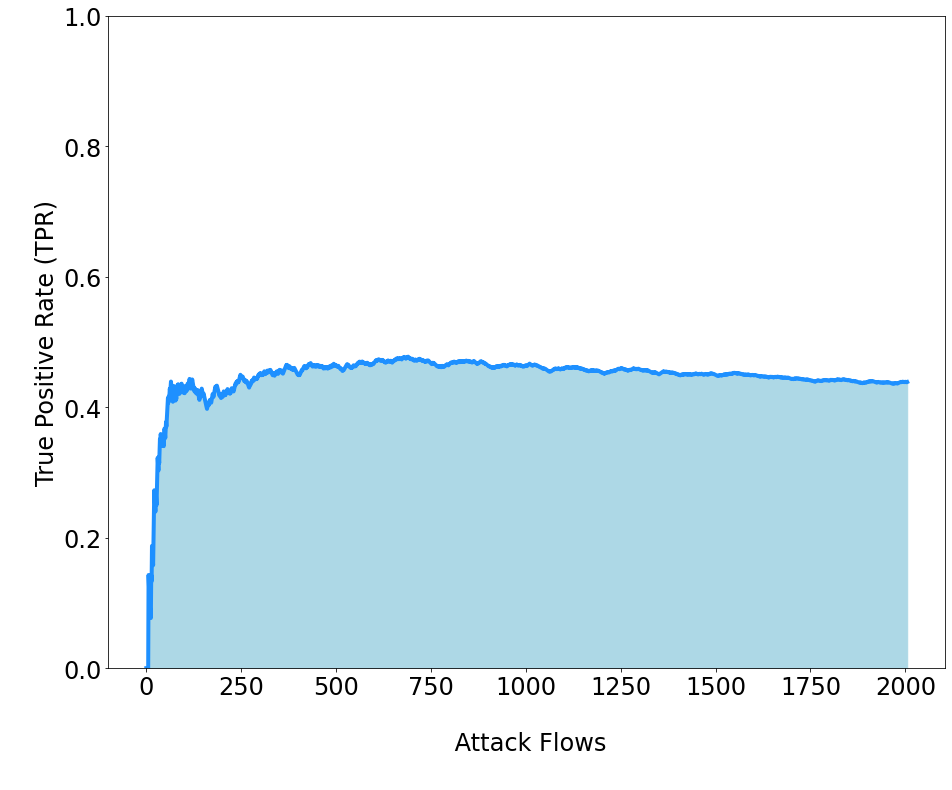


################[5] NonAI AA2##########################

Confusion matrix:

[[2097  262]
 [1313 1046]]

Total number of true positives(Attack identified as Attack)) 1046
Total number of false negatives (Attack identified as Benign) 1313
Total number of false positives(Benign identified as Attack) 262
Total number of true negatives (Benign identified as Benign) 2097
Real positives: 2359
Real negatives: 2359
Predicted positives: 1308
Predicted negatives: 3410 

Classifier Accuracy: 66.62%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 44.34%
True Negative Rate (TNR/Specificity/selectivity):88.89%
Balanced accuracy:66.62%
Overall error rate (OER):33.38%
False Positive Rate (FPR)/Fall out: 11.11%
Evasion Success Rate (ESR/FNR/Miss Rate): 55.66%
Total number of correct predictions(Precision/Positive Predictive value/PPV):79.97%
F1-Score: 57.05%
Negative Predictive value (NPV):61.50%
False Discovery Rate (FDR):20.03%
Informedness: 0.33
Markedness:0.41
Misclassification/ error rate:33

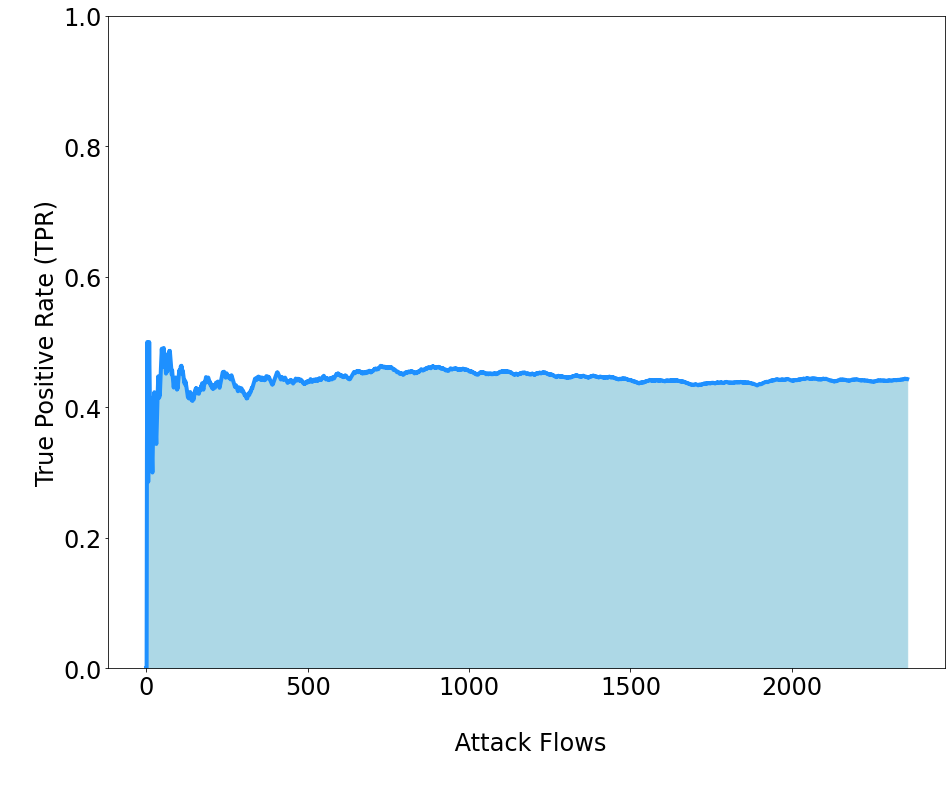


################[6] NonAI AA3##########################

Confusion matrix:

[[1902  268]
 [1216  954]]

Total number of true positives(Attack identified as Attack)) 954
Total number of false negatives (Attack identified as Benign) 1216
Total number of false positives(Benign identified as Attack) 268
Total number of true negatives (Benign identified as Benign) 1902
Real positives: 2170
Real negatives: 2170
Predicted positives: 1222
Predicted negatives: 3118 

Classifier Accuracy: 65.81%
True Positive Rate (TPR/Recall/Sensitivity/Hit rate): 43.96%
True Negative Rate (TNR/Specificity/selectivity):87.65%
Balanced accuracy:65.81%
Overall error rate (OER):34.19%
False Positive Rate (FPR)/Fall out: 12.35%
Evasion Success Rate (ESR/FNR/Miss Rate): 56.04%
Total number of correct predictions(Precision/Positive Predictive value/PPV):78.07%
F1-Score: 56.25%
Negative Predictive value (NPV):61.00%
False Discovery Rate (FDR):21.93%
Informedness: 0.32
Markedness:0.39
Misclassification/ error rate:34.

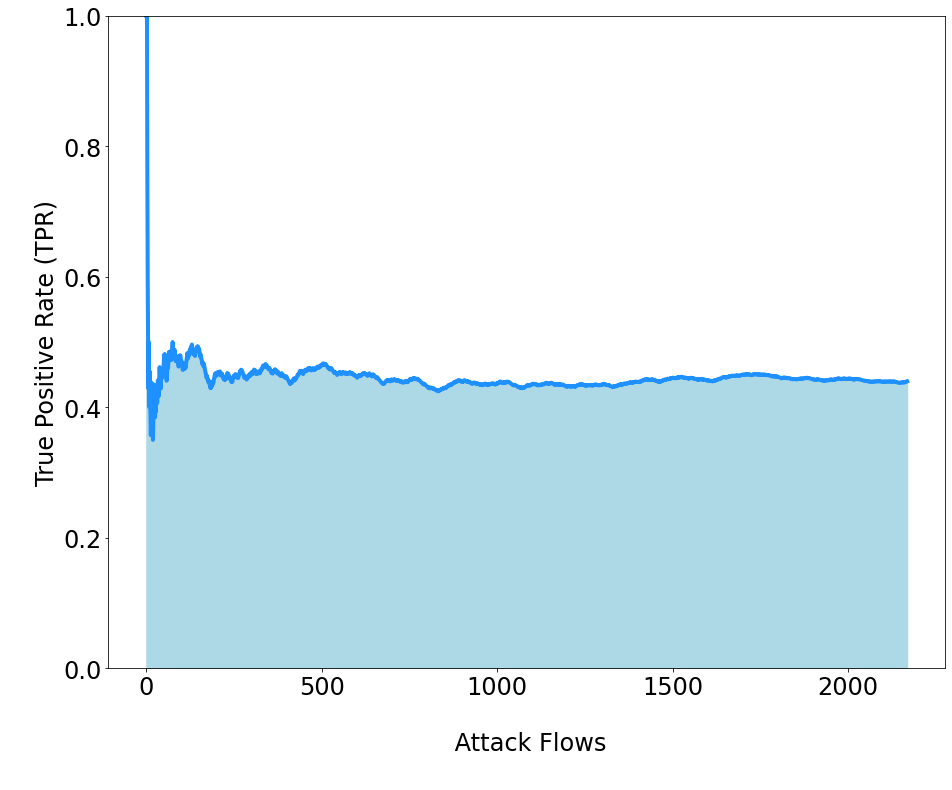

ID-CVAE Results 

TPR: 47.11%, TNR: 87.59%, BA: 67.35%, pID: 0.35 , ESR: 52.89%, OER: 32.65%, Precision: 79.15%, F1-score: 59.06%, Markedness: 0.41
TPR: 45.53%, TNR: 87.45%, BA: 66.49%, pID: 0.33 , ESR: 54.47%, OER: 33.51%, Precision: 78.39%, F1-score: 57.60%, Markedness: 0.40
TPR: 44.65%, TNR: 87.28%, BA: 65.97%, pID: 0.32 , ESR: 55.35%, OER: 34.03%, Precision: 77.83%, F1-score: 56.75%, Markedness: 0.39
TPR: 43.87%, TNR: 87.99%, BA: 65.93%, pID: 0.32 , ESR: 56.13%, OER: 34.07%, Precision: 78.50%, F1-score: 56.28%, Markedness: 0.40
TPR: 44.34%, TNR: 88.89%, BA: 66.62%, pID: 0.33 , ESR: 55.66%, OER: 33.38%, Precision: 79.97%, F1-score: 57.05%, Markedness: 0.41
TPR: 43.96%, TNR: 87.65%, BA: 65.81%, pID: 0.32 , ESR: 56.04%, OER: 34.19%, Precision: 78.07%, F1-score: 56.25%, Markedness: 0.39


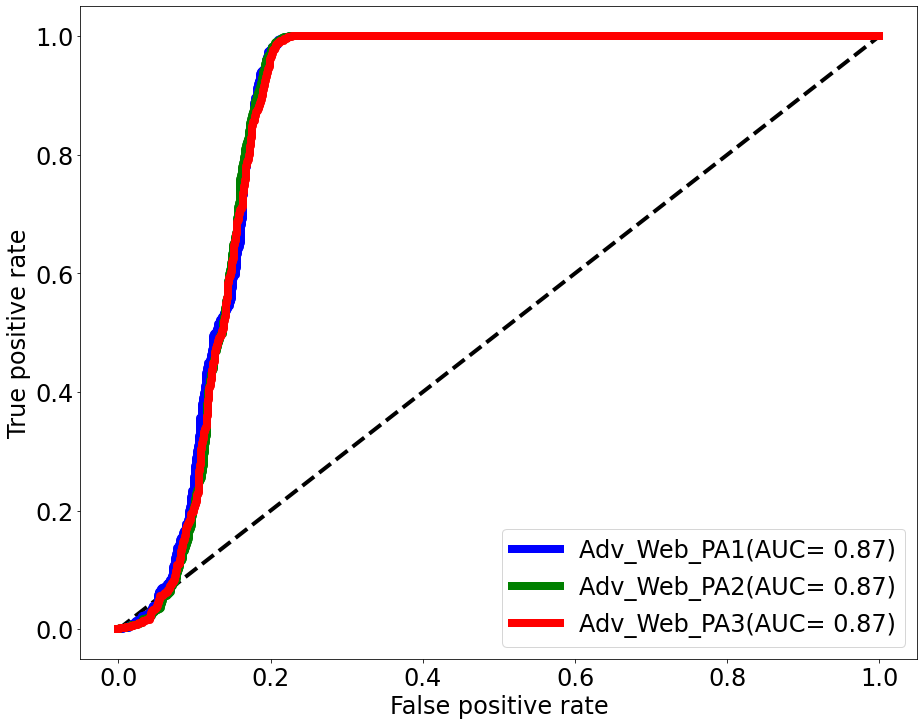

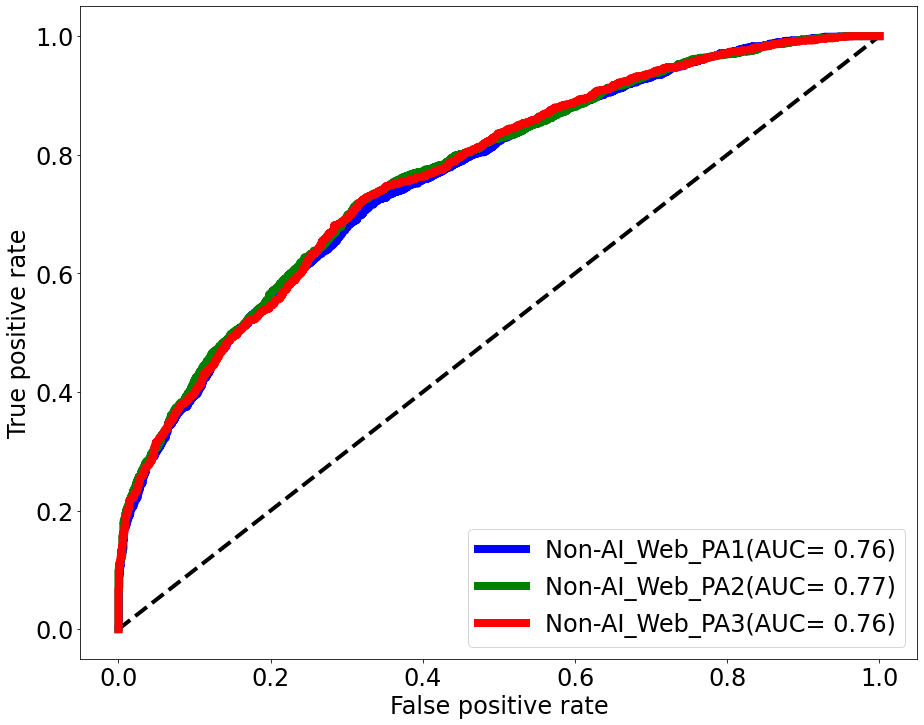

In [223]:
import csv
from numpy.random import randn
from numpy.random import randint

classes = ['Brute', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoof', 'Web']
for class_class in classes:
    tpr_csv, tnr_csv, prec_csv, bal_accu_csv,o_error_csv, f1_csv, inform_csv, mark_csv, acc_csv, fpr_csv, fnr_csv, npv_csv, fdr_csv, error_csv= list(),list(),list(),list(),list(),list(),list(),list(),list(),list(),list(),list(),list(),list()
    
    X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,X6,Y6 = get_data(class_class)
    X1_trfm, X2_trfm, X3_trfm, X4_trfm, X5_trfm, X6_trfm, Y1_tst, Y2_tst, Y3_tst, Y4_tst, Y5_tst, Y6_tst = add_normal_trfm(X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,X6,Y6)

    print('\n Results for: ' +  class_class)
    print("\n################[1] Adver AA1##########################\n")
    eval_metrics(X1_trfm, Y1_tst)
    print("\n################[2] Adver AA2##########################\n")
    eval_metrics(X2_trfm, Y2_tst)
    print("\n################[3] Adver AA3##########################\n")
    eval_metrics(X3_trfm, Y3_tst)
    print("\n################[4] NonAI AA1##########################\n")
    eval_metrics(X4_trfm, Y4_tst)
    print("\n################[5] NonAI AA2##########################\n")
    eval_metrics(X5_trfm, Y5_tst)
    print("\n################[6] NonAI AA3##########################\n")
    eval_metrics(X6_trfm, Y6_tst)
    print_results()
    save_2_csv(class_class)
    output_graphs([X1_trfm, X2_trfm, X3_trfm], [Y1_tst, Y2_tst,Y3_tst], True, class_class)
    output_graphs([X4_trfm, X5_trfm, X6_trfm], [Y4_tst, Y5_tst,Y6_tst], False, class_class)